In [ ]:
# in this notebook, I will try to fit a model relating the mean behavior of L4, L2/3, SST and VIP cells

In [ ]:
# load the data

In [178]:
import pyute as ut
import autograd.numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import pdb
import scipy.optimize as sop
from mpl_toolkits.mplot3d import Axes3D
import sklearn.discriminant_analysis as skd
import autograd.scipy.special as ssp
from autograd import elementwise_grad as egrad
from autograd import grad
from autograd import jacobian
from autograd import hessian
import size_contrast_analysis as sca
import scipy.stats as sst
import sim_utils
from importlib import reload
reload(sim_utils)
import calnet.utils
import calnet.fitting_spatial_feature_opto
import opto_utils
import glob
import scipy.signal as ssi
%matplotlib notebook

In [173]:
npfile = np.load('rs_vm_denoise_200605.npy',allow_pickle=True)[()]#,{'rs':rs,'rs_denoise':rs_denoise},allow_pickle=True)
rs = npfile['rs']
rs_denoise = npfile['rs_denoise']

<IPython.core.display.Javascript object>


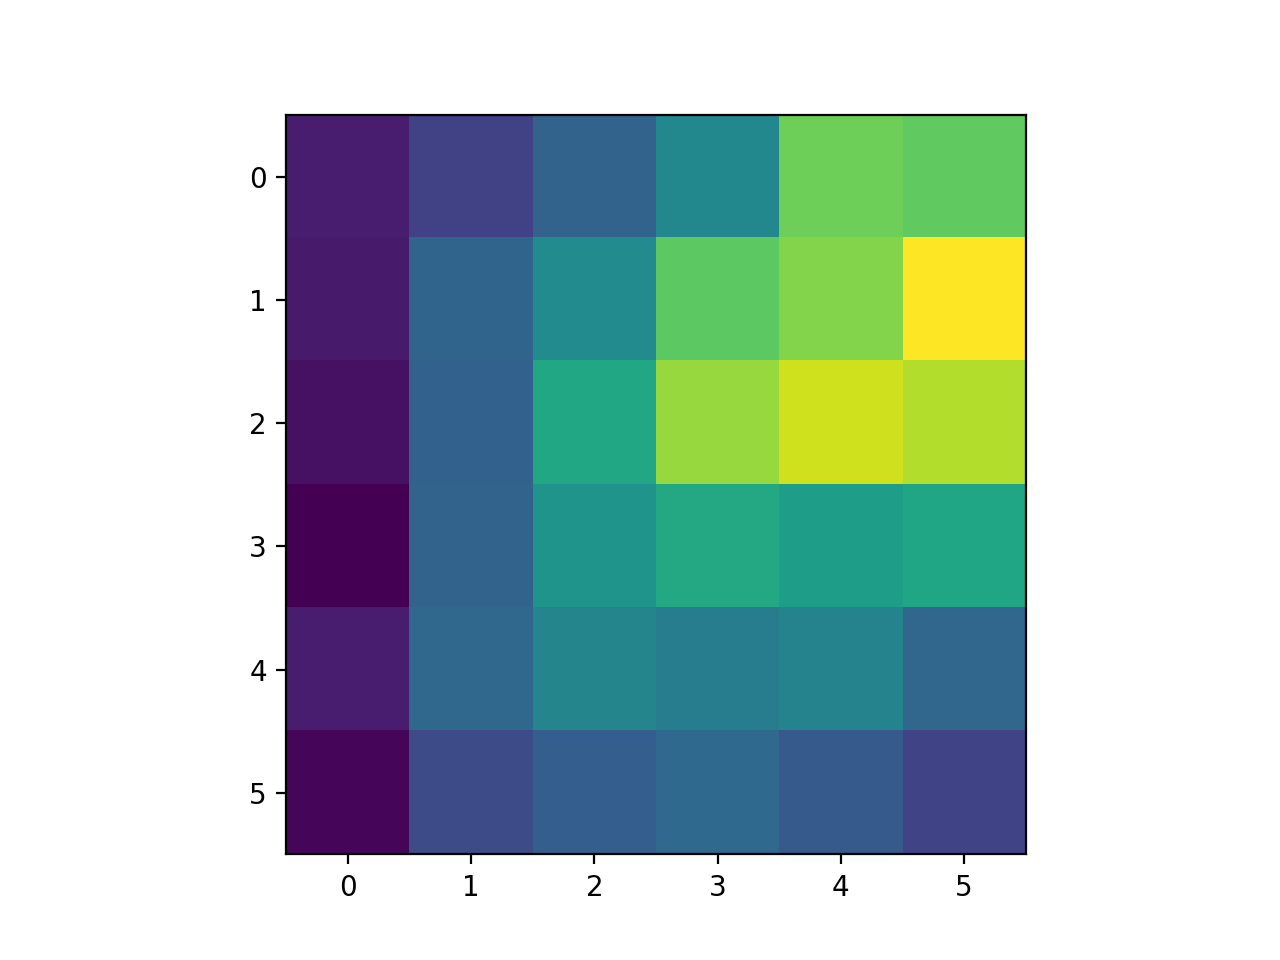

In [273]:
plt.figure()
icelltype = 0
plt.imshow(np.nanmean(np.nanmean(rs[icelltype][0],-1),0))

In [179]:
nsize,ncontrast,ndir = 5,6,8
ori_dirs = [[0,4],[2,6]] #[[0,4],[1,3,5,7],[2,6]]
nT = len(ori_dirs)
nS = len(rs_denoise[0])

def sum_to_1(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nansum(R[:,~np.isnan(R.sum(0))],axis=1)[:,np.newaxis]
    return R

def norm_to_mean(r):
    R = r.reshape((r.shape[0],-1))
    R = R/np.nanmean(R[:,~np.isnan(R.sum(0))],axis=1)[:,np.newaxis]
    return R

Rs = [[None,None] for i in range(len(rs))]
Rso = [[[None for iT in range(nT)] for iS in range(nS)] for icelltype in range(len(rs))]
rso = [[[None for iT in range(nT)] for iS in range(nS)] for icelltype in range(len(rs))]

for iR,r in enumerate(rs_denoise):
    print(iR)
    for ialign in range(nS):
        Rs[iR][ialign] = sum_to_1(r[ialign][:,:nsize,:])
#         Rs[iR][ialign] = von_mises_denoise(Rs[iR][ialign].reshape((-1,nsize,ncontrast,ndir)))

kernel = np.ones((1,2,2))
kernel = kernel/kernel.sum()

for iR,r in enumerate(rs):
    for ialign in range(nS):
        for iori in range(nT):
            Rso[iR][ialign][iori] = np.nanmean(Rs[iR][ialign].reshape((-1,nsize,ncontrast,ndir))[:,:,:,ori_dirs[iori]],-1)
            Rso[iR][ialign][iori] = ssi.convolve(Rso[iR][ialign][iori],kernel,'same')
            Rso[iR][ialign][iori] = Rso[iR][ialign][iori].reshape(Rso[iR][ialign][iori].shape[0],-1)

0
1
2
3
4


In [287]:
nS = 2
ndims = 5
ncelltypes = 5
Yhat = [[None for iT in range(nT)] for iS in range(nS)]
Xhat = [[None for iT in range(nT)] for iS in range(nS)]
Ypc_list = [[None for iT in range(nT)] for iS in range(nS)]
Xpc_list = [[None for iT in range(nT)] for iS in range(nS)]
for iS in range(nS):
    mx = np.zeros((ncelltypes,))
    yy = [None for icelltype in range(ncelltypes)]
    for icelltype in range(ncelltypes):
        yy[icelltype] = np.nanmean(Rso[icelltype][iS][0],0)
        mx[icelltype] = np.nanmax(yy[icelltype])
    for iT in range(nT):
        y = [np.nanmean(Rso[icelltype][iS][iT]/mx[icelltype],axis=0)[:,np.newaxis] for icelltype in range(1,ncelltypes)]#
        Ypc_list[iS][iT] = [None for icelltype in range(1,ncelltypes)]
        for icelltype in range(1,ncelltypes):
            print((icelltype,iS,iT))
            rss = Rso[icelltype][iS][iT].copy() #.reshape(Rs[icelltype][ialign].shape[0],-1)
    #         print(rss.max())
    #         rss[rss<0] = 0
    #         rss = rss[np.random.randn(rss.shape[0])>0]
            try:
                u,s,v = np.linalg.svd(rss-np.mean(rss,0)[np.newaxis])
                Ypc_list[iS][iT][icelltype-1] = [(s[idim],v[idim]) for idim in range(ndims)]
#                 print('yep on Y')
#                 print(np.min(np.sum(rs[icelltype][iS][iT],axis=1)))
            except:
#                 print('nope on Y')
                print(np.mean(np.isnan(rss)))
                print(np.min(np.sum(rs[icelltype][iS][iT],axis=1)))
        Yhat[iS][iT] = np.concatenate(y,axis=1)
#         x = sim_utils.columnize(Rso[0][iS][iT])[:,np.newaxis]
        icelltype = 0
        x = np.nanmean(Rso[icelltype][iS][iT]/mx[icelltype],0)[:,np.newaxis]#/mx[icelltype]
#         opto_column = np.concatenate((np.zeros((nN,)),np.zeros((nNO/2,)),np.ones((nNO/2,))),axis=0)[:,np.newaxis]
        Xhat[iS][iT] = np.concatenate((x,np.ones_like(x)),axis=1)
#         Xhat[iS][iT] = np.concatenate((x,np.ones_like(x),opto_column),axis=1)
        icelltype = 0
        rss = Rso[icelltype][iS][iT].copy()
#         try:
        u,s,v = np.linalg.svd(rss-rss.mean(0)[np.newaxis])
        Xpc_list[iS][iT] = [None for iinput in range(2)]
        Xpc_list[iS][iT][0] = [(s[idim],v[idim]) for idim in range(ndims)]
        Xpc_list[iS][iT][1] = [(0,np.zeros((Xhat[0][0].shape[0],))) for idim in range(ndims)]
#         except:
#             print('nope on X')
#             print(np.mean(np.isnan(rss)))
#             print(np.min(np.sum(Rso[icelltype][iS][iT],axis=1)))
nN,nP = Xhat[0][0].shape
nQ = Yhat[0][0].shape[1]

(1, 0, 0)
(2, 0, 0)
(3, 0, 0)
(4, 0, 0)
(1, 0, 1)
(2, 0, 1)
(3, 0, 1)
(4, 0, 1)
(1, 1, 0)
(2, 1, 0)
(3, 1, 0)
(4, 1, 0)
(1, 1, 1)
(2, 1, 1)
(3, 1, 1)
(4, 1, 1)


In [185]:
nS,nT = 2,2

def compute_f_(Eta,Xi,s02):
    return sim_utils.f_miller_troyer(Eta,Xi**2+np.concatenate([s02 for ipixel in range(nS*nT)]))

def compute_fprime_m_(Eta,Xi,s02):
    return sim_utils.fprime_miller_troyer(Eta,Xi**2+np.concatenate([s02 for ipixel in range(nS*nT)]))*Xi

def compute_fprime_s_(Eta,Xi,s02):
    s2 = Xi**2+np.concatenate((s02,s02),axis=0)
    return sim_utils.fprime_s_miller_troyer(Eta,s2)*(Xi/s2)

def sorted_r_eigs(w):
    drW,prW = np.linalg.eig(w)
    srtinds = np.argsort(drW)
    return drW[srtinds],prW[:,srtinds]

# def gen_Weight(W,K,kappa):
#     WW0 = np.concatenate((W,W*K[np.newaxis,:]),axis=1)
#     WW1 = np.concatenate((W*K[np.newaxis,:]*kappa,W),axis=1)
#     WW = np.concatenate((WW0,WW1),axis=0)
#     return WW

def u_fn(XX,YY,Wx,Wy,k,kappa):
    WWx,WWy = [gen_Weight(W,k,kappa) for W in [Wx,Wy]]
    return u_fn_WW(XX,YY,WWx,WWy)# XX @ WWx + YY @ WWy

def u_fn_WW(XX,YY,WWx,WWy):
    return XX @ WWx + YY @ WWy

def compute_steady_state(Wlist,Niter=int(4e2),max_val=2.5,Ny=50,fix_dim=None,stim_vals=None,dt=1e-2,perturbation_size=5e-2):
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wlist
    nQ = Wmy.shape[0]
    nN = Eta.shape[0]
    nS = int(Eta.shape[1]/nQ)
    
    if fix_dim is None:
        fix_dim = [None]
        Nfix = 1
        yvals = (0,)
        Ny = 1
        max_val = 0
    else:
        Nfix = len(fix_dim)
        yvals = np.linspace(0,max_val,Ny)
    
    if stim_vals is None:
        stim_vals = np.arange(nN)
    Nstim = len(stim_vals)
    
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    
    def fY(XX,YY):
        return compute_f_(resEta[stim_val]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[stim_val]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY_fix_dim(XX,YY0,fix_dim=None,run_backward=False,):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0 #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = dt*dYYdt(YY[iiter])
            if not fix_dim is None:
                dYY[fix_dim] = 0
            if run_backward:
                dYY = -dYY
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    
    YY_ss = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02)
    for istim,stim_val in enumerate(stim_vals): #range(nN):
        print(istim)
        for iy,yval in enumerate(yvals):
            for ifix in range(Nfix):
                yy0 = YY0[stim_val] + perturbation_size*np.random.randn(*(YY0[stim_val].shape))
                if not fix_dim[ifix] is None:
                    yy0[fix_dim[ifix]] = yval
                YY_ss[ifix,istim,iy] = predict_YY_fix_dim(XX[stim_val],yy0,fix_dim=fix_dim[ifix])
    if fix_dim[0] is None:
        YY_ss = YY_ss[0,:,0,:,:]
    return YY_ss

In [146]:
npyfile = np.load('/Users/dan/Documents/notebooks/mossing-PC/shared_data/calnet_data/vip_halo_data_for_sim.npy',allow_pickle=True)[()]
Yhat_opto = npyfile['Yhat_opto']

In [62]:
Yhat_opto.shape

(60, 16)

<IPython.core.display.Javascript object>


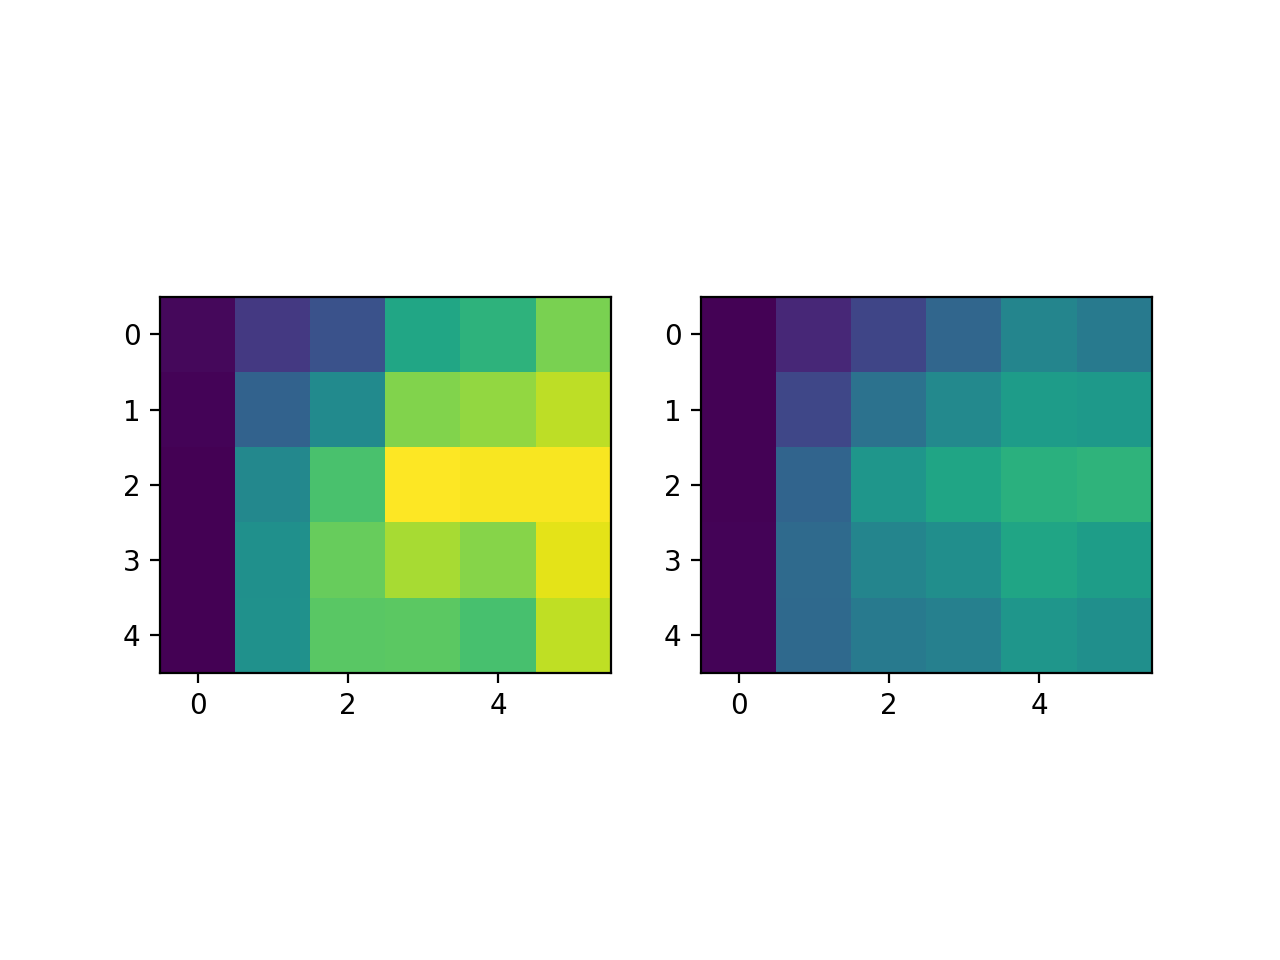

<IPython.core.display.Javascript object>


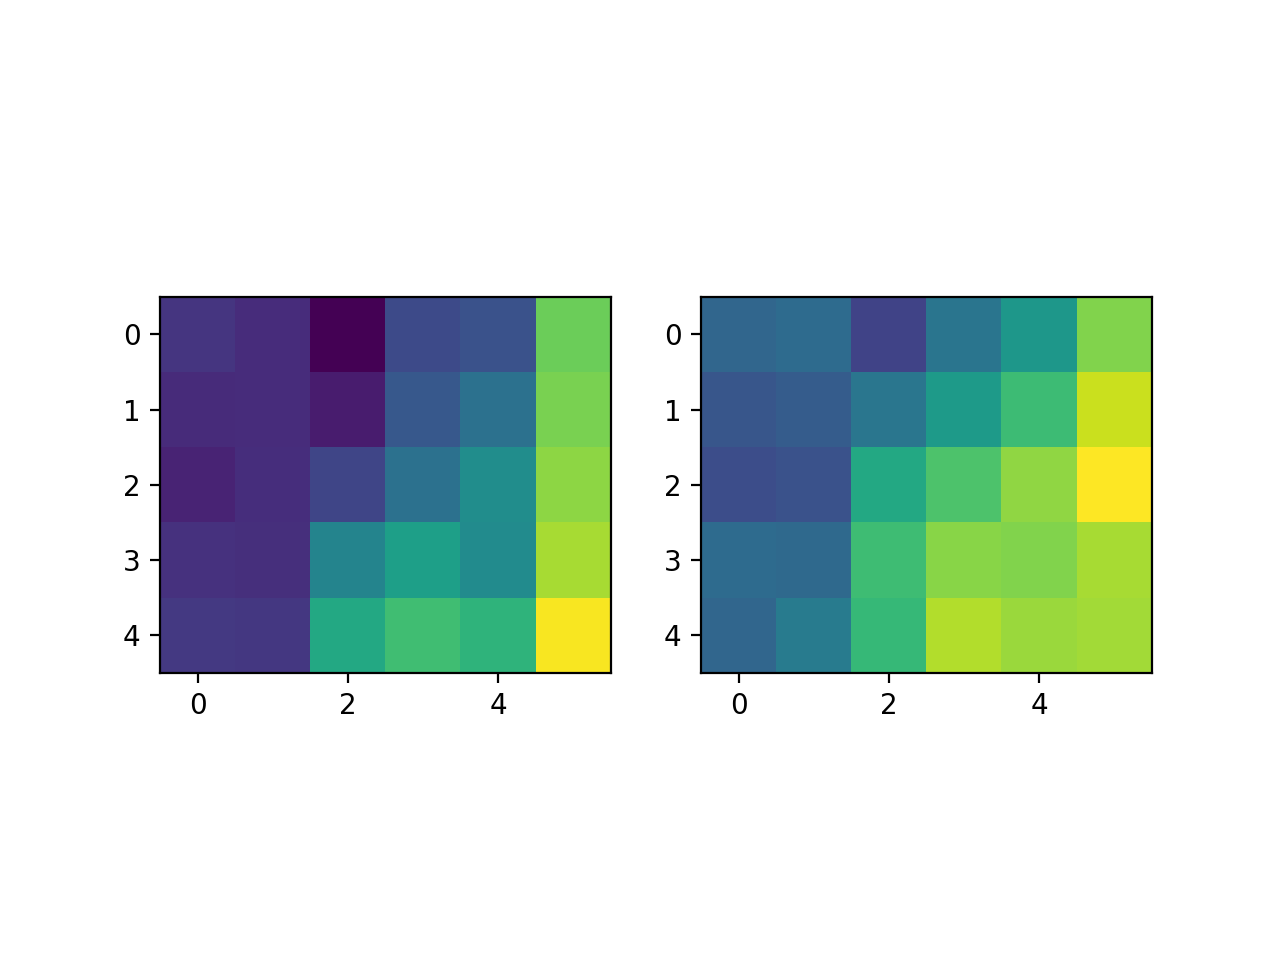

<IPython.core.display.Javascript object>


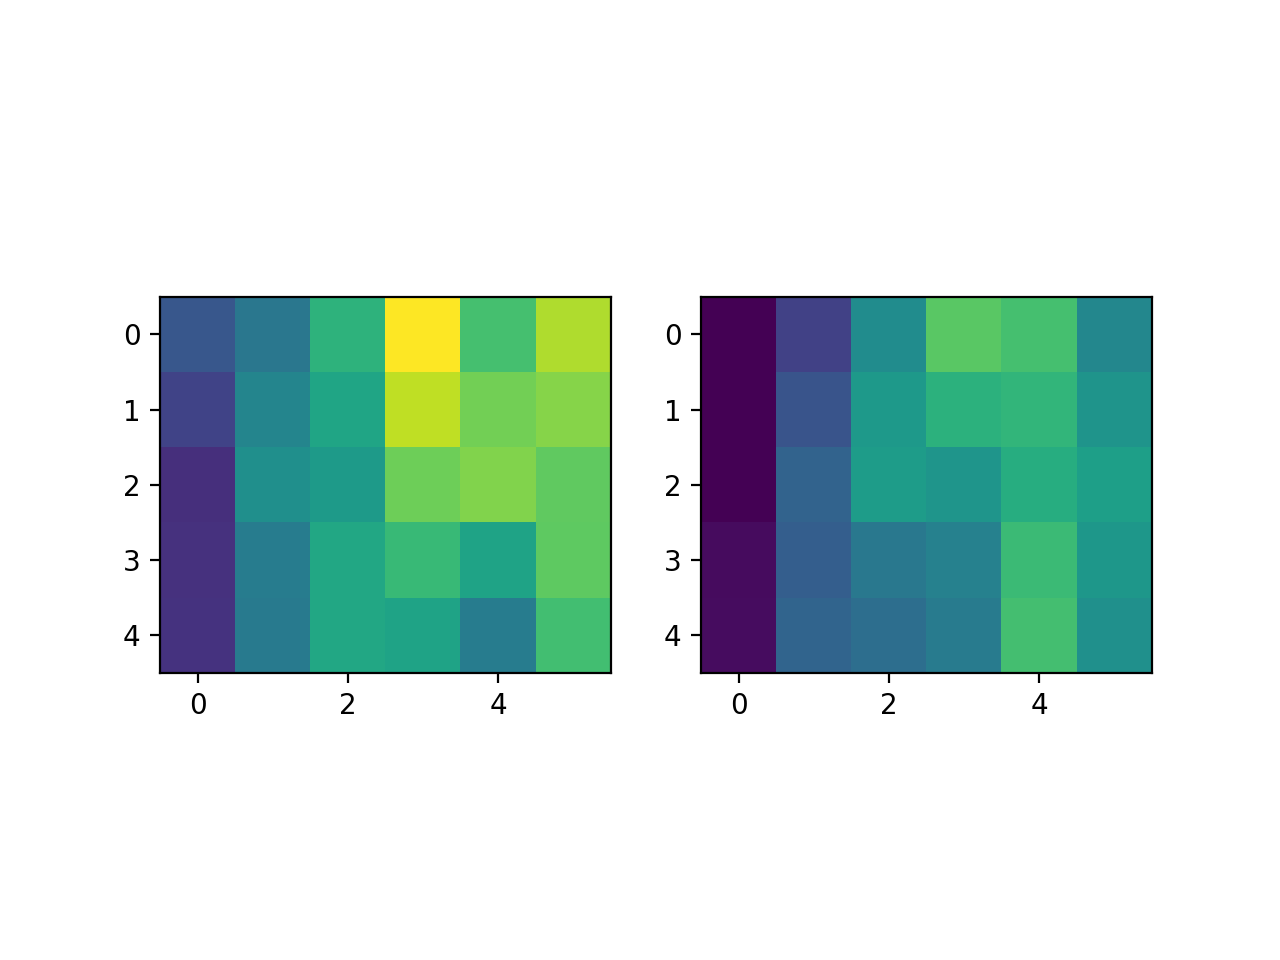

<IPython.core.display.Javascript object>


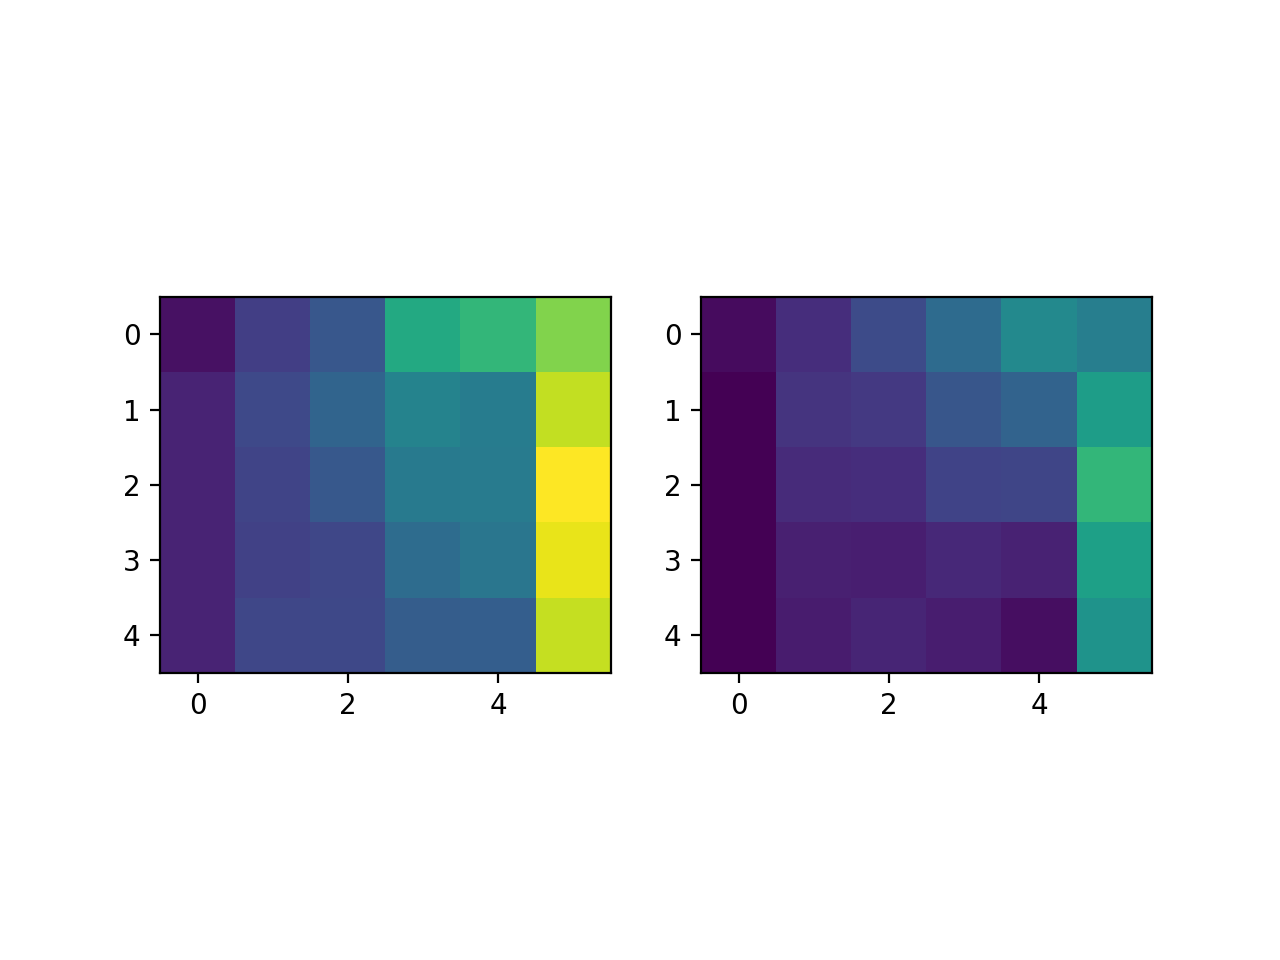

In [66]:
for itype in range(4):
    data = Yhat_opto.reshape((5,6,2,16))[:,:,:,itype]
    plt.figure()
    for ilight in range(2):
        plt.subplot(1,2,ilight+1)
        plt.imshow(data[:,:,ilight],vmin=data.min(),vmax=data.max())

In [274]:
weights_files = glob.glob('/Users/dan/Documents/notebooks/mossing-PC/shared_data/calnet_data/weights/weights_200712a/*.npy')
weights_files.sort()

<IPython.core.display.Javascript object>


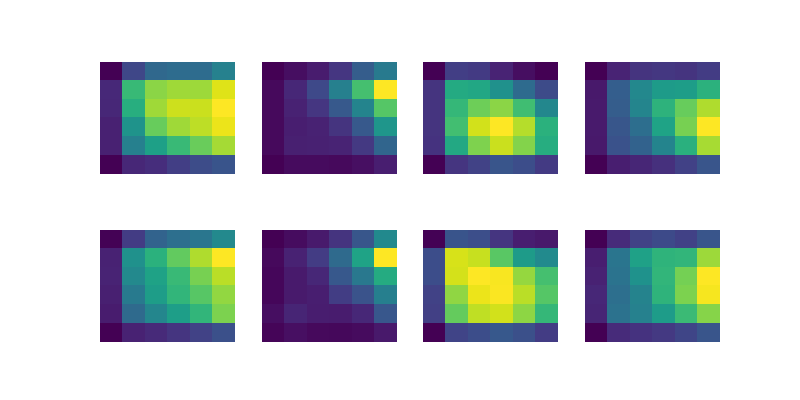

<IPython.core.display.Javascript object>


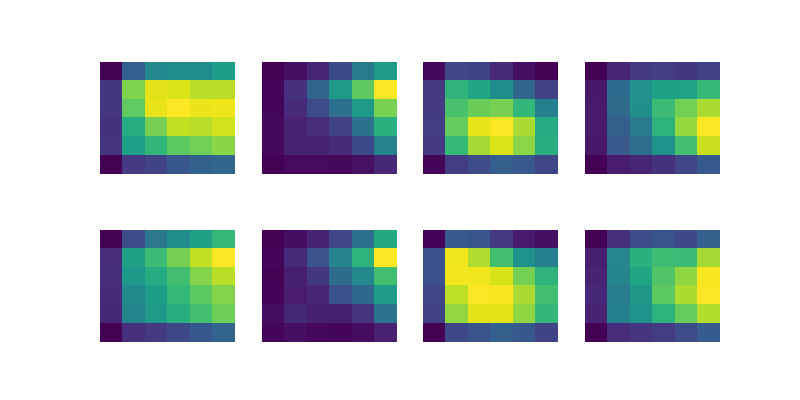

/Users/dan/Documents/code/adesnal/sim_utils.py:623: RuntimeWarning: divide by zero encountered in true_divide
  u = mu/np.sqrt(2*s2)


<IPython.core.display.Javascript object>


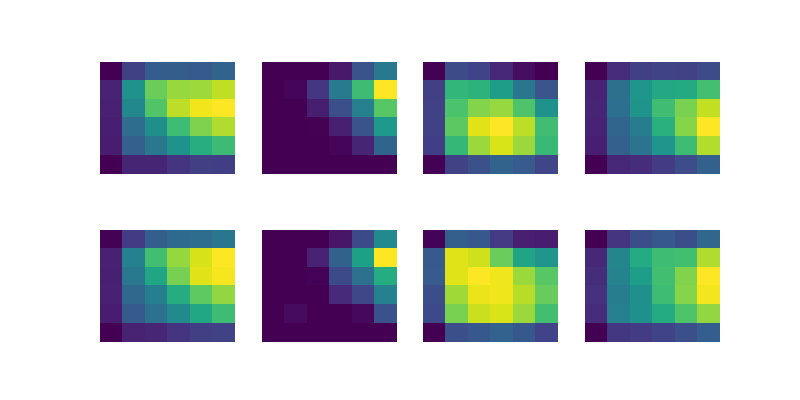

<IPython.core.display.Javascript object>


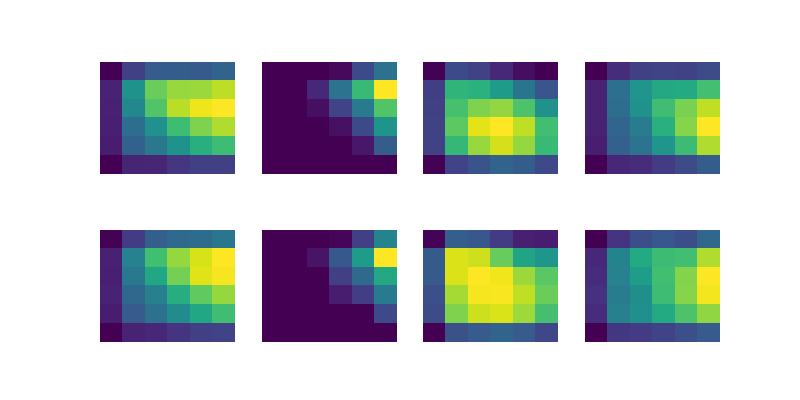

<IPython.core.display.Javascript object>


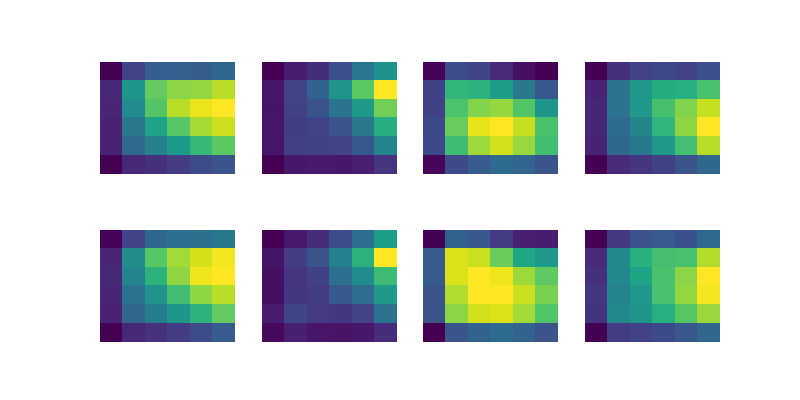

<IPython.core.display.Javascript object>


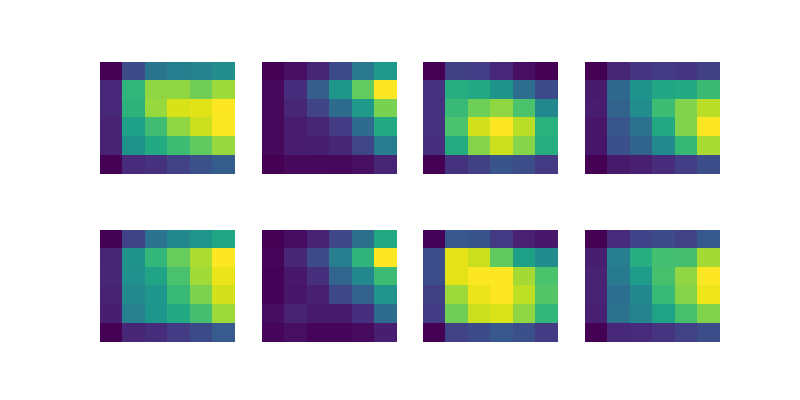

<IPython.core.display.Javascript object>


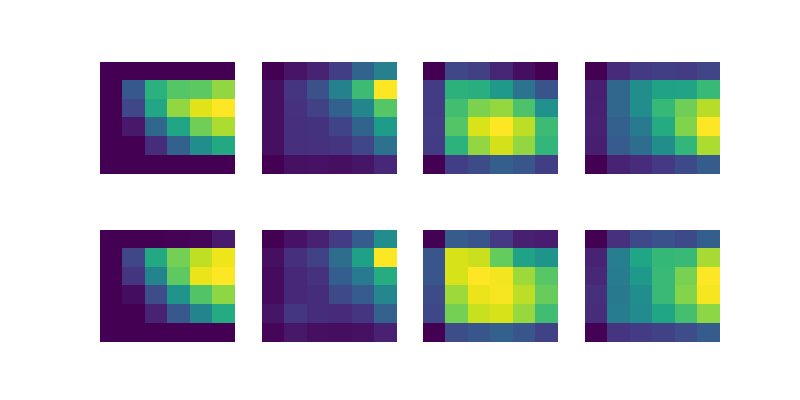

<IPython.core.display.Javascript object>


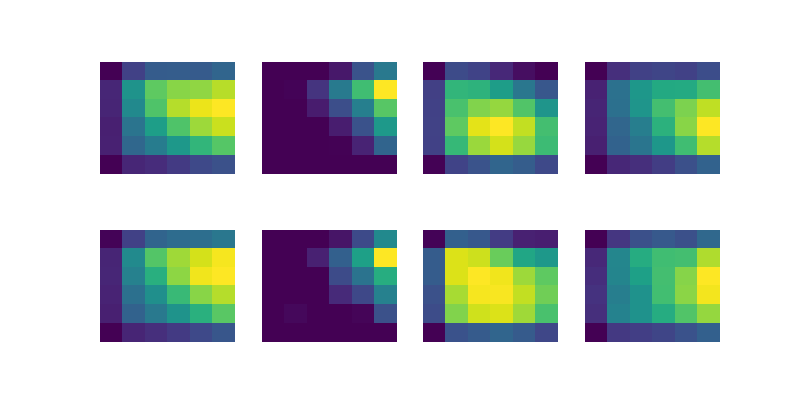

<IPython.core.display.Javascript object>


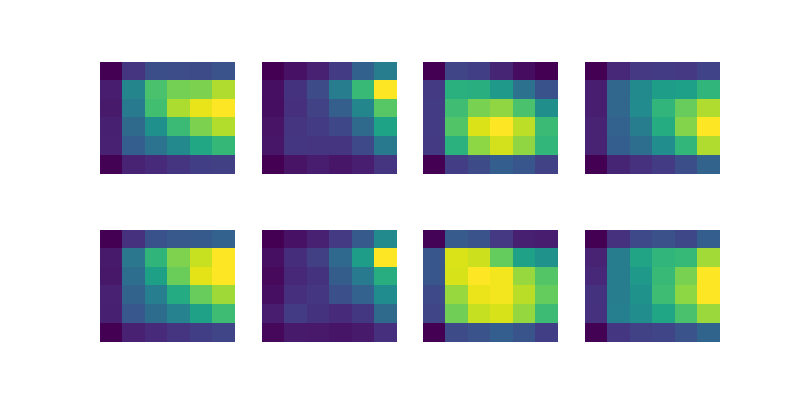

<IPython.core.display.Javascript object>


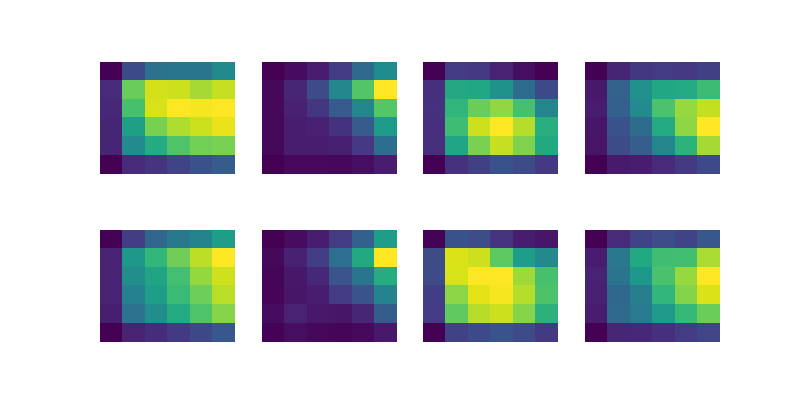

In [276]:
plt.close('all')
for iwt,weights_file in enumerate(weights_files):
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
    Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h = Wstar_dict['as_list']

    YY = compute_f_(Eta,Xi,s02)

    plt.figure(figsize=(4,2))
    ntypes = 4
    for itype in range(ntypes):
        plt.subplot(2,ntypes,itype+1)
        sca.show_size_contrast(YY[:,itype].reshape((6,6)),flipud=True)
        plt.axis('off')
        plt.subplot(2,ntypes,ntypes+itype+1)
        sca.show_size_contrast(YY[:,itype+8].reshape((6,6)),flipud=True)
        plt.axis('off')

<IPython.core.display.Javascript object>


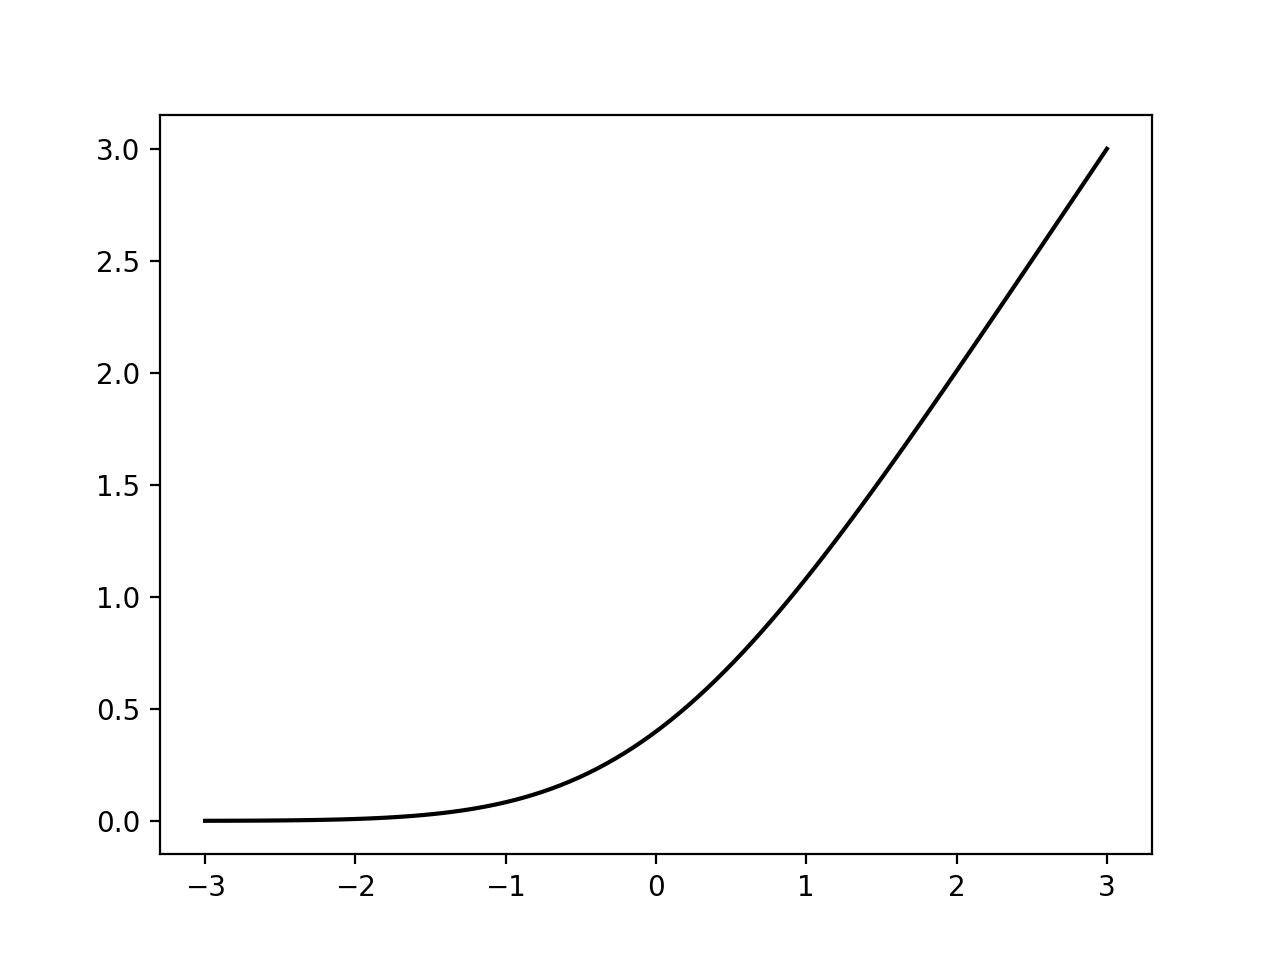

In [123]:
plt.figure()
x = np.linspace(-3,3,100)
plt.plot(x,calnet.utils.f_miller_troyer(x,1),c='k')
plt.savefig('figures/f_miller_troyer.eps')

<IPython.core.display.Javascript object>


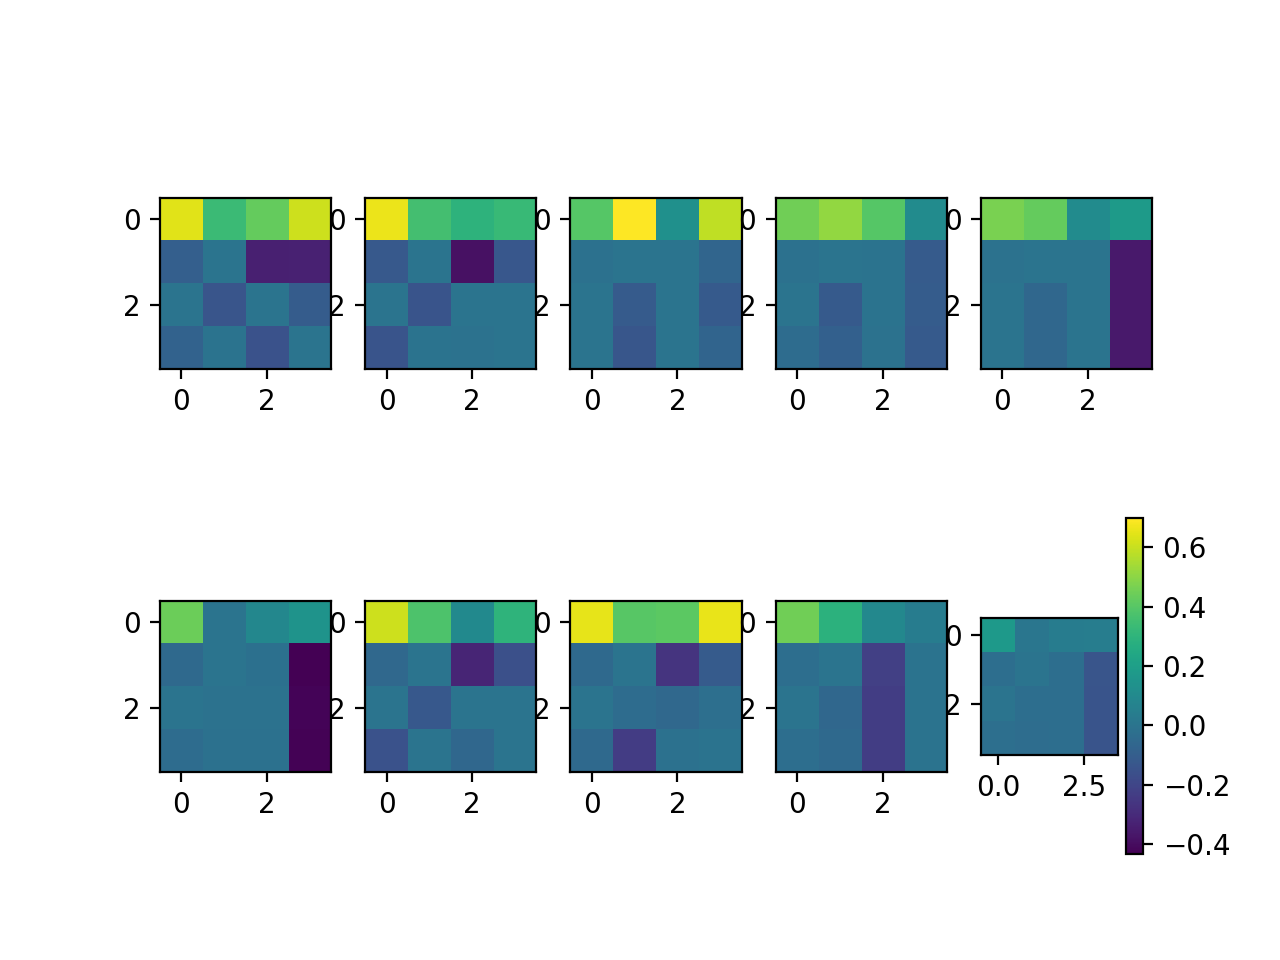

In [278]:
plt.figure()
for iwt in range(10):
    plt.subplot(2,5,iwt+1)
    plt.imshow(Wmys[iwt],vmin=Wmys.min(),vmax=Wmys.max())
plt.colorbar()

<IPython.core.display.Javascript object>


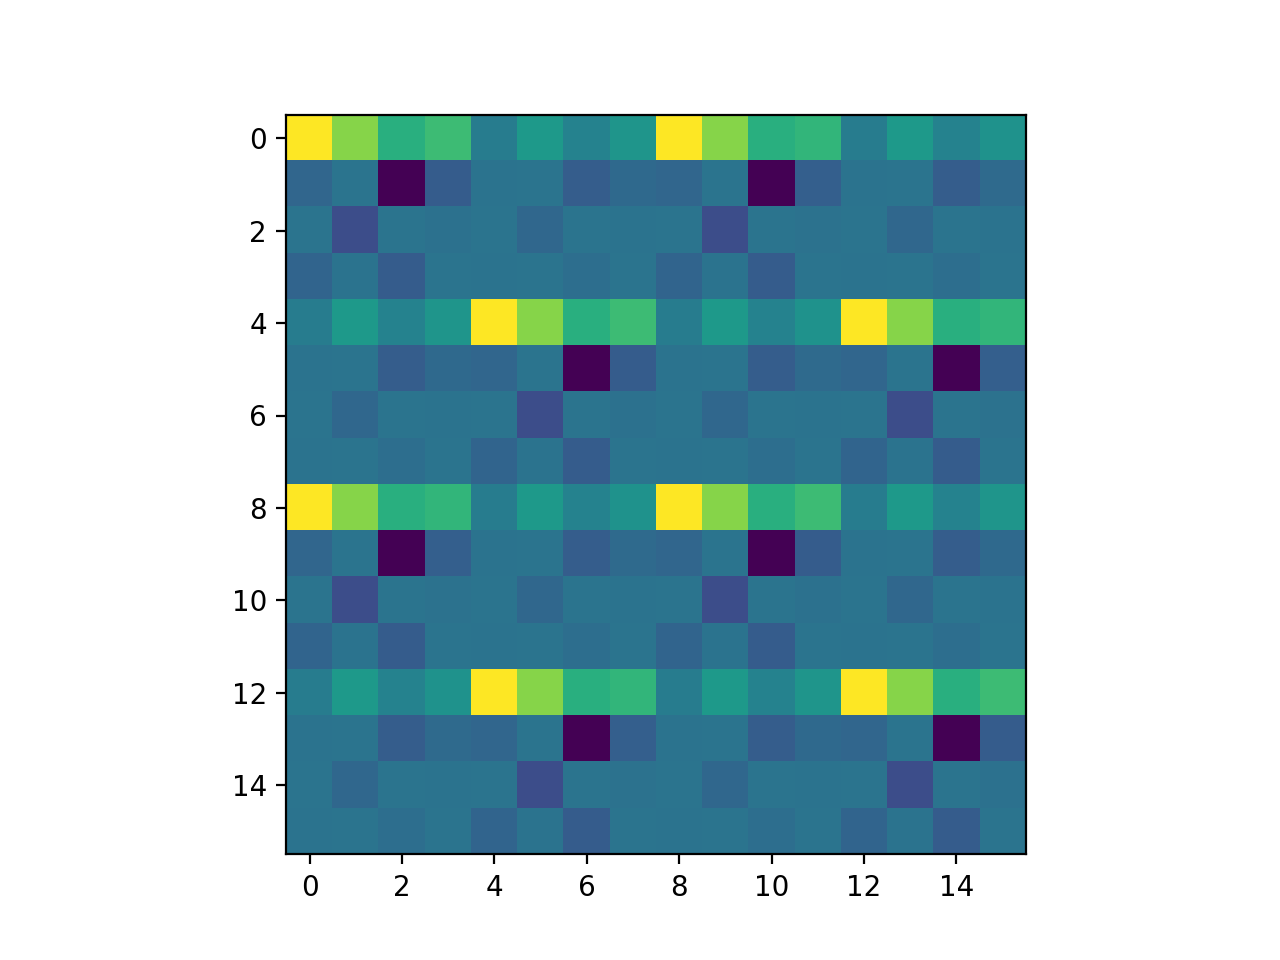

In [166]:
WWmy = calnet.utils.gen_Weight_k_kappa_t(Wmy,K,kappa,T)
plt.figure()
plt.imshow(WWmy)

In [279]:
basefold = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/calnet_data/'
subfold = 'weights_200712a/'
plots_fold = basefold + 'fit_graphics/' + subfold
ut.mkdir(plots_fold)
weights_fold = basefold + 'weights/' + subfold
weights_files = glob.glob(weights_fold+'*.npy')
weights_files.sort()
# weights_filenames = [s.split('/')[-1][:-4] for s in weights_files]


In [286]:
YYhat.shape

(30, 16)

<IPython.core.display.Javascript object>


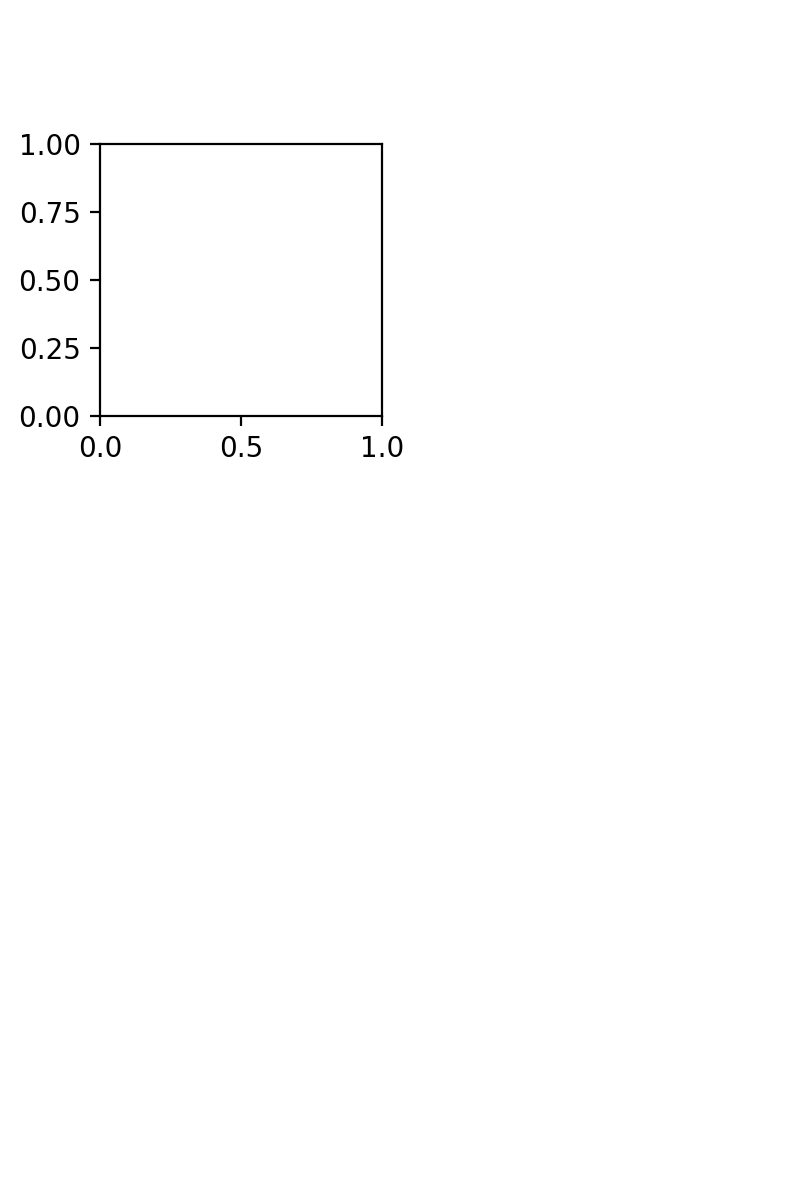

ValueError: x and y must be the same size

In [280]:
# trystars_i,trystars_j = [0],[0]
# itry = 0
# Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi,h = Wt[trystars_i[itry]][trystars_j[itry]]
# Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list']
# def gen_Weight(W,K,kappa):
#     WW0 = np.concatenate((W,W*K[np.newaxis,:]),axis=1)
#     WW1 = np.concatenate((W*K[np.newaxis,:]*kappa,W),axis=1)
#     WW = np.concatenate((WW0,WW1),axis=0)
#     return WW

def u_fn(XX,YY,Wx,Wy,k,kappa,T):
    WWx,WWy = [gen_Weight(W,k,kappa,T) for W in [Wx,Wy]]
    return u_fn_WW(XX,YY,WWx,WWy)# XX @ WWx + YY @ WWy

def u_fn_WW(XX,YY,WWx,WWy):
    return XX @ WWx + YY @ WWy

def colorful_scatter(a,b):
    for icelltype in range(ncelltypes-1):
        plt.scatter(a[:,icelltype],b[:,icelltype],s=10)

for weights_file in weights_files:
    plt.close('all')
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
    Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h = Wstar_dict['as_list']
    
    weights_filename = weights_file.split('/')[-1][:-4]

    XXhat = np.concatenate([np.concatenate(x,axis=1) for x in Xhat],axis=1)
    YYhat = np.concatenate([np.concatenate(x,axis=1) for x in Yhat],axis=1)
    YY = compute_f_(Eta,Xi,s02)
    Etastar = u_fn(XX,YY,Wmx,Wmy,K,kappa,T)
    Xistar = u_fn(XX,YY,Wsx,Wsy,K,kappa,T)
    YYstar = compute_f_(Etastar,Xistar,s02)
    nrows = 3
    ncols = 2
    plt.figure(1,figsize=(2*ncols,2*nrows))
    plt.subplot(nrows,ncols,1)
    colorful_scatter(YYhat,YY)
    plt.xlabel('Measured Y')
    plt.ylabel('Modeled Y')
    plt.plot((0,1),(0,1),c='k')
    plt.subplot(nrows,ncols,2)
    plt.scatter(XXhat,XX,s=10)
    plt.xlabel('Measured X')
    plt.ylabel('Modeled X')
    plt.plot((0,1),(0,1),c='k')
    plt.subplot(nrows,ncols,3)
    colorful_scatter(Eta,Etastar)
    plt.xlabel('Modeled input current')
    plt.ylabel('Self-consistent input current')
    lim = np.max(np.abs(Etastar))
    plt.plot((-lim,lim),(-lim,lim),c='k')
    plt.subplot(nrows,ncols,4)
    colorful_scatter(Xi,Xistar)
    plt.xlabel('Modeled input current var')
    plt.ylabel('Self-consistent input current var')
    lim = np.max(np.abs(Xistar))
    plt.plot((-lim,lim),(-lim,lim),c='k')
    plt.subplot(nrows,ncols,5)
    colorful_scatter(YY,YYstar)
    plt.xlabel('Modeled Y')
    plt.ylabel('Self-consistent Y')
    plt.plot((0,1),(0,1),c='k')
    plt.subplot(nrows,ncols,6)
    colorful_scatter(YYhat,YYstar)
    plt.xlabel('Measured Y')
    plt.ylabel('Self-consistent Y')
    plt.plot((0,1),(0,1),c='k')
    plt.tight_layout()
    plt.savefig(plots_fold+weights_filename+'.jpg',dpi=300)

In [253]:
nfiles = len(weights_files)
Ts = np.zeros((nfiles,4))
Ks = np.zeros((nfiles,4))
Wmys = np.zeros((nfiles,4,4))
couplings = np.zeros((nfiles,30,16,16))
for iwt,weights_file in enumerate(weights_files):
    Wstar_dict = np.load(weights_file,allow_pickle=True)[()]
    Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi,h = Wstar_dict['as_list']
    Ts[iwt] = T
    Ks[iwt] = K
    Wmys[iwt] = Wmy
    for istim in range(30):
        Phi = np.diag(calnet.utils.fprime_miller_troyer(Eta[istim],Xi[istim]**2+1))
        couplings[iwt,istim] = Phi @ np.linalg.inv(np.eye(16) - WWmy @ Phi)

In [ ]:
np.save('weights_from_opto_200610.npy',allow_pickle=True)[()]

In [291]:
K

array([0.17568437, 0.54221303, 0.80421874, 0.77858445])

In [166]:
# dh Phi + dY W Phi = dY
# dh + dY W = dY inv(Phi)
# dY W = dY inv(Phi) - dh
# W = pinv(dY) (dY inv(Phi) - dh)

<IPython.core.display.Javascript object>


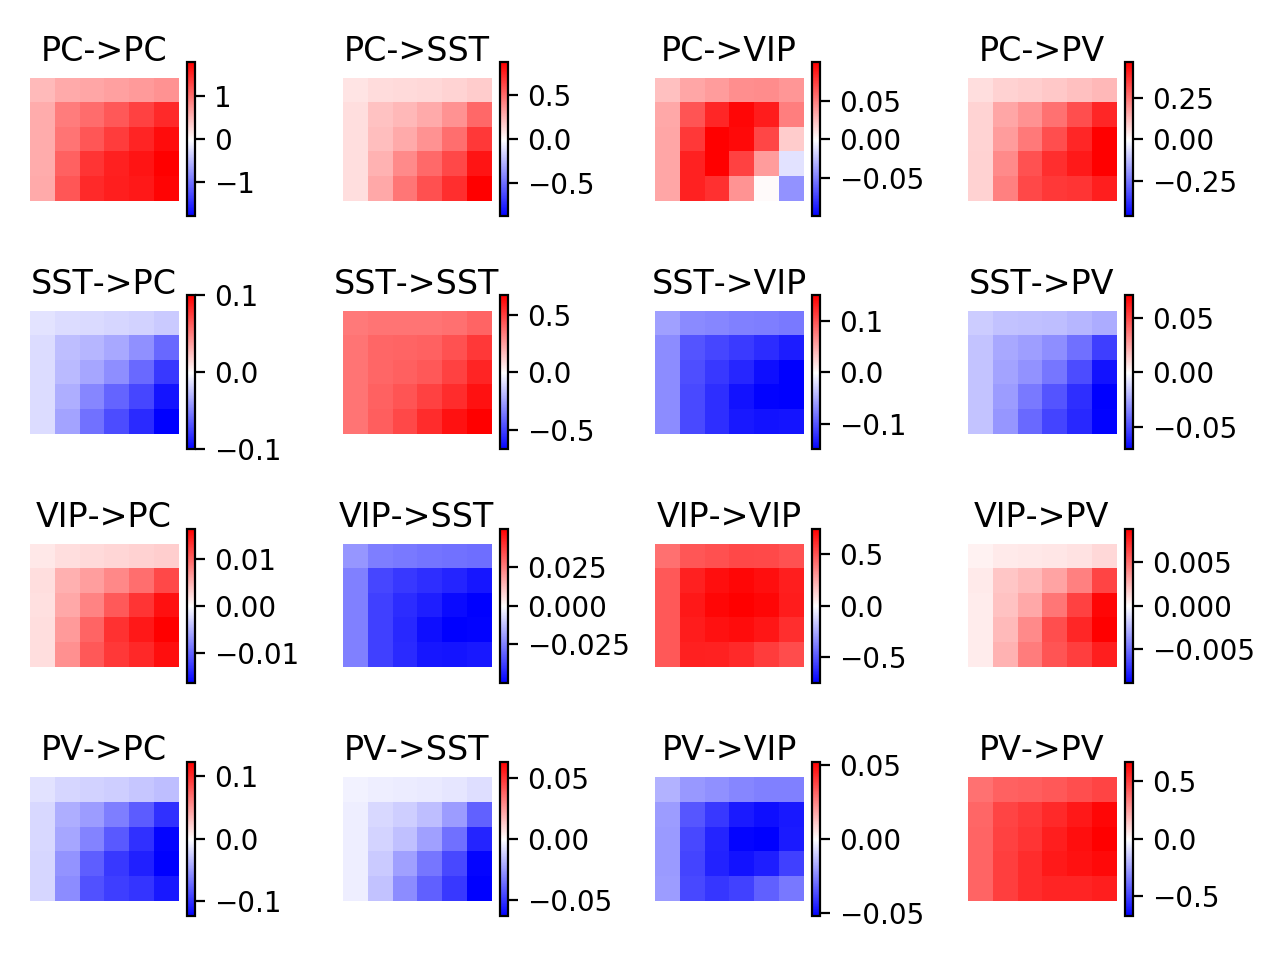

In [248]:
lbls = ['PC','SST','VIP','PV']
plt.figure()
for i1 in range(4):
    for i2 in range(4):
        plt.subplot(4,4,4*i1+i2+1)
        data = np.nanmean(couplings,0)[:,i1,i2].reshape((5,6))
        plt.imshow(data,cmap='bwr',vmin=-np.abs(data).max(),vmax=np.abs(data).max())
        plt.colorbar()
        plt.axis('off')
        plt.title('%s->%s'%(lbls[i1],lbls[i2]))
plt.tight_layout()

<IPython.core.display.Javascript object>


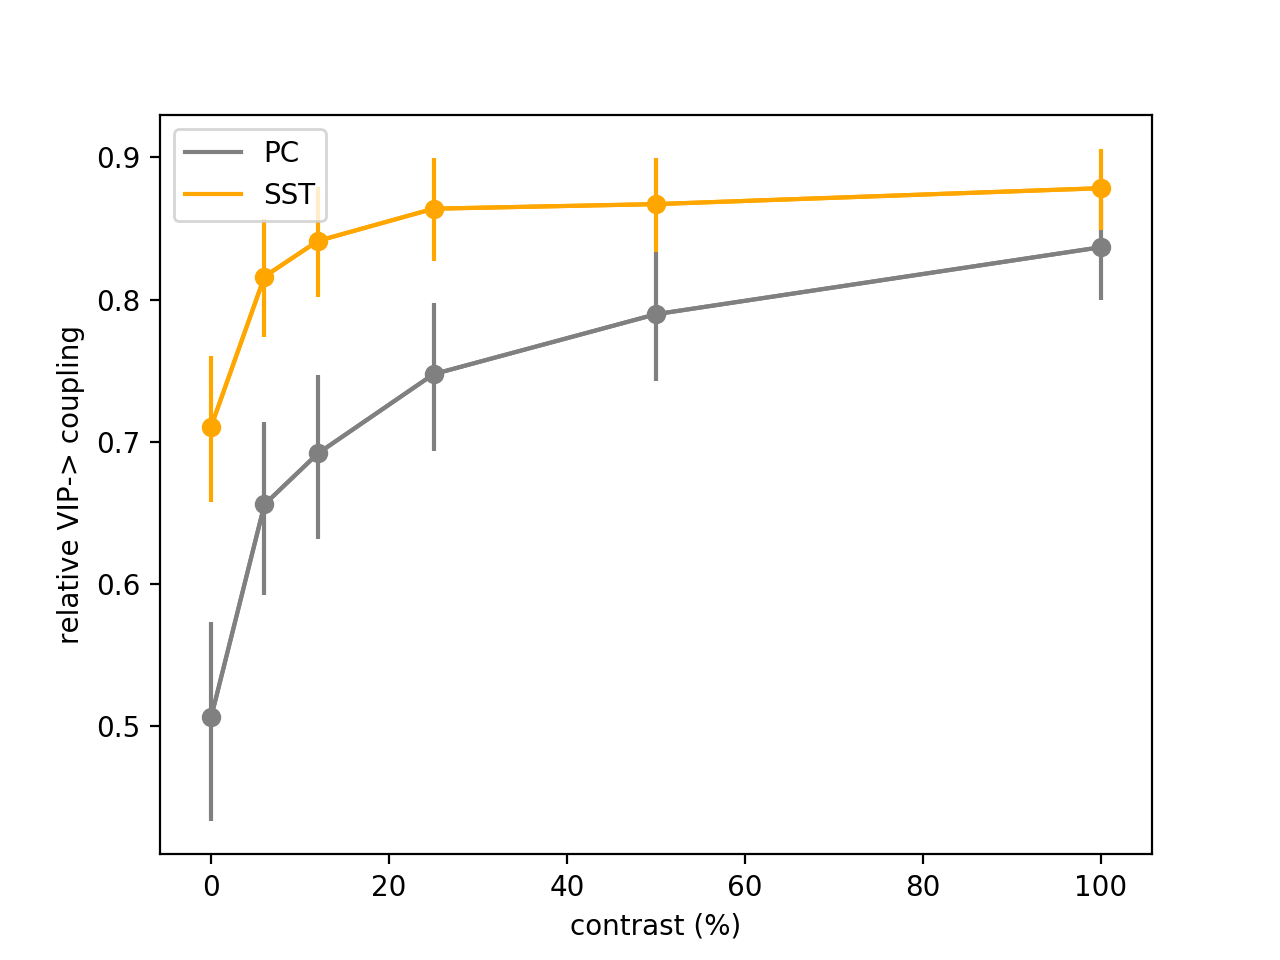

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.8025873364785792
0.850621189101999


In [259]:
plt.figure()
isize = 0
ucontrast = np.array((0,6,12,25,50,100))
colors = [np.array((0.5,0.5,0.5)),np.array((1,0.65,0)),np.array((0,0,1))]
for target,color in zip([0,1],colors[:2]):
    vip_target = couplings[:,:,2,target].reshape((-1,5,6))
    ut.plot_bootstrapped_errorbars_hillel(ucontrast,np.abs(vip_target[:,isize])[:,np.newaxis]/np.abs(vip_target[:,isize]).max(),colors=color[np.newaxis],pct=(16,84))
plt.xlabel('contrast (%)')
plt.ylabel('relative VIP-> coupling')
plt.legend(['PC','SST'])
plt.savefig('figures/contrast_dependent_vip_pc_coupling.eps')

<IPython.core.display.Javascript object>


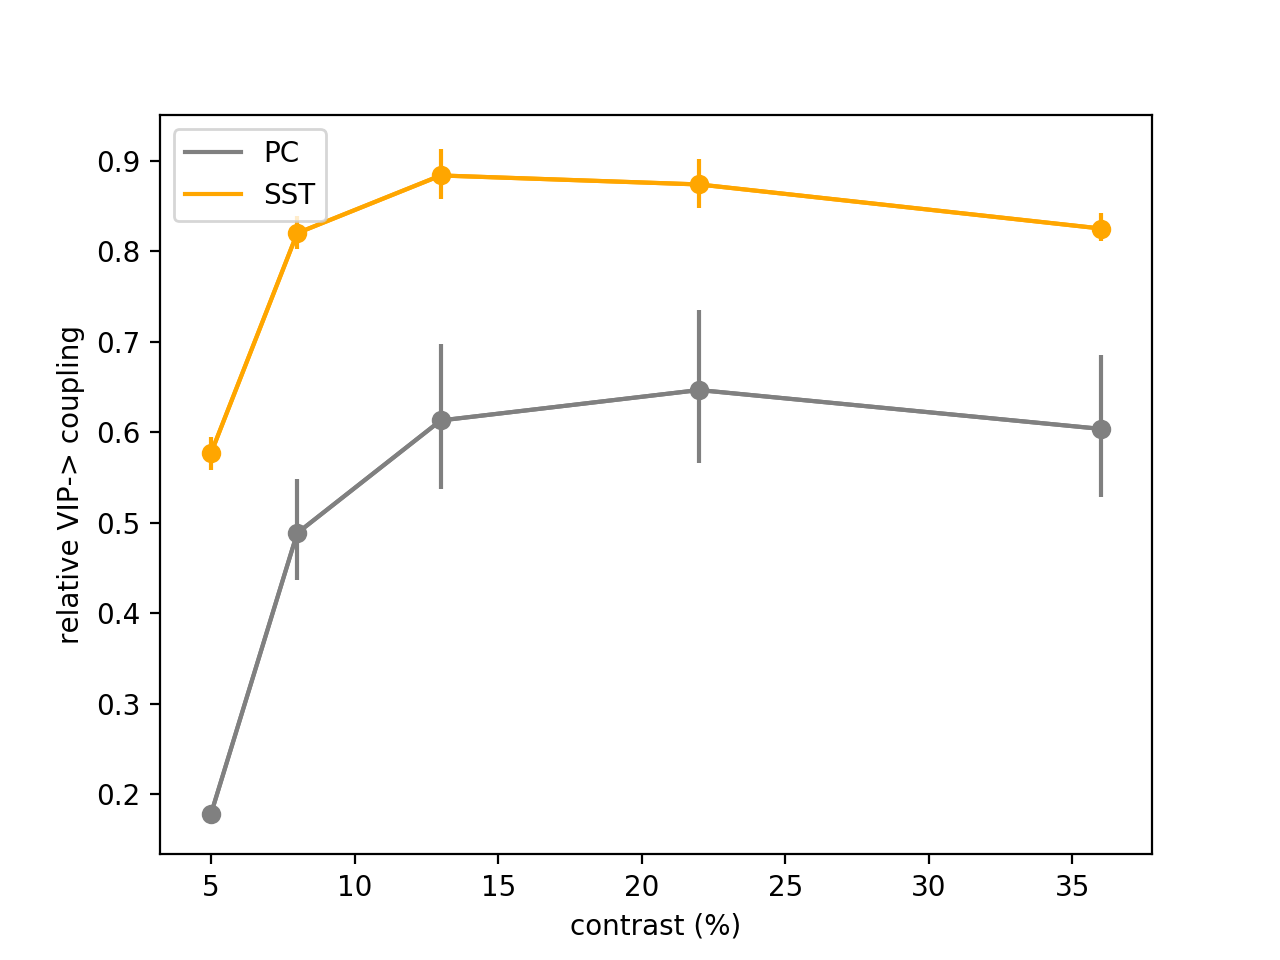

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0.5578604152474462
0.8544172636230318


In [262]:
plt.figure()
isize = 0
ucontrast = np.array((0,6,12,25,50,100))
usize = np.array((5,8,13,22,36))
colors = [np.array((0.5,0.5,0.5)),np.array((1,0.65,0)),np.array((0,0,1))]
for target,color in zip([0,1],colors[:2]):
    vip_target = couplings[:,:,2,target].reshape((-1,5,6))
    ut.plot_bootstrapped_errorbars_hillel(usize,np.abs(vip_target[:,:,-1])[:,np.newaxis]/np.abs(vip_target[:,:,-1]).max(),colors=color[np.newaxis],pct=(16,84))
plt.xlabel('contrast (%)')
plt.ylabel('relative VIP-> coupling')
plt.legend(['PC','SST'])
# plt.savefig('figures/contrast_dependent_vip_pc_coupling.eps')

<IPython.core.display.Javascript object>


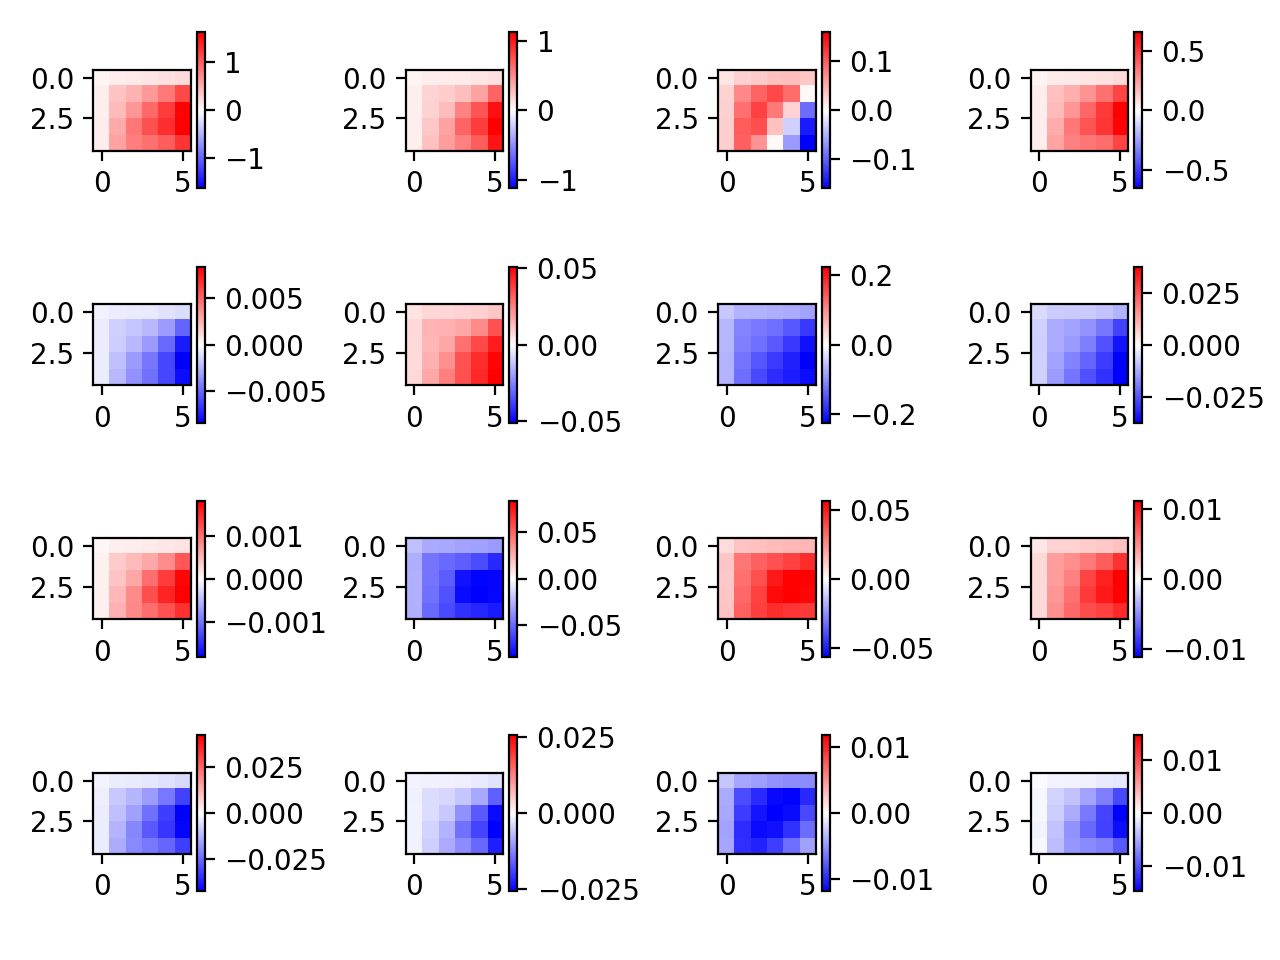

In [171]:
plt.figure()
for i1 in range(4):
    for i2 in range(4):
        plt.subplot(4,4,4*i1+i2+1)
        data = np.nanmean(couplings,0)[:,i1,8+i2].reshape((5,6))
        plt.imshow(data,cmap='bwr',vmin=-np.abs(data).max(),vmax=np.abs(data).max())
        plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


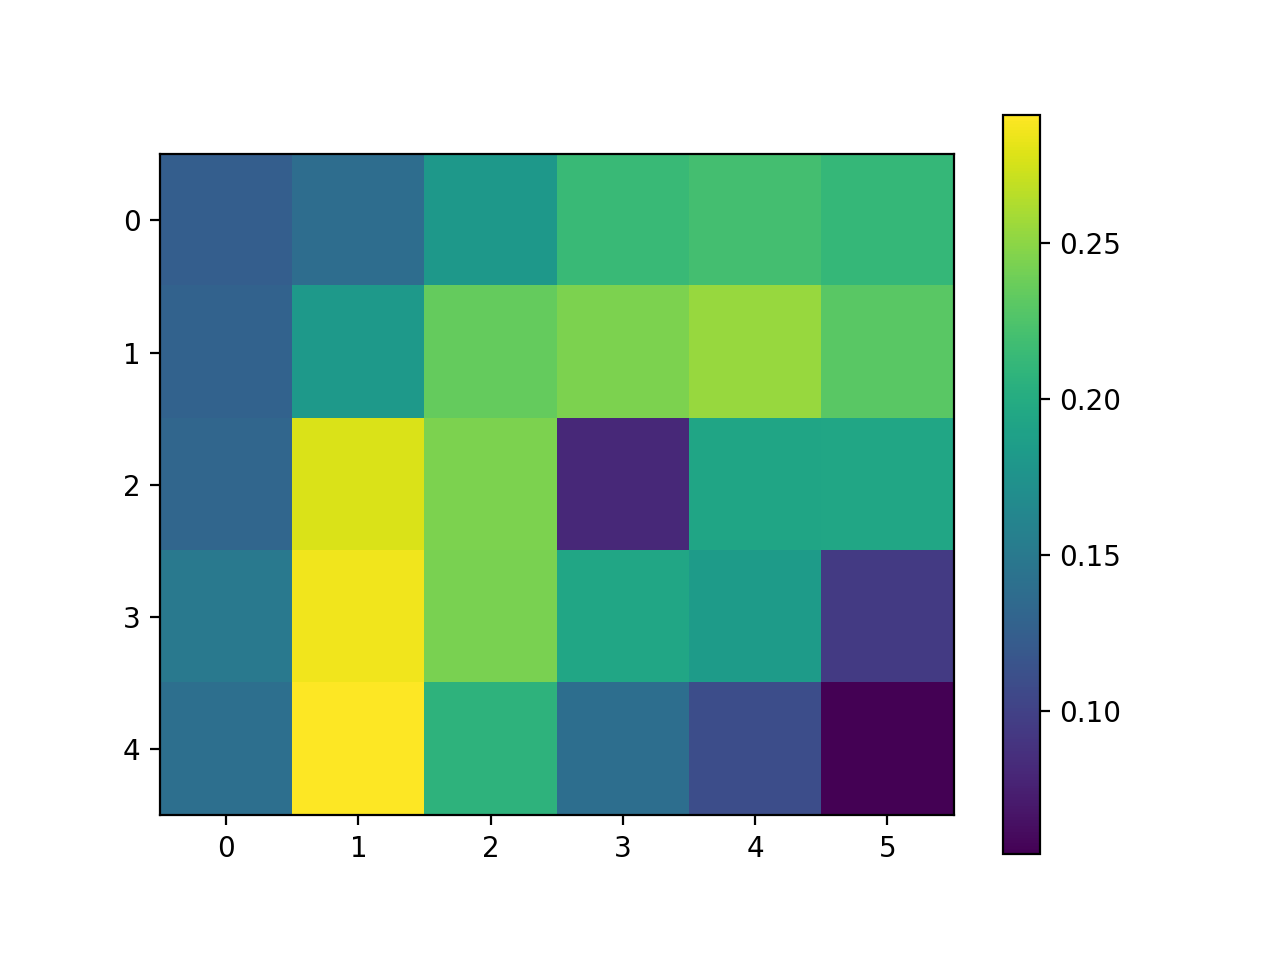

In [172]:
offset = 8
plt.figure()
plt.imshow((coupling[:,offset+0,0]+coupling[:,offset+3,0]).reshape((5,6)))
plt.colorbar()

In [161]:
Phi = calnet.utils.fprime_miller_troyer(Eta,Xi**2+1)
dH = np.zeros_like(Phi)
dH[:,np.arange(2,16,4)] = 1
Wlsq = np.linalg.pinv(dYY) @ (dYY/Phi - h*dH)

<IPython.core.display.Javascript object>


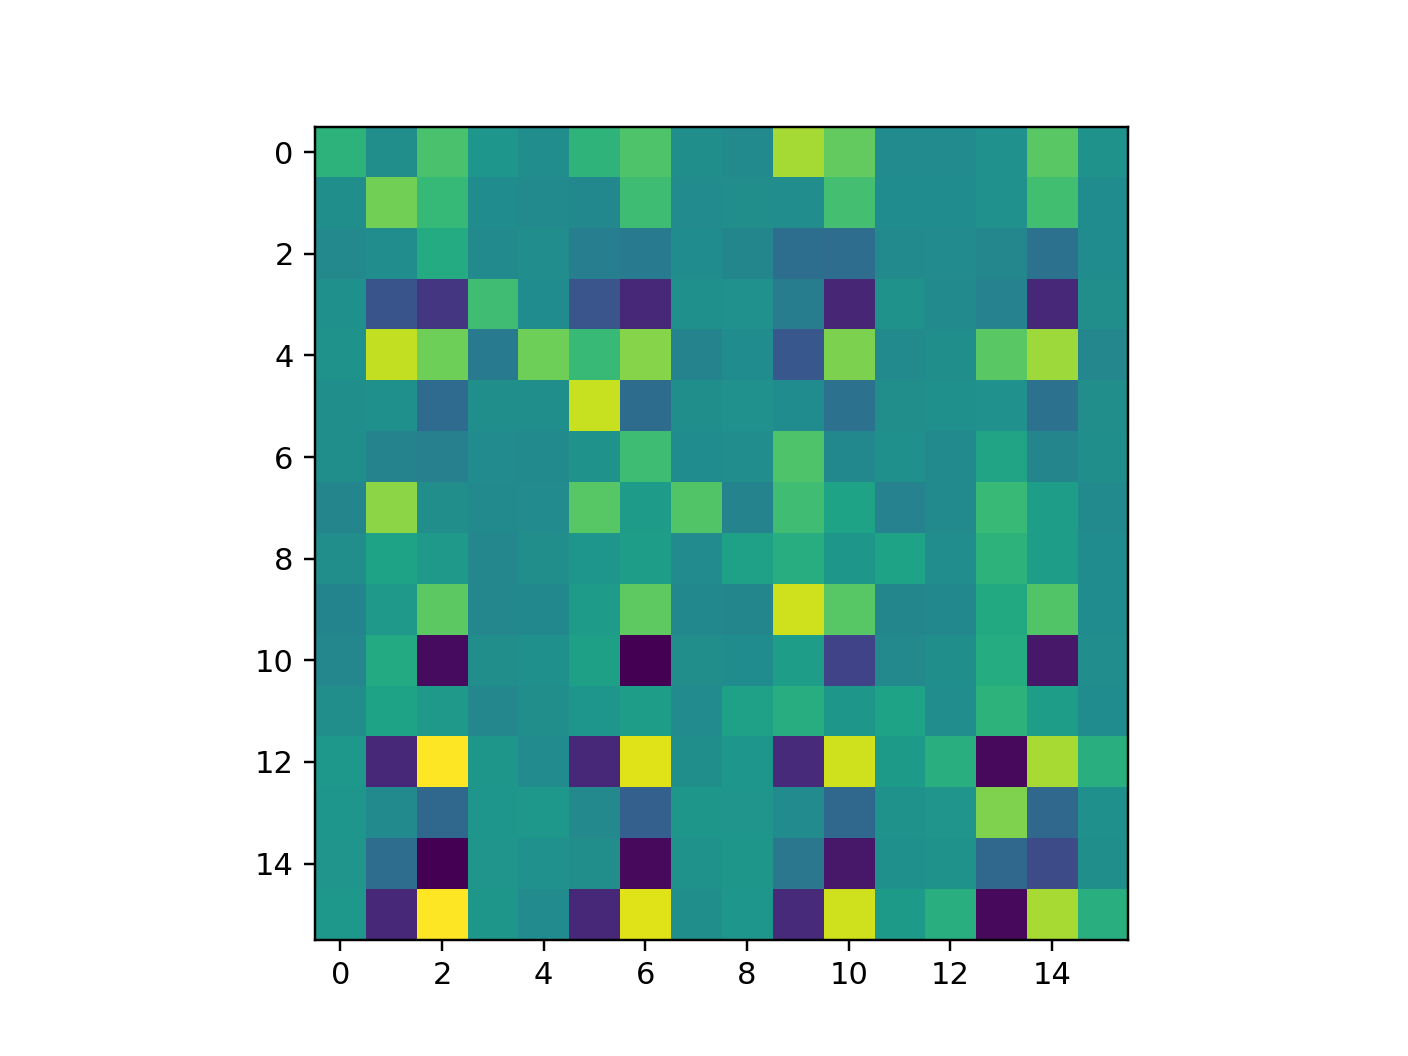

In [162]:
plt.figure()
plt.imshow(Wlsq)

<IPython.core.display.Javascript object>


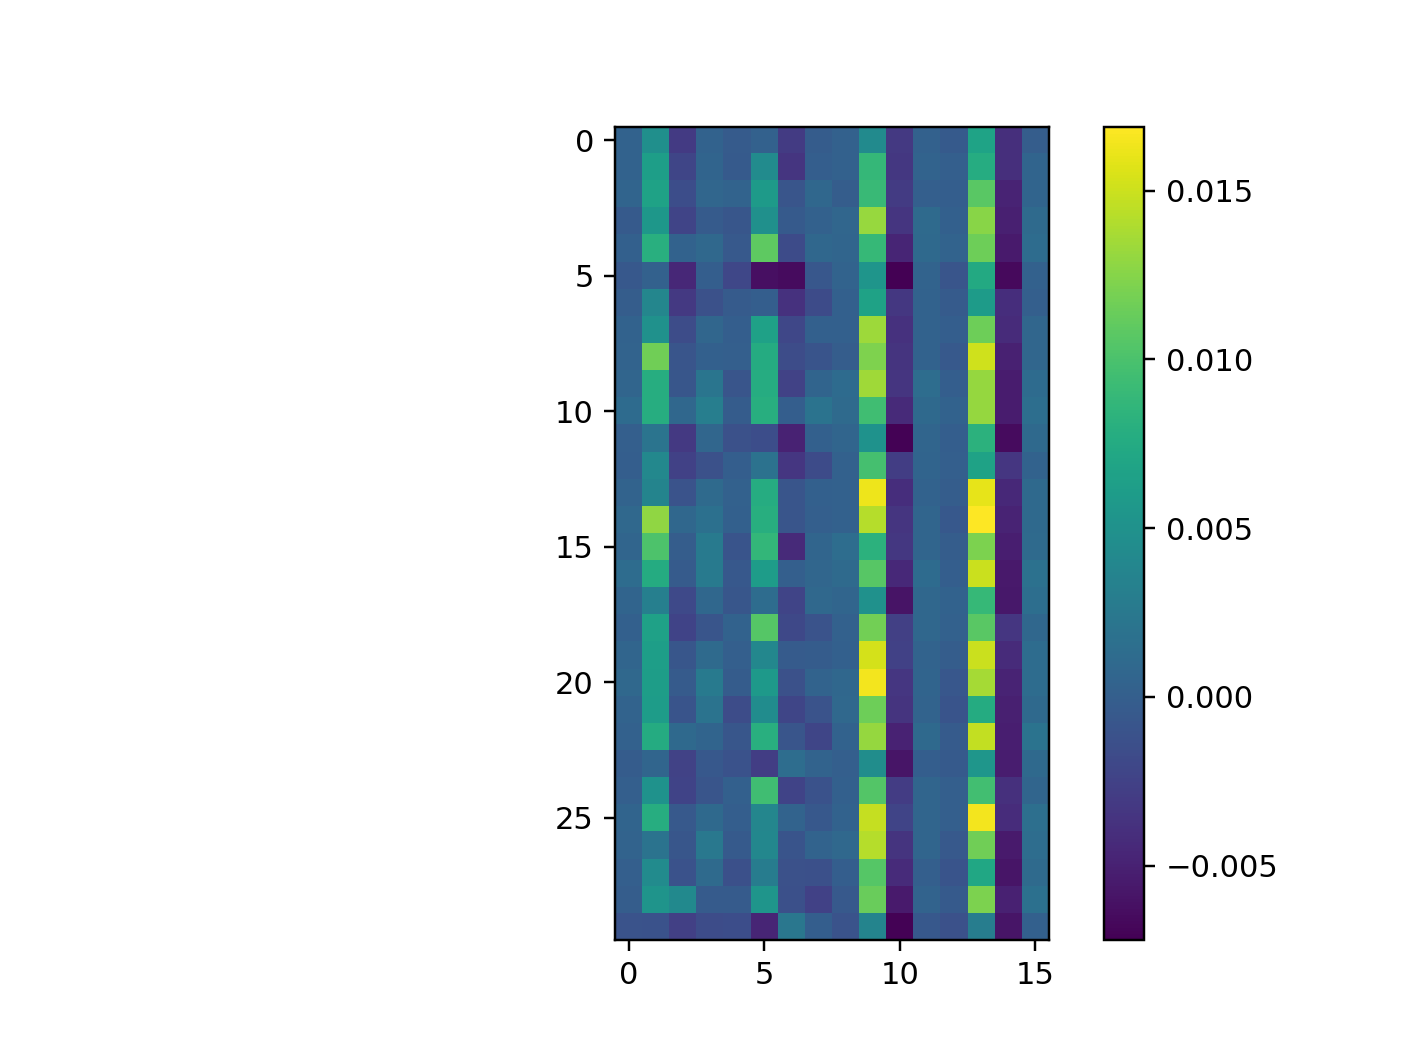

In [151]:
plt.figure()
difference = np.zeros((30,16))
for istim in range(30):
    Phi = np.diag(calnet.utils.fprime_miller_troyer(Eta[istim],Xi[istim]**2+1))
    difference[istim] = dYY[istim] @ (np.eye(16) - WWmy @ Phi) @ np.linalg.inv(Phi)
plt.imshow(difference)
# plt.imshow(YY)
plt.colorbar()
#,vmin=-0.01,vmax=0)

<IPython.core.display.Javascript object>


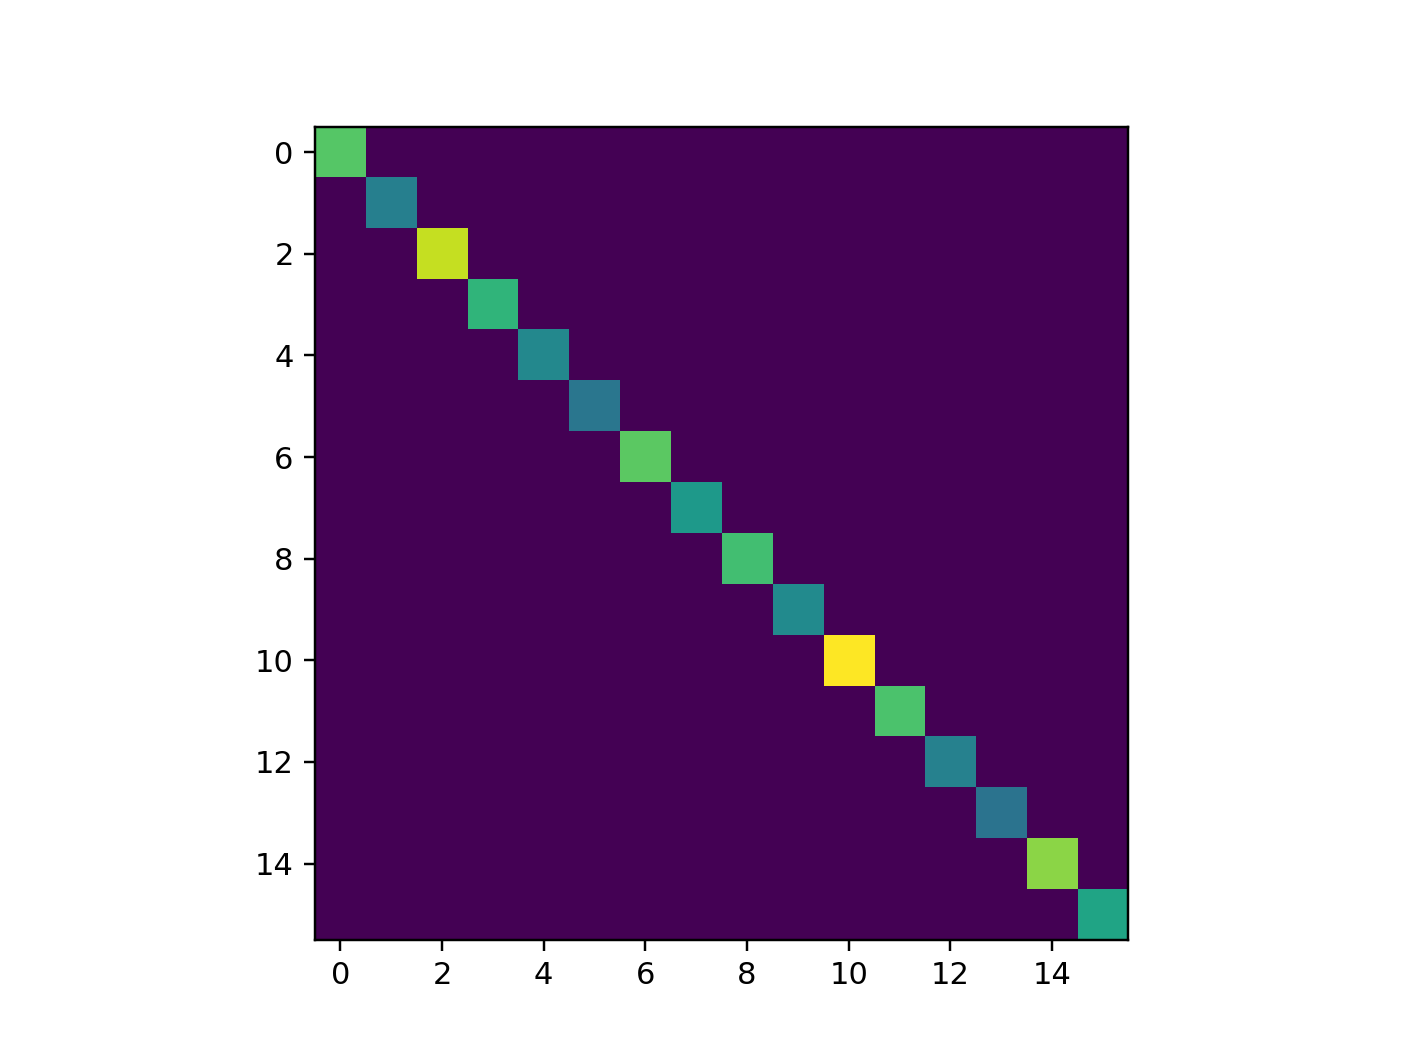

In [140]:
plt.figure()
plt.imshow(Phi)

<IPython.core.display.Javascript object>


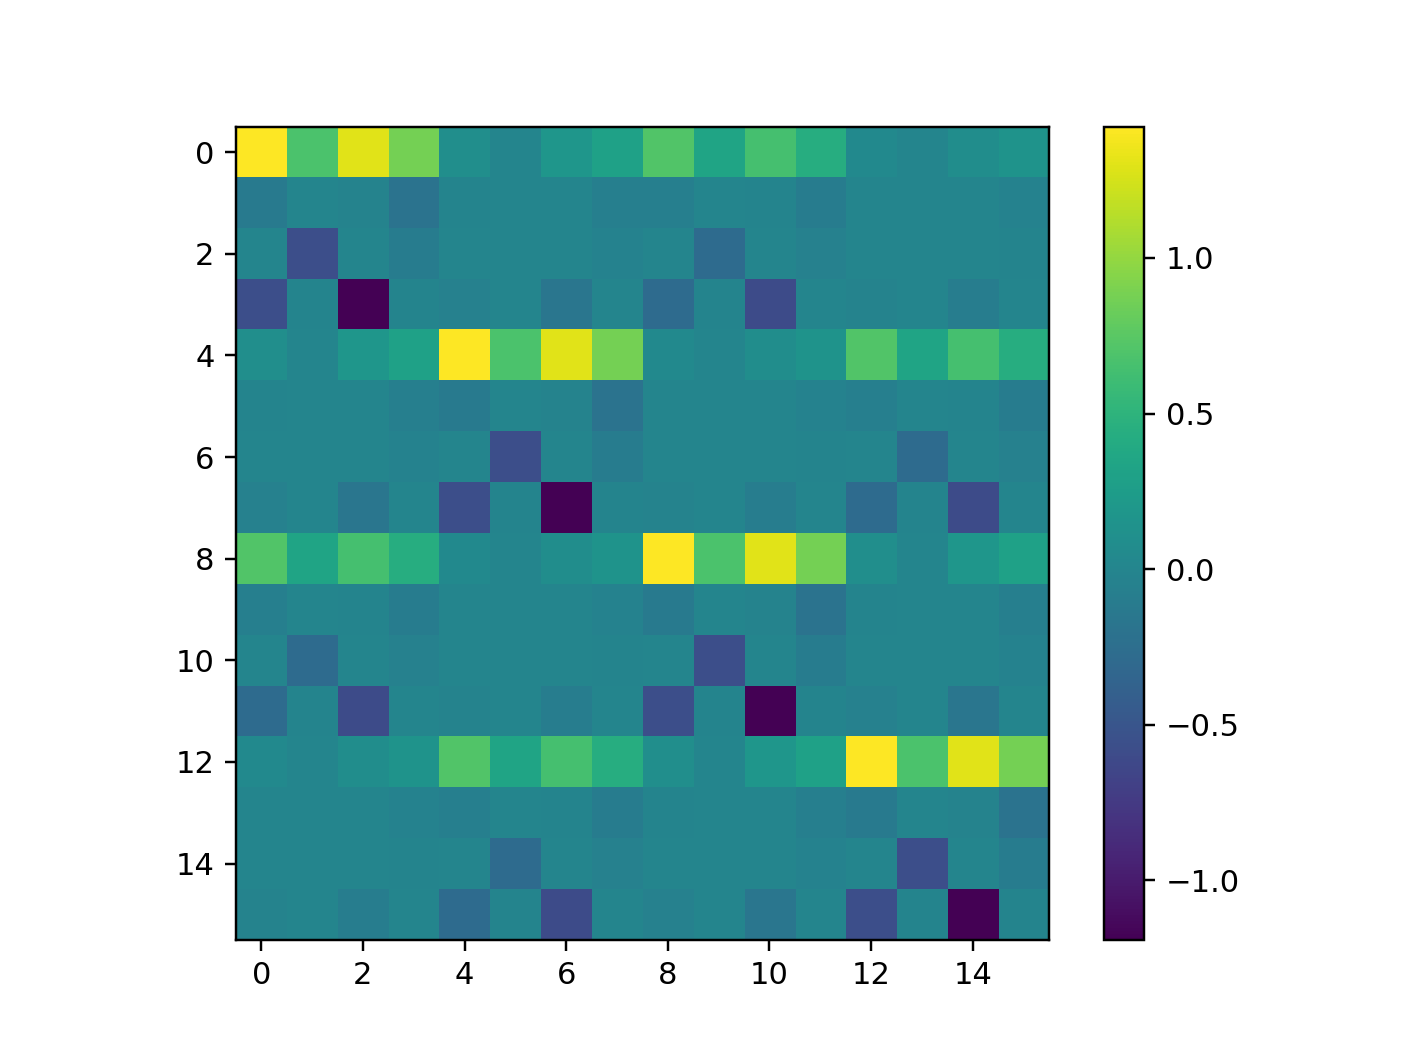

In [133]:
plt.figure()
plt.imshow(WWmy)
plt.colorbar()

<IPython.core.display.Javascript object>


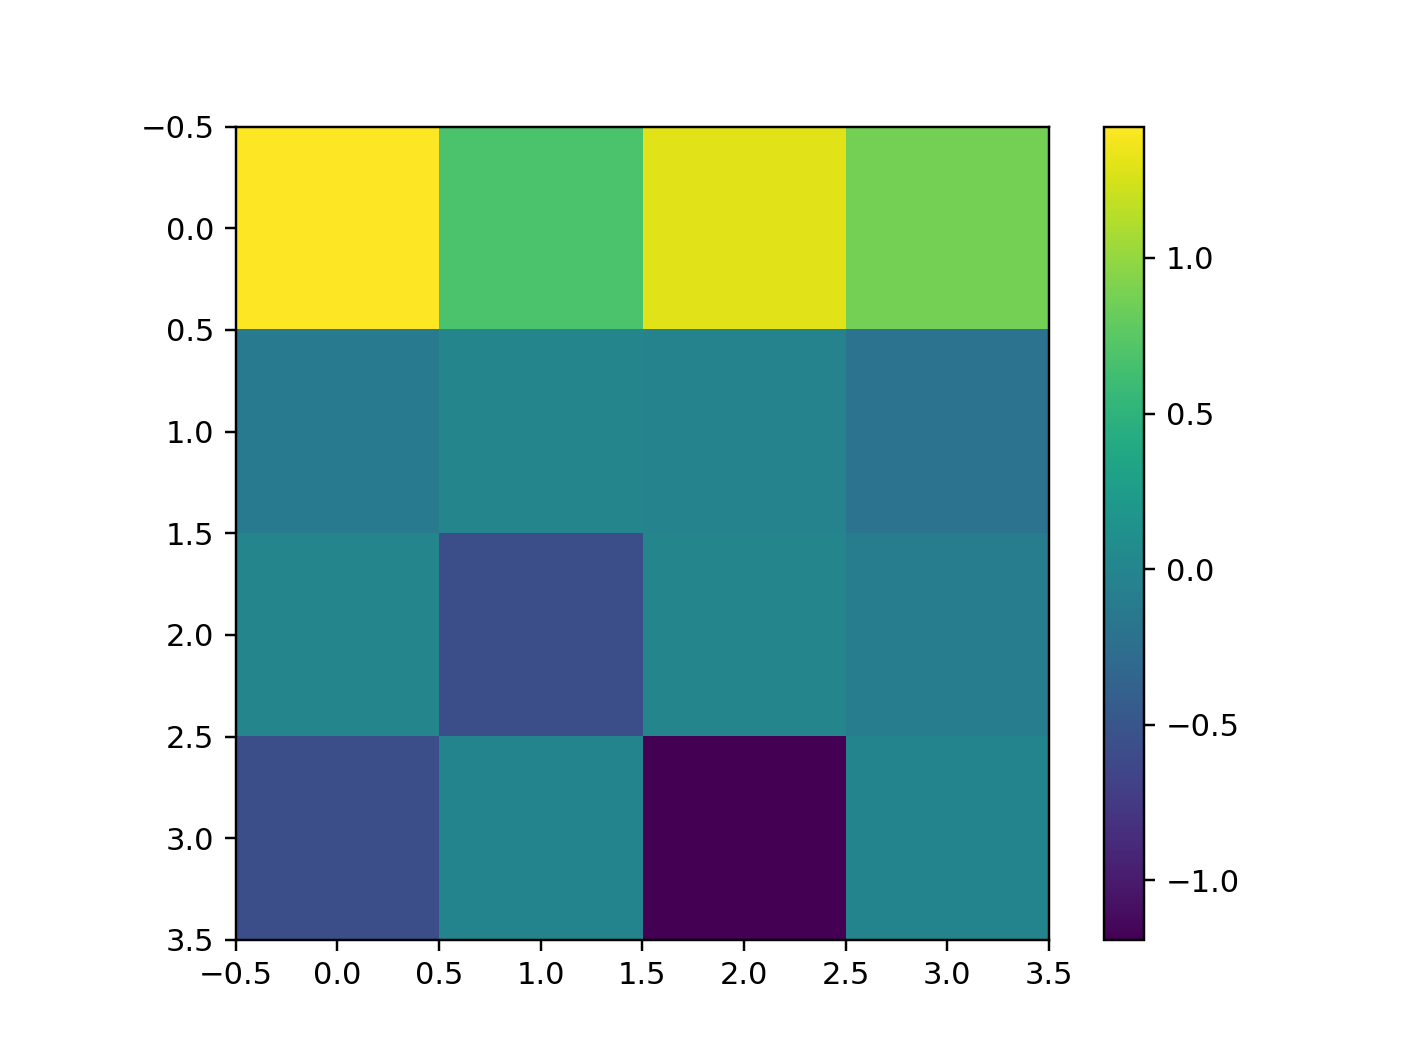

In [135]:
plt.figure()
plt.imshow(Wmy)
plt.colorbar()

In [120]:
Yhat[0][0].shape

(30, 4)

In [121]:
drH,prH = np.linalg.eig(hess)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [122]:
compute_fprime_m_(Eta,Xi,s02)

array([[-2.93938946e-02,  2.75369280e-02,  9.08498007e-03,
         3.72153299e-03, -2.10674481e-02,  1.67982821e-03,
         4.71064945e-02,  4.35677928e-03, -4.49214988e-02,
        -5.89115025e-03, -6.39171088e-02,  5.31021460e-03,
        -1.65078591e-02, -3.87478400e-03,  4.57578558e-02,
         4.62755360e-03],
       [-2.22999881e-02,  3.03194114e-02, -7.02082757e-03,
         3.46448440e-03, -1.67515155e-02,  4.04586197e-03,
         4.82774184e-02,  3.08535500e-03, -4.42141691e-02,
        -4.10018318e-02, -6.27938658e-02,  6.16927104e-03,
        -1.96755697e-02, -9.60253163e-04,  4.62127404e-02,
         3.12653769e-03],
       [-1.05809605e-02,  3.65528054e-02, -4.78787391e-02,
         2.50561938e-03, -9.41529219e-03,  9.79845890e-03,
         4.68881849e-02,  1.96486279e-03, -2.97966770e-02,
         2.24333286e-03, -1.17349919e-01,  4.29500581e-03,
        -9.71788062e-03,  4.75992645e-03,  4.29238109e-02,
         2.20132829e-03],
       [-2.52148442e-02,  3.82061055e

In [103]:
# nH = drH.shape[0]
hessWy = np.zeros((nQ**2,nQ**2))
blankWlist = parse_W(np.zeros(nH,))
blankWlist[1][:] = 1
allhot = unparse_W(*blankWlist)
Wy_entries = slice(np.where(allhot)[0][0],np.where(allhot)[0][-1]+1)
hessWy = hess[Wy_entries,Wy_entries]
gradWy = gr[Wy_entries]
drH,prH = np.linalg.eig(hessWy)
plt.figure()
for iieig,ieig in enumerate(np.arange(16)):
    plt.subplot(4,4,iieig+1)
    plt.imshow(prH[:,ieig].reshape((nQ,nQ))*np.sign(prH[:,ieig].mean()),vmin=-0.6,vmax=0.6)
plt.figure()
for ieig in np.arange(-1,-5,-1):
    x = np.linspace(-1,1,100)
    y = x*(gradWy @ prH[:,ieig]) + 0.5*x**2*(prH[:,ieig] @ hessWy @ prH[:,ieig])
    plt.plot(x,y)

ValueError: too many values to unpack (expected 12)

In [46]:
hessW = np.zeros((nP*nQ+nQ**2,nP*nQ+nQ**2))
blankWlist = parse_W(np.zeros(nH,))
blankWlist[0][:] = 1
blankWlist[1][:] = 1
allhot = unparse_W(*blankWlist)
W_entries = slice(np.where(allhot)[0][0],np.where(allhot)[0][-1]+1)
hessW = hess[W_entries,W_entries]
gradW = gr[W_entries]
drHW,prHW = np.linalg.eig(hessW)

plt.figure()
for iieig,ieig in enumerate(np.arange(nP*nQ+nQ**2)):
    plt.subplot(6,4,iieig+1)
    these_wts = np.real(prHW[:,ieig])
    these_wx = these_wts[:nP*nQ].reshape((nP,nQ))
    these_wy = these_wts[nP*nQ:].reshape((nQ,nQ))
    these_w = np.concatenate((these_wy,these_wx),axis=0)
    plt.imshow(these_w*np.sign(these_w.mean()),vmin=-0.6,vmax=0.6)
plt.figure()
for ieig in np.arange(-1,-5,-1):
    x = np.linspace(-0.5,0.5,100)
    y = x*(gradW @ prHW[:,ieig]) + 0.5*x**2*(prHW[:,ieig] @ hessW @ prHW[:,ieig])
    plt.plot(x,y)

NameError: name 'nH' is not defined

<IPython.core.display.Javascript object>


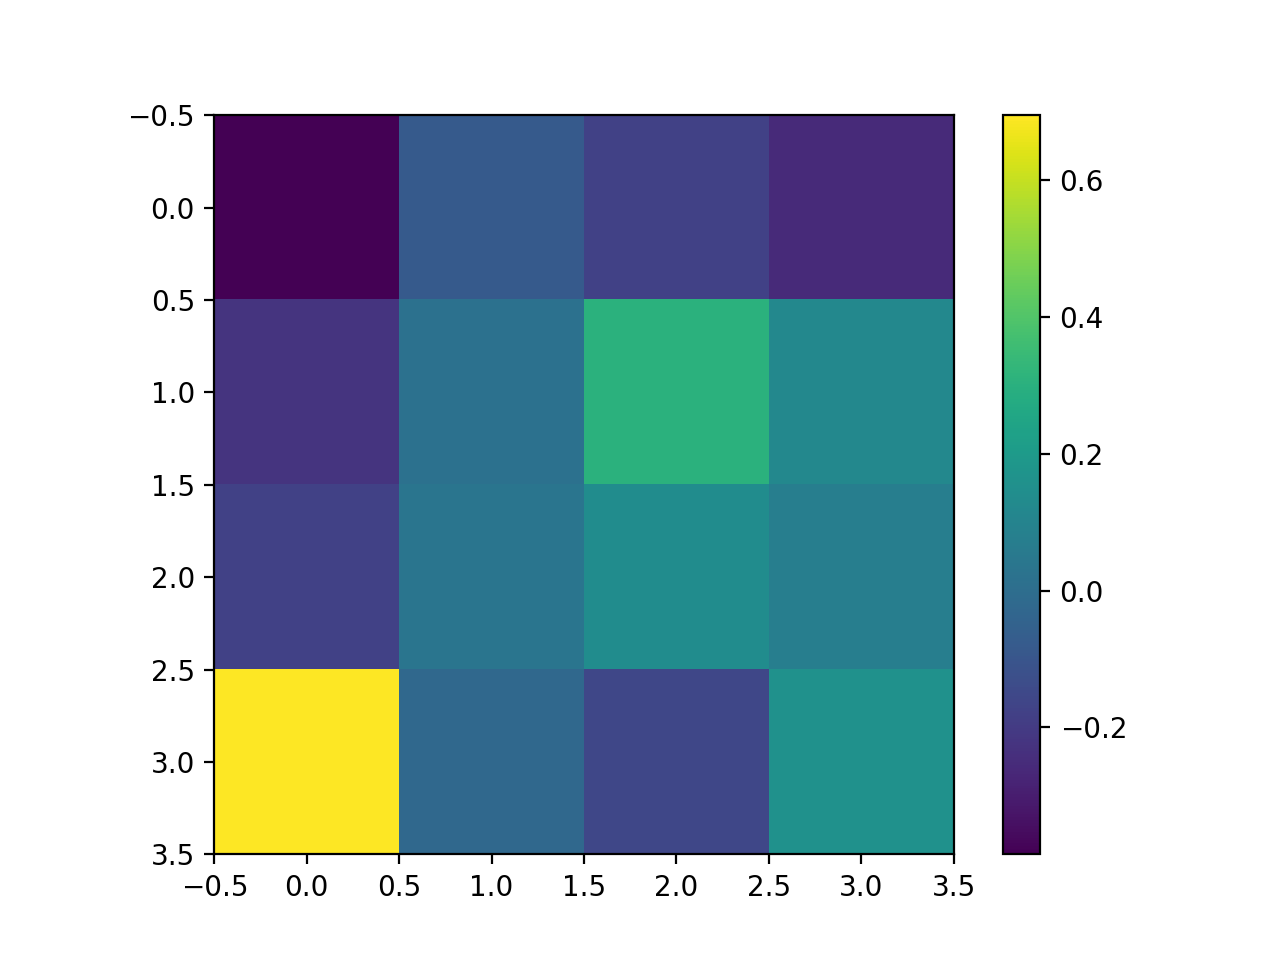

In [2079]:
plt.figure()
plt.imshow(prH[:,-3].reshape((nQ,nQ)))
plt.colorbar()

<IPython.core.display.Javascript object>


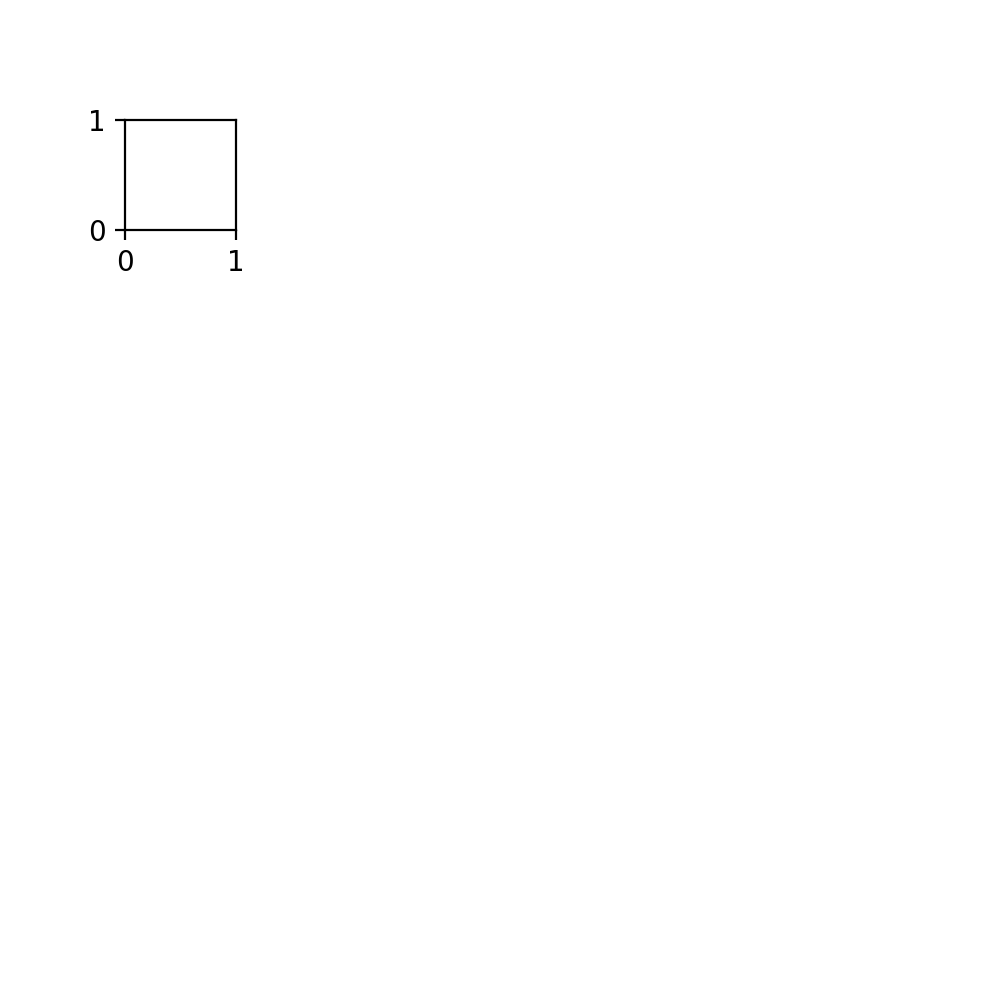

ValueError: cannot reshape array of size 8 into shape (4,4)

In [2080]:
mag = 1
plt.figure(figsize=(5*mag,5*mag))
for iidim,idim in enumerate(np.where(wheavy)[0]):
    plt.subplot(6,6,iidim+1)
    eiglist = parse_W(prH[:,idim])
    plt.imshow(np.real(eiglist[1])*np.sign(np.real(eiglist[1].sum())),vmin=-0.5,vmax=0.5)
    plt.axis('off')
    
mag = 1
plt.figure(figsize=(5*mag,5*mag))
for iidim,idim in enumerate(np.where(wheavy)[0]):
    plt.subplot(6,6,iidim+1)
    eiglist = parse_W(prH[:,idim])
    plt.imshow(np.real(eiglist[3])*np.sign(np.real(eiglist[3].sum())),vmin=-0.5,vmax=0.5)
    plt.axis('off')
#     plt.colorbar()
# plt.tight_layout()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


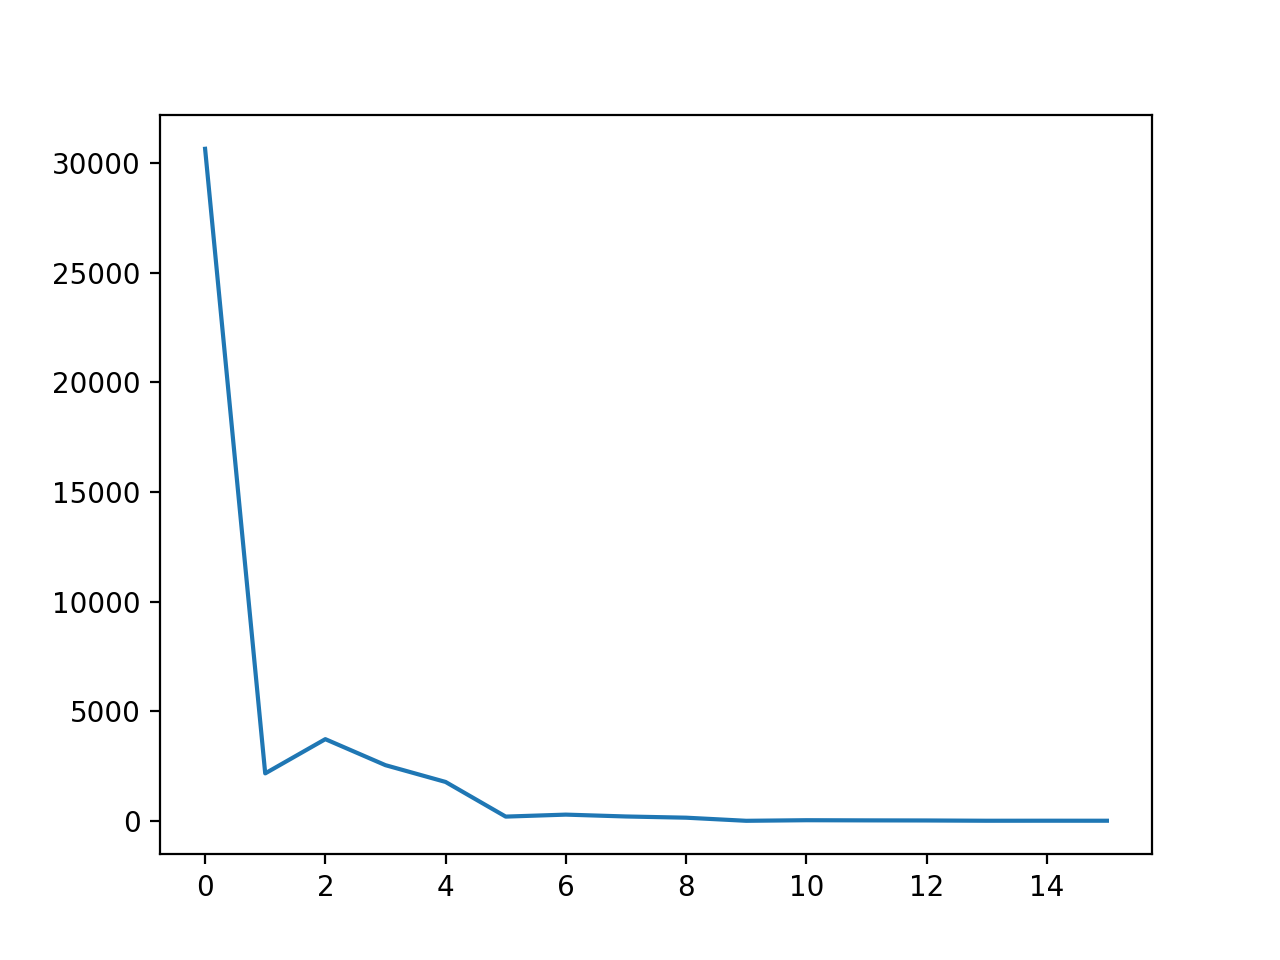

In [1796]:
plt.figure()
plt.plot(np.abs(drH))

In [1247]:
# [Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,YY,Eta,Xi]
# nans: s02, XXp, Eta, Xi

In [1756]:
drW,prW = np.linalg.eig(Wmy-np.eye(Wmy.shape[0]))

In [66]:
len(Wt[0][0])

12

In [184]:
    def gen_Weight(W,K,kappa,T):
        MuT = np.array((1,2,1))
        MuK = np.array((1,kappa))
        WT = circulate(W,T,nT,Mu=MuT)
        KKlist = [K for iT in range(nT)]
        KK = np.concatenate(KKlist,axis=0)
        WW = circulate(WT,KK,nS,Mu=MuK)
        return WW

In [187]:
    def circulate(V,M,nZ,Mu=None):
        Vpartlist = [V*(M[np.newaxis,:]**np.abs(iZ)) for iZ in range(-nZ+1,nZ)]
        if Mu is None:
            Mu = np.ones((nZ,))
        #VVlist = [np.concatenate([m*v for m,v in zip(Mu,Vpartlist[nZ-iZ-1:2*nZ-iZ-1])],axis=1) for iZ in range(nZ)]
        VVlist = [np.concatenate(Vpartlist[nZ-iZ-1:2*nZ-iZ-1],axis=1) for iZ in range(nZ)]
        #VV = np.concatenate(VVlist,axis=0)
        VV = np.concatenate([m*v for m,v in zip(Mu,VVlist)],axis=0)
        return VV

In [275]:
trystars_i = (0,)
trystars_j = (0,)
itry = 0
Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi,h = Wt[trystars_i[itry]][trystars_j[itry]]
labels = ['Wmx','Wmy','Wsx','Wsy','s02','k','kappa','T','XX','XXp','Eta','Xi','h']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wt[trystars_i[itry]][trystars_j[itry]][i]
Wstar_dict['as_list'] = [Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi,h]
np.save('weights_from_opto_200702.npy',Wstar_dict)

In [72]:
Wstar_dict = np.load('weights_200607.npy',allow_pickle=True)[()]
Wmx,Wmy,Wsx,Wsy,s02,K,kappa,T,XX,XXp,Eta,Xi = Wstar_dict['as_list']

In [95]:
dYY = Yhat_opto[1::2]-Yhat_opto[0::2]

<IPython.core.display.Javascript object>


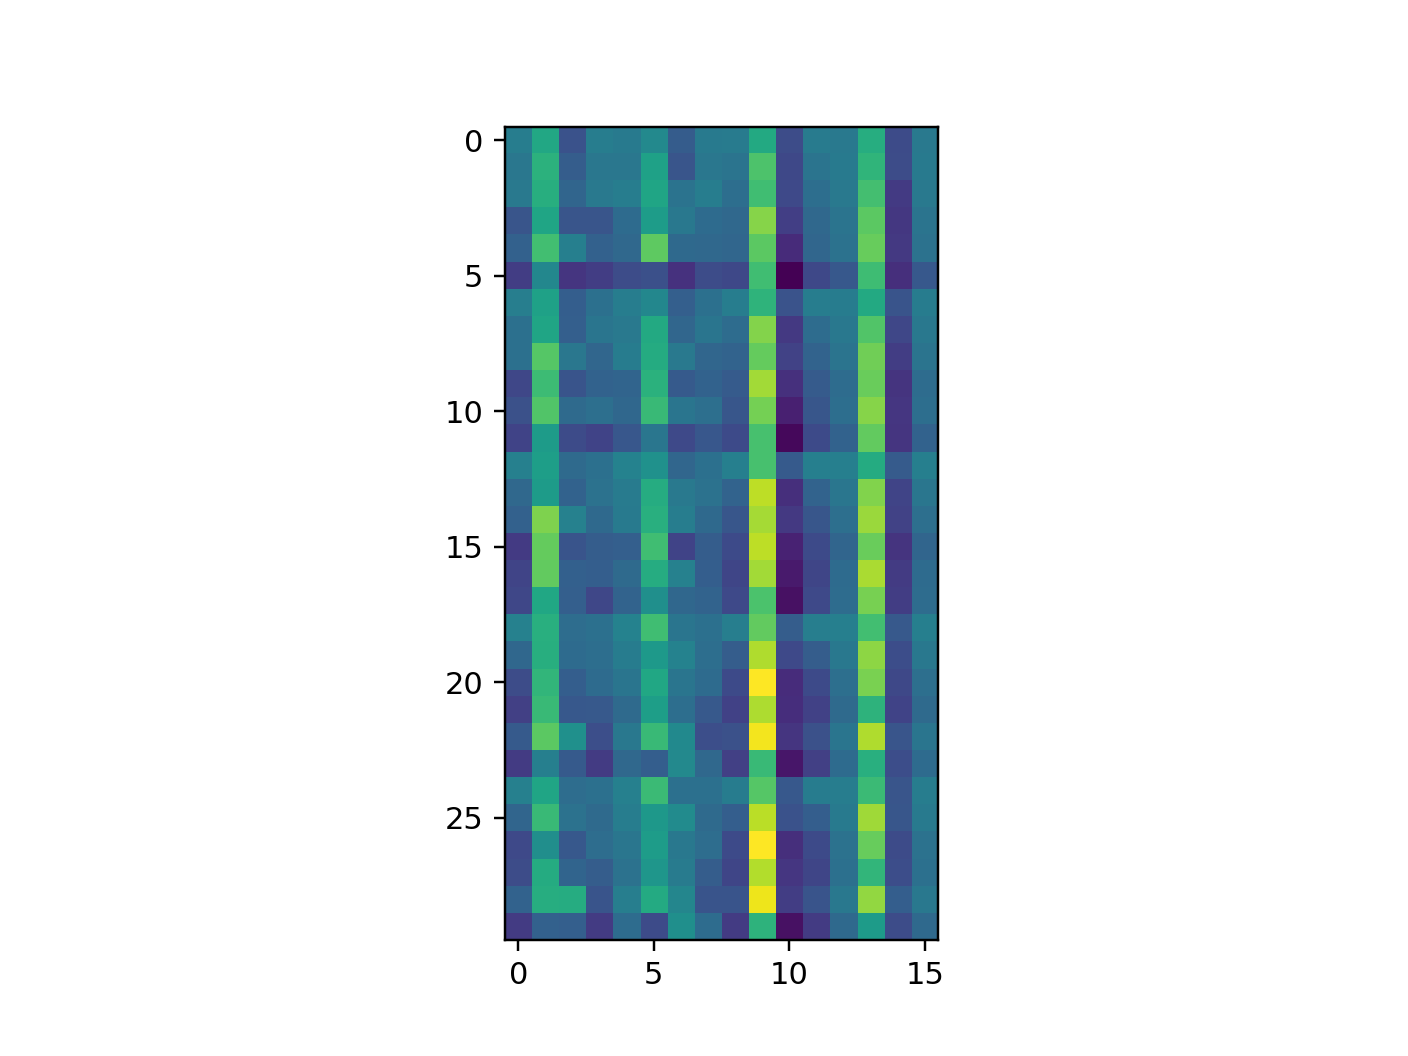

In [97]:
plt.figure()
plt.imshow(dYY)

In [117]:
reload(calnet.utils)
WWy = calnet.utils.gen_Weight_k_kappa_t(Wmy,K,kappa,T)
Phi = compute_fprime_m_(Eta,Xi,s02)
dHH = np.zeros((30,16))
dHH[:,[2,6,10,14]] = -1
dYYz = 0*dYY
x = np.linspace(-0.02,0.02,100)
score = np.zeros_like(x)
for ix in range(len(x)):
    score[ix] = np.sum((dYYz - (dYYz @ WWy) * Phi - dHH * x[ix] * Phi)**2)

In [123]:
(Phi*dHH).mean()

0.002498112101476194

<IPython.core.display.Javascript object>


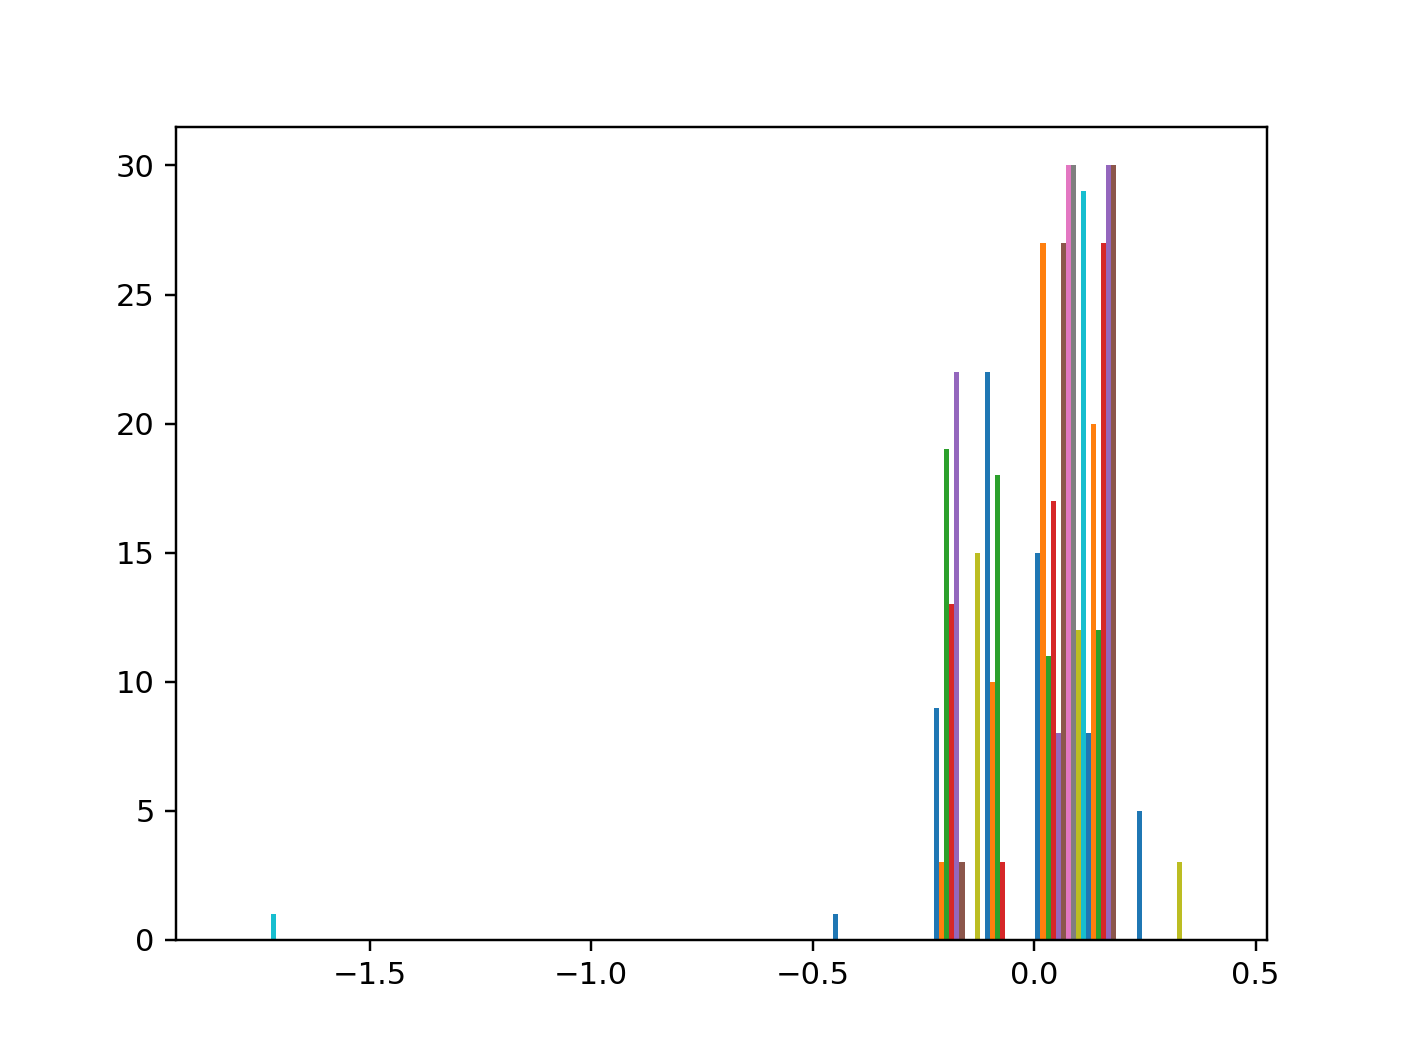

([array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  9., 15.,  5.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 27.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 19., 11.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 13., 17.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 22.,  8.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 27.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 15., 12.,  3.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 22.,  8.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 10., 20.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 18., 12.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 27.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.])],
 array([-1.84833978, -1

In [122]:
plt.figure()
plt.hist(Phi)

<IPython.core.display.Javascript object>


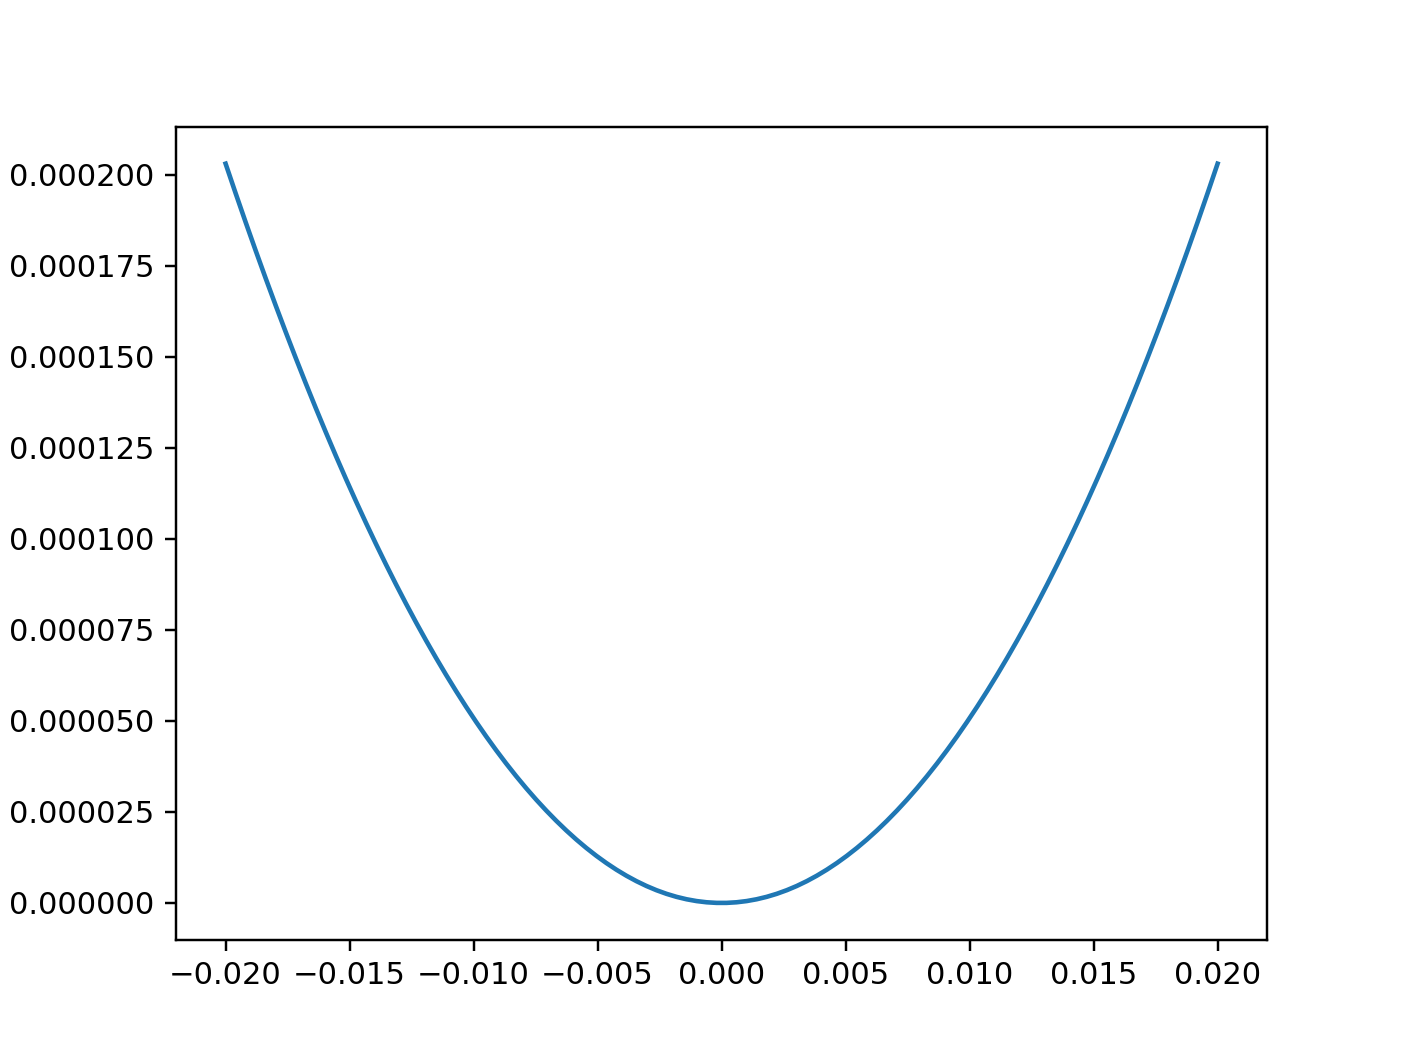

In [119]:
plt.figure()
plt.plot(x,score)

<IPython.core.display.Javascript object>


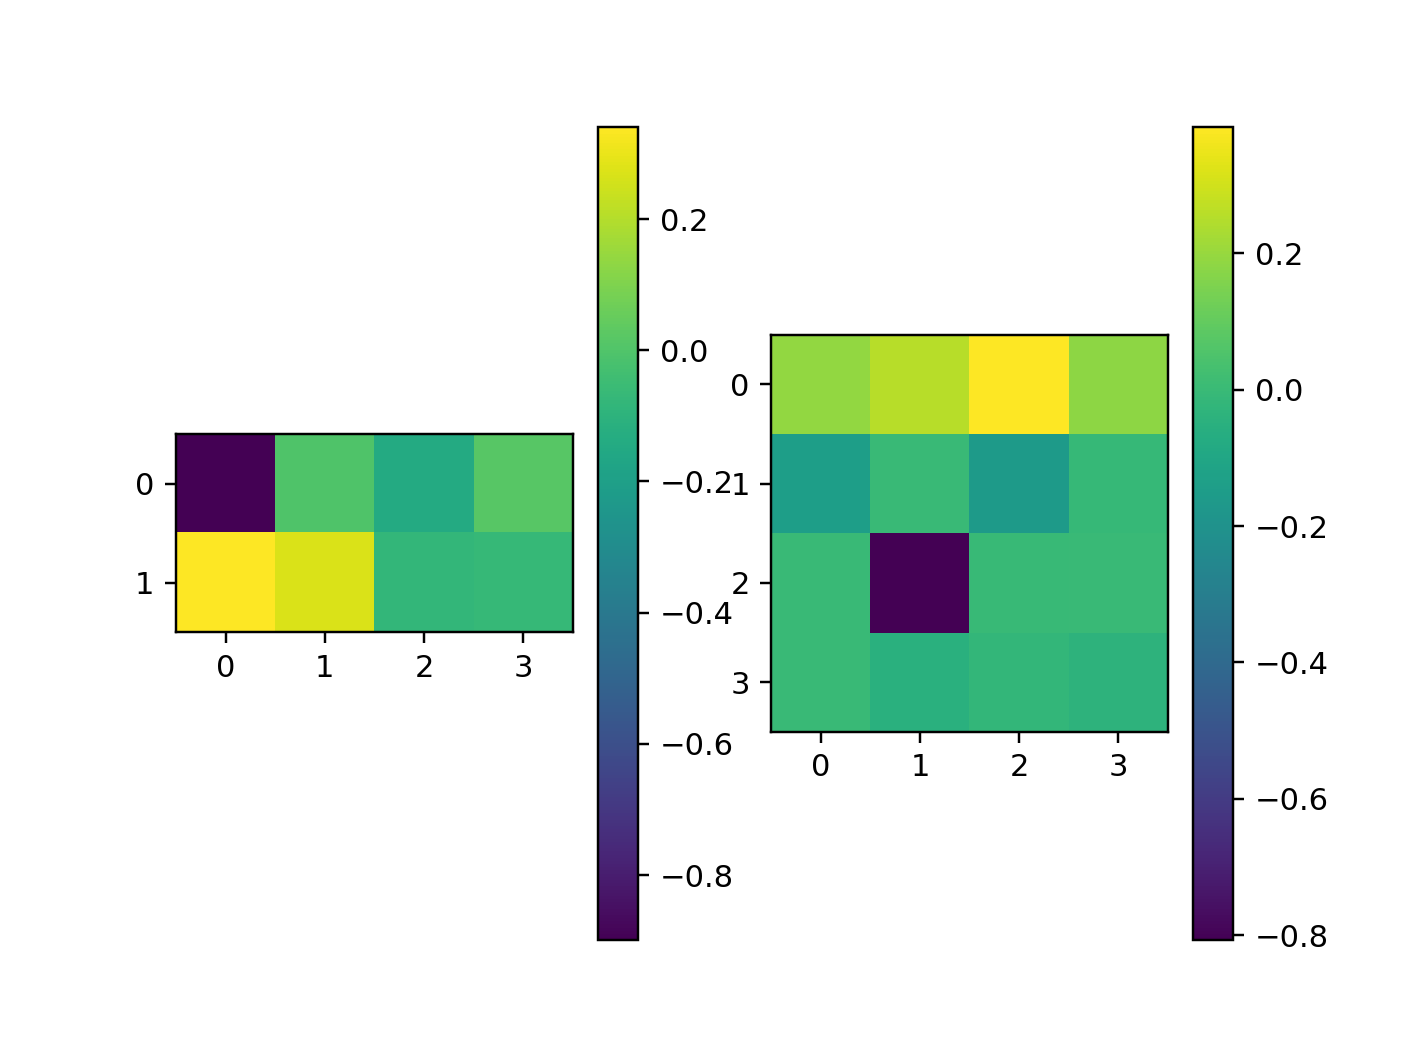

In [109]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Wmx)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Wmy)
plt.colorbar()

In [110]:
def show_four_celltypes(YYstar):
    lbls = ['PC','SST','VIP','PV']
    mag = 2
    plt.figure(figsize=(mag*nQ,mag))
    for itype in range(nQ):
        plt.subplot(1,nQ,itype+1)
        plt.title(lbls[itype])
        sca.show_size_contrast(YYstar[:,itype].reshape((5,6)),flipud=True)
    plt.tight_layout()

<IPython.core.display.Javascript object>


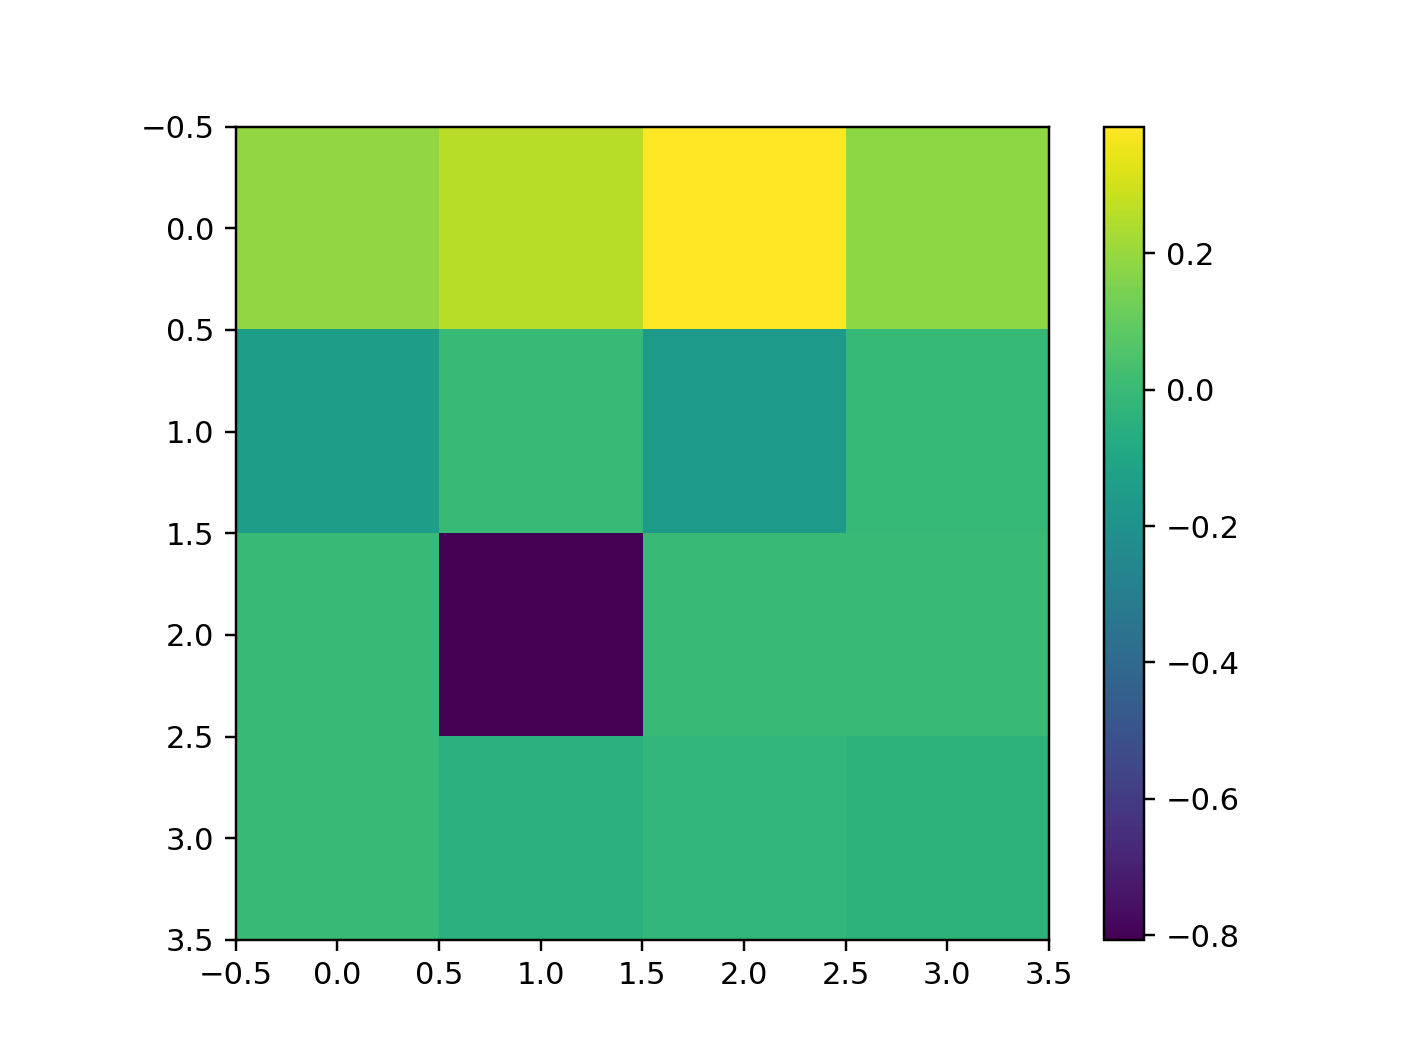

In [111]:
plt.figure()
plt.imshow(Wmy)
plt.colorbar()

<IPython.core.display.Javascript object>


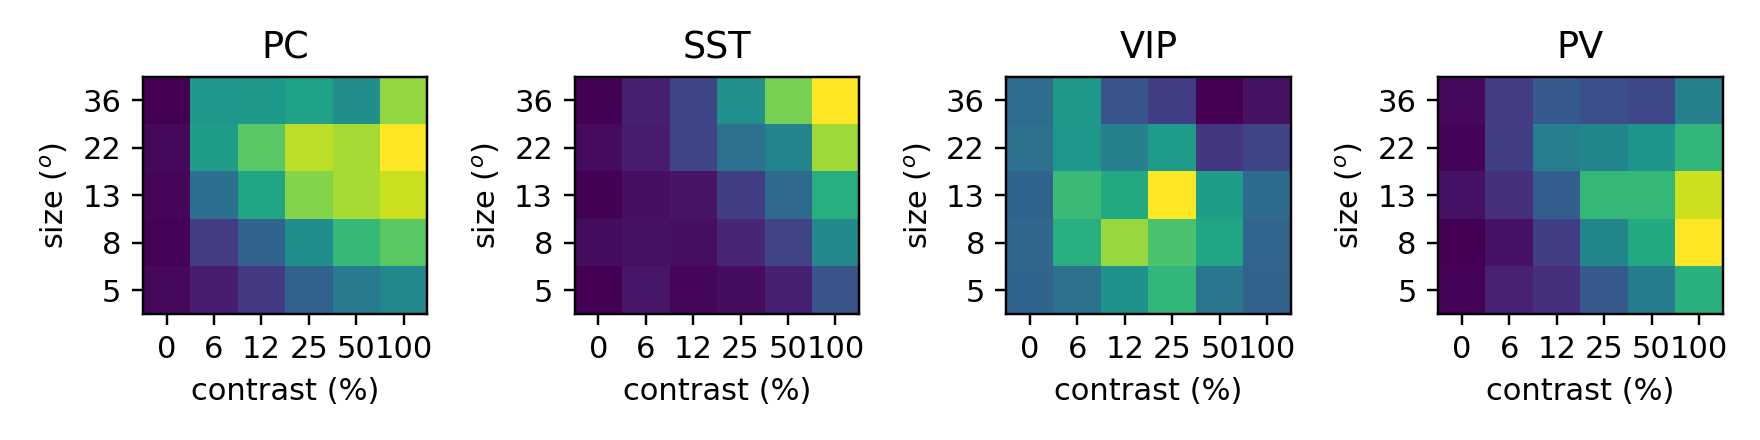

In [116]:
for itry in range(1): #ntries): 
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,T,XX,XXp,Eta,Xi = Wt[trystars_i[itry]][trystars_j[itry]]
#     Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[0][itry]
    XXhat = np.concatenate(Xhat,axis=1)
    YYhat = np.concatenate(Yhat,axis=1)
    YY = compute_f_(Eta,Xi,s02)
    Etastar = u_fn(XX,YY,Wmx,Wmy,k,kappa,T)
    Xistar = u_fn(XX,YY,Wsx,Wsy,k,kappa,T)
    YYstar = compute_f_(Etastar,Xistar,s02)
    show_four_celltypes(YY)
#     mag = 2
#     plt.figure(figsize=(mag*nQ,mag))
#     for itype in range(nQ):
#         plt.subplot(1,nQ,itype+1)
#         plt.title(lbls[itype])
#         sca.show_size_contrast(YYstar[:,itype].reshape((5,6)),flipud=True)
#     plt.tight_layout()
#     plt.savefig('figures/modeled_four_cell_types.jpg',dpi=300)

In [ ]:
plt.plot(YY)

<IPython.core.display.Javascript object>


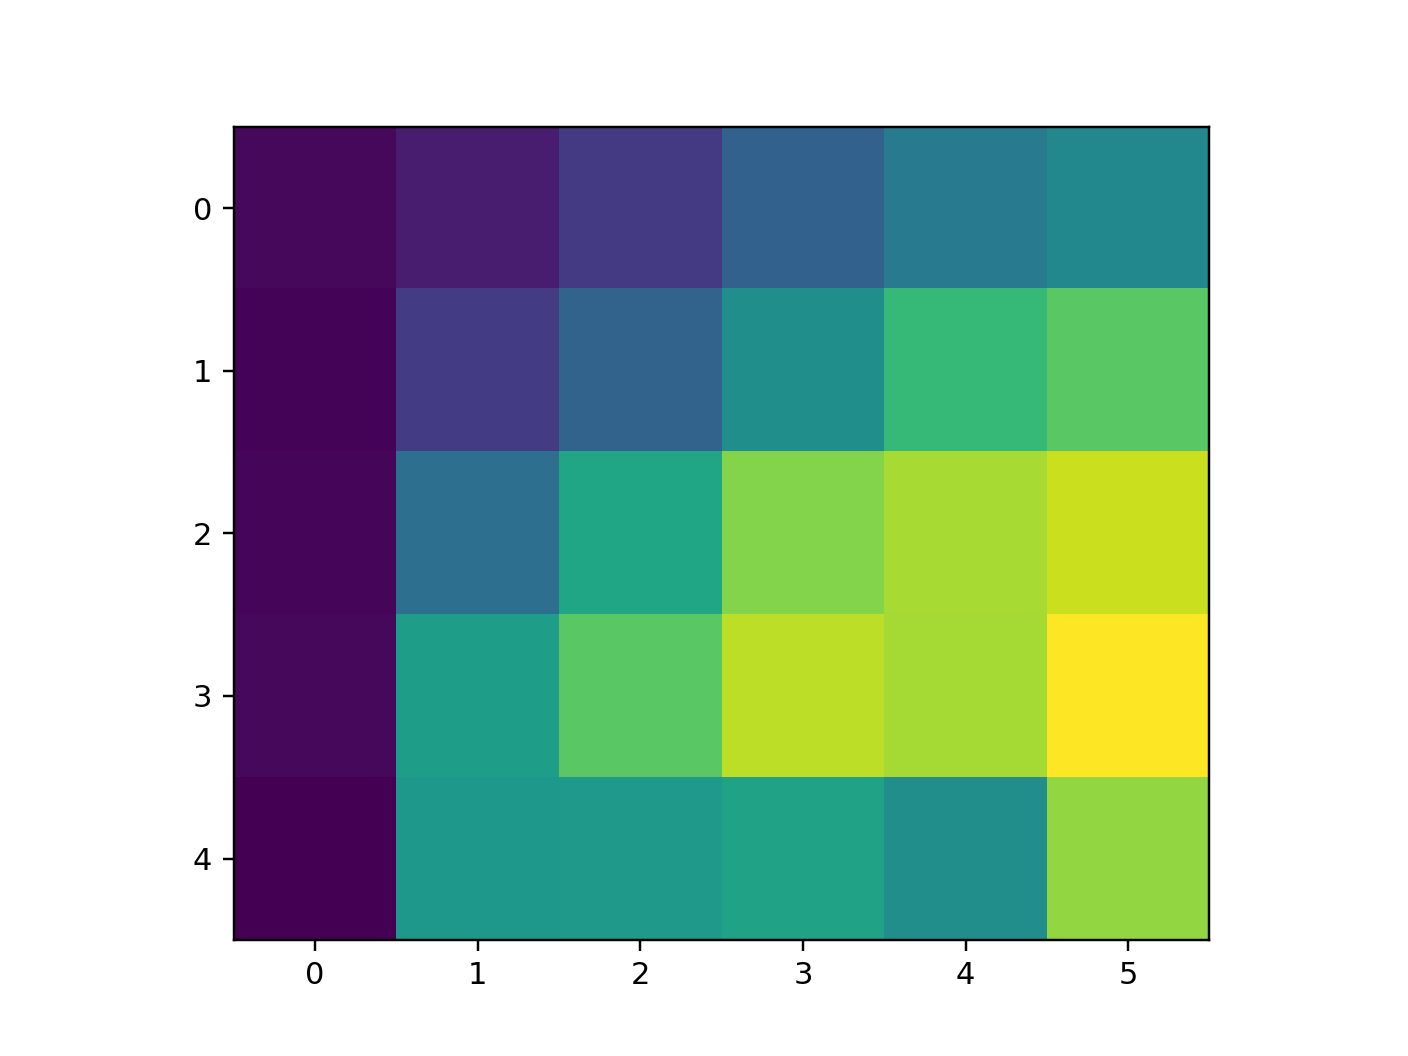

In [119]:
plt.figure()
plt.imshow(YY[:,0].reshape((5,6)))

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


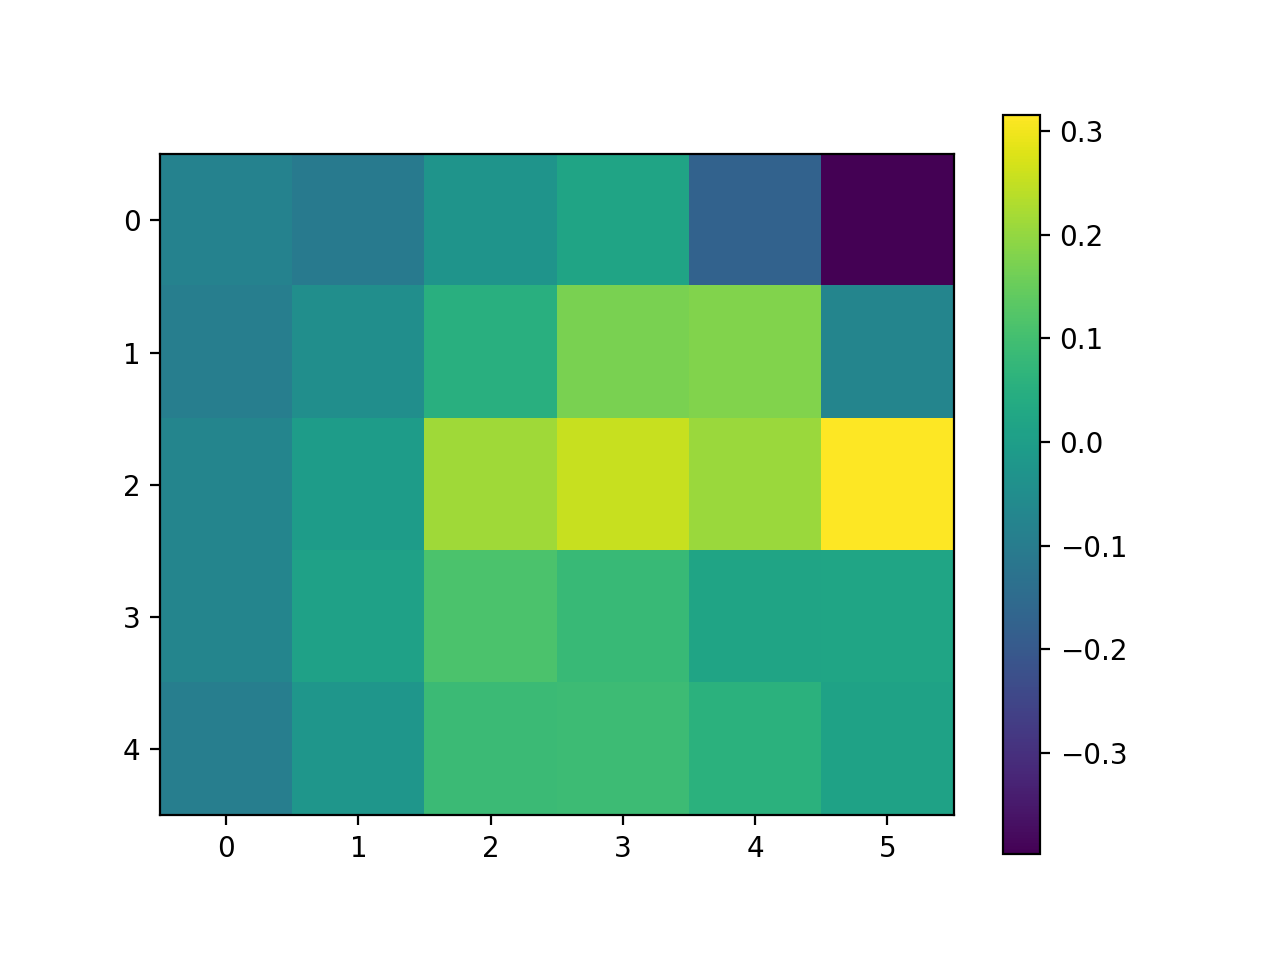

In [2088]:
plt.figure()
plt.imshow((YY-YYstar)[:,0].reshape((nsize,ncontrast)))
plt.colorbar()

In [2089]:
ww = gen_Weight(Wmy,k,kappa)
eig_actual = np.zeros((Etastar.shape[0],))
for istim in range(Etastar.shape[0]):
    eig_actual[istim] = np.max(np.real(np.linalg.eig(compute_fprime_(Eta,Xi,s02)[istim]@ww - np.eye(nS*nQ))[0]))
#     eig_actual[istim] = np.max(np.real(np.linalg.eig(compute_fprime_(Etastar,Xistar,s02)[istim]@ww - np.eye(ww.shape[0]))[0]))
    eig_no_gain = np.max(np.real(np.linalg.eig(ww - np.eye(ww.shape[0]))[0]))
    print((eig_actual[istim],eig_no_gain))

(-0.9999999999999993, -0.009993623305414886)
(-0.9999999999999992, -0.009993623305414886)
(-0.9999999999999993, -0.009993623305414886)
(-0.2368478149902454, -0.009993623305414886)
(1.7106625867160918, -0.009993623305414886)
(3.1400013220281733, -0.009993623305414886)
(-0.9999999999999987, -0.009993623305414886)
(-0.9999999999999996, -0.009993623305414886)
(-0.9999999999999994, -0.009993623305414886)
(-0.9999999999999991, -0.009993623305414886)
(-0.2759527000179595, -0.009993623305414886)
(1.0103883331405459, -0.009993623305414886)
(-0.9999999999999998, -0.009993623305414886)
(-0.9999999999999993, -0.009993623305414886)
(-0.9999999999999996, -0.009993623305414886)
(-0.3950126606634954, -0.009993623305414886)
(-0.003739102238442815, -0.009993623305414886)
(2.0213250147711292, -0.009993623305414886)
(-0.9999999999999996, -0.009993623305414886)
(-0.9999999999999998, -0.009993623305414886)
(-0.9999999999999993, -0.009993623305414886)
(-0.9103041883195016, -0.009993623305414886)
(1.172059055

In [2090]:
istim = 29
drf,prf = np.linalg.eig(compute_fprime_(Eta,Xi,s02)[istim]@ww - np.eye(nS*nQ))

In [2091]:
prf[:,1]

array([-0.99856234, -0.02025994, -0.02025994, -0.02025994, -0.02025994,
       -0.02025994, -0.02025994, -0.02025994])

In [2092]:
istim = -1
np.linalg.eig(compute_fprime_(Eta,Xi,s02)[istim]@ww - np.eye(nS*nQ))[1][0]

array([-0.35355339, -0.99856234,  0.22670029, -0.41994402, -0.11058865,
       -0.05784502,  0.22710208, -0.6688424 ])

In [2093]:
(Wmy[1,2],Wmy[2,1],Wmy[3,0],Wmy[1,0])

(-0.6628473584947526,
 -1.1850025100315922,
 -1.9382457900390289,
 -0.07592391320035187)

In [2094]:
YY = compute_f_(Eta,Xi,s02)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


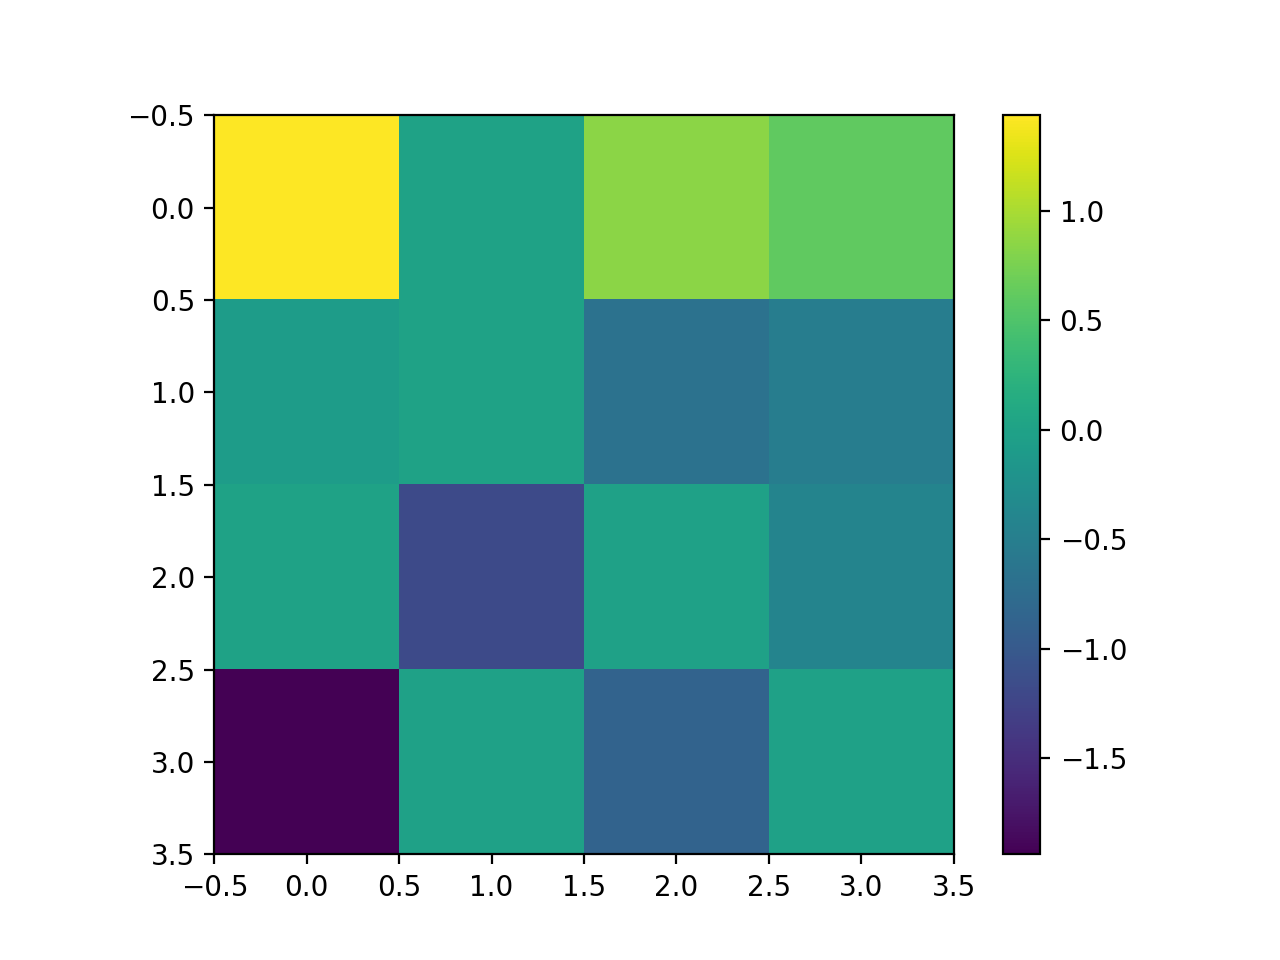

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


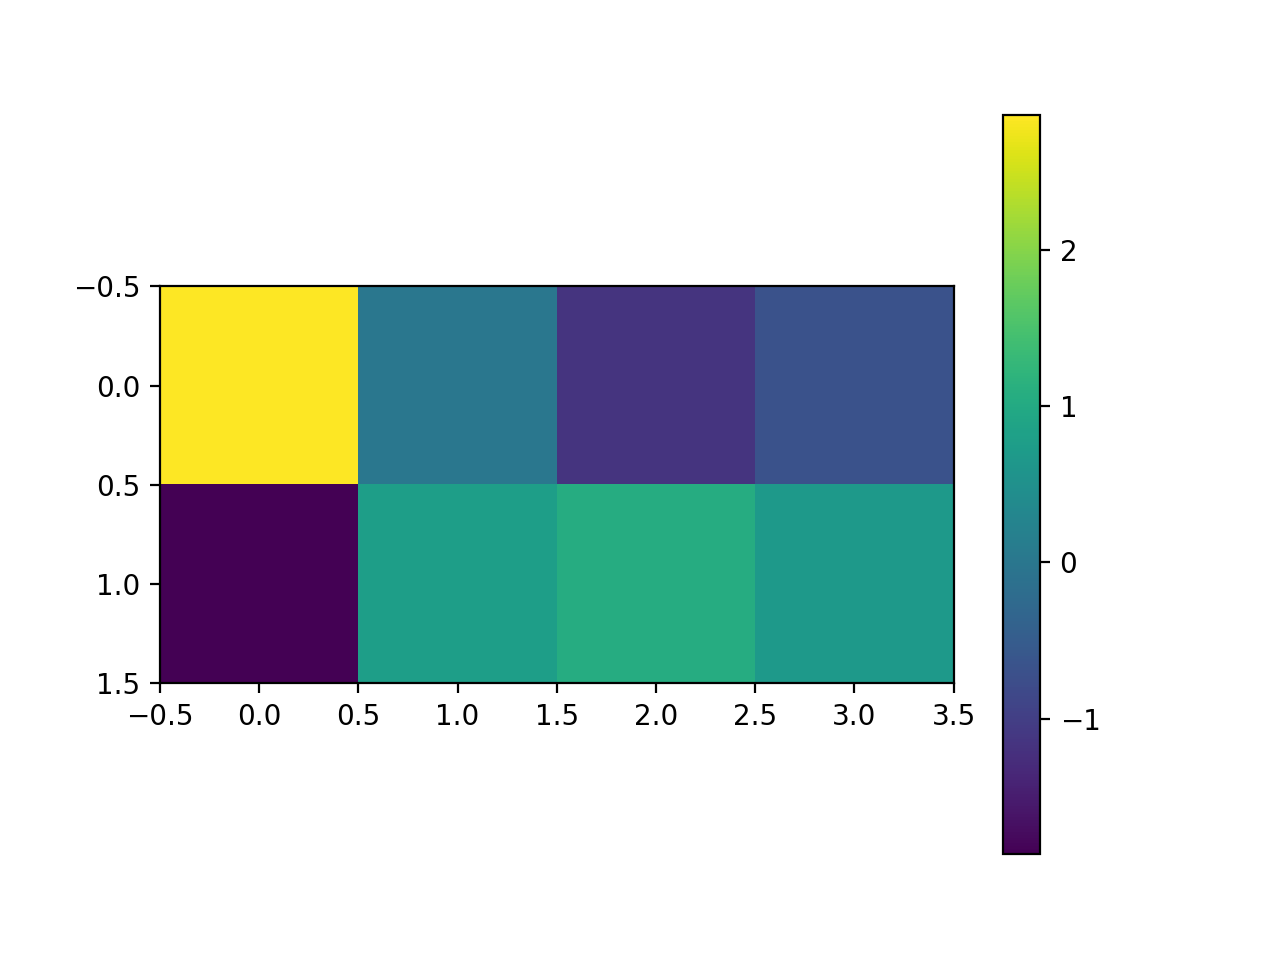

In [2095]:
plt.figure()
plt.imshow(Wmy)
plt.colorbar()
plt.figure()
plt.imshow(Wmx)#,vmin=-2,vmax=2)
plt.colorbar()

In [2096]:
Wmy_bounds

array([[ 2,  2,  2,  2],
       [-2,  0, -2, -2],
       [ 0, -2, -2, -2],
       [-2, -2, -2, -2]])

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


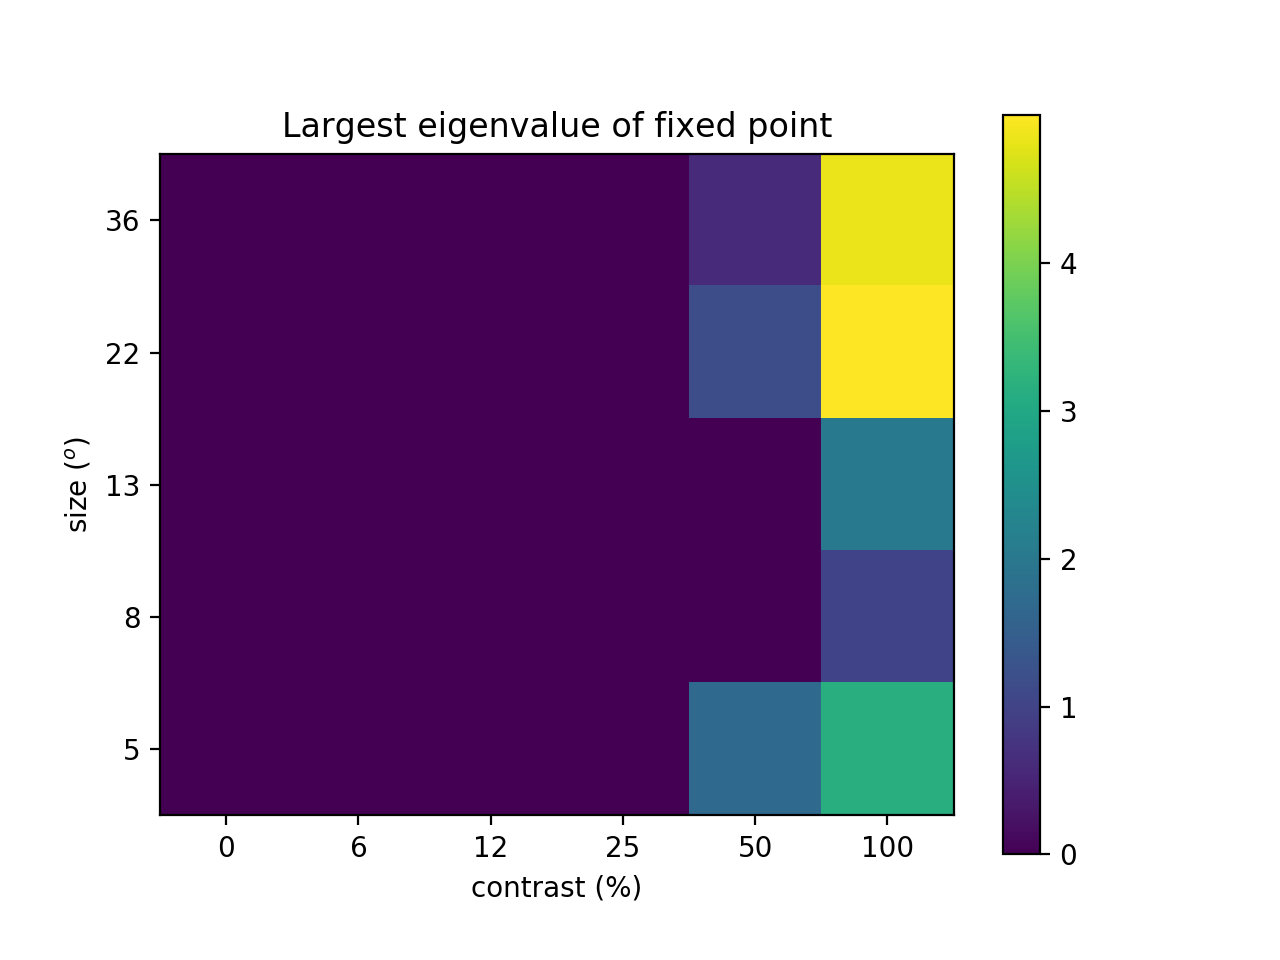

Text(0.5, 1.0, 'Largest eigenvalue of fixed point')

In [2097]:
plt.figure()
sca.show_size_contrast(eig_actual.reshape((nsize,ncontrast)),vmin=0,flipud=True)#,vmin=-1,vmax=1)
plt.colorbar()
plt.title('Largest eigenvalue of fixed point')
# plt.savefig('figures/possible_gamma_substrate.jpg',dpi=300)

In [1915]:
# Wstar_dict = np.load('weights_200111b.npy',allow_pickle=True)[()]

0
0
1
2
3
4
5
6
7
8
9


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


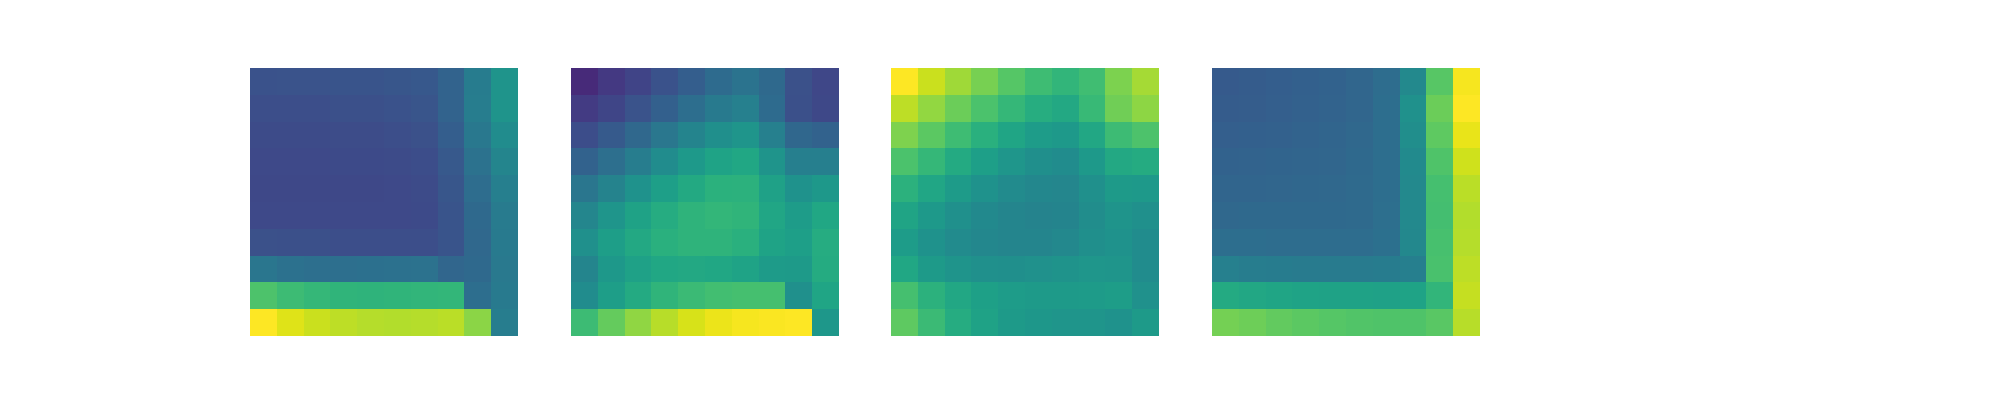

In [1945]:
nstar = len(trystars_i)
YY = [None for istar in range(nstar)]
Nvals = 10
max_val = 1
Niter = int(1e3)
for istar in range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[ti][tj]
    def fY(XX,YY):
        return compute_f_(u_fn(XX,YY,Wmx,Wmy,k,kappa),u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY(XX,YY0,eta=1e-2):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = eta*dYYdt(YY[iiter])
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    YY = np.zeros((Nvals,Nvals,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta[0],Xi[0],s02)
    XX = np.ones((Nvals,Nvals,4))
    XX[:,:,0],XX[:,:,2] = np.meshgrid(np.linspace(0,max_val,Nvals),np.linspace(0,max_val,Nvals),indexing='ij')
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for ival in range(Nvals):
        YY[ival,0] = predict_YY(XX[ival,0],YY0)
        print(ival)
        for jval in range(1,Nvals):
            YY[ival,jval] = predict_YY(XX[ival,jval],YY[ival-1,jval,-1])
            
    mag = 2
    plt.figure(figsize=(mag*ncelltypes,mag))
    for icelltype in range(nQ):
        plt.subplot(1,ncelltypes,icelltype+1)
        plt.imshow(YY[:,:,-1,icelltype],vmin=0)#,interpolation='bilinear')
        plt.axis('off')

In [1946]:
nstar = len(trystars_i)
YYsc = [None for istar in range(nstar)]
Niter = int(2e3)
for istar in range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    def fY(XX,YY):
        return compute_f_(resEta[ival]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[ival]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY(XX,YY0,eta=2e-2):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = eta*dYYdt(YY[iiter])
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    
    YYsc[istar] = np.zeros((nN,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02) + 0.05*np.tile(np.array((0,1,0,0,0,1,0,0))[np.newaxis],(nN,1)) #*np.random.randn(nN,nS*nQ)
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for ival in range(nN):
        YYsc[istar][ival] = predict_YY(XX[ival],YY0[ival])
        print(ival)
            
#     mag = 2
#     plt.figure(figsize=(mag*ncelltypes,mag))
#     for icelltype in range(nQ):
#         plt.subplot(1,ncelltypes,icelltype+1)
#         plt.imshow(YY[:,:,-1,icelltype],vmin=0,interpolation='bilinear')
#         plt.axis('off')

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


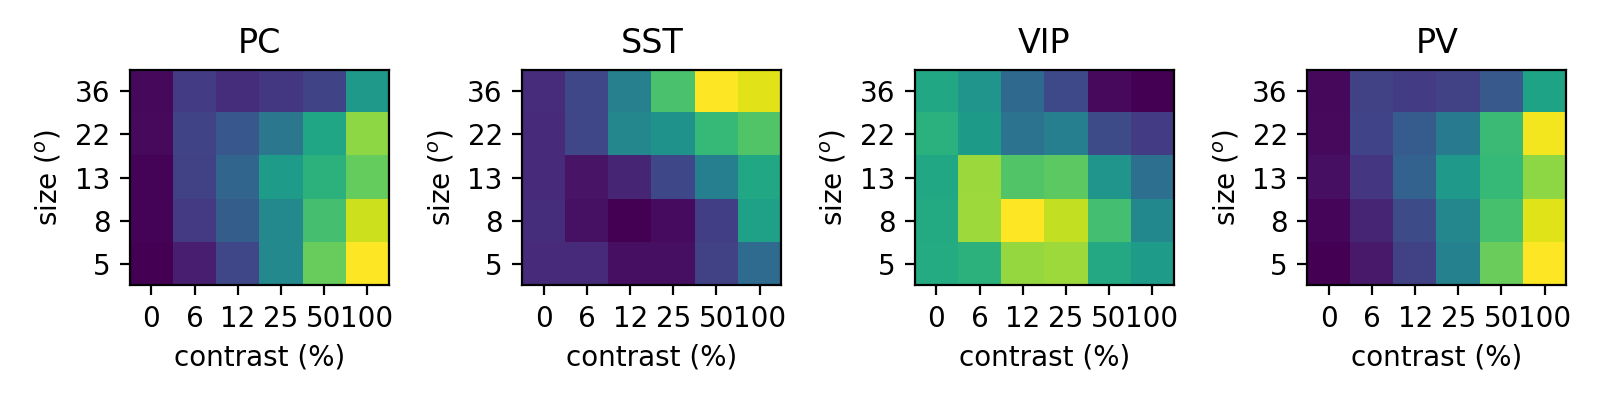

In [1947]:
show_four_celltypes(YYsc[0][:,-1])
# plt.savefig('figures/self_consistent_model_no_residual_currents.jpg',dpi=300)

In [1948]:
YY = compute_f_(Eta,Xi,s02)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


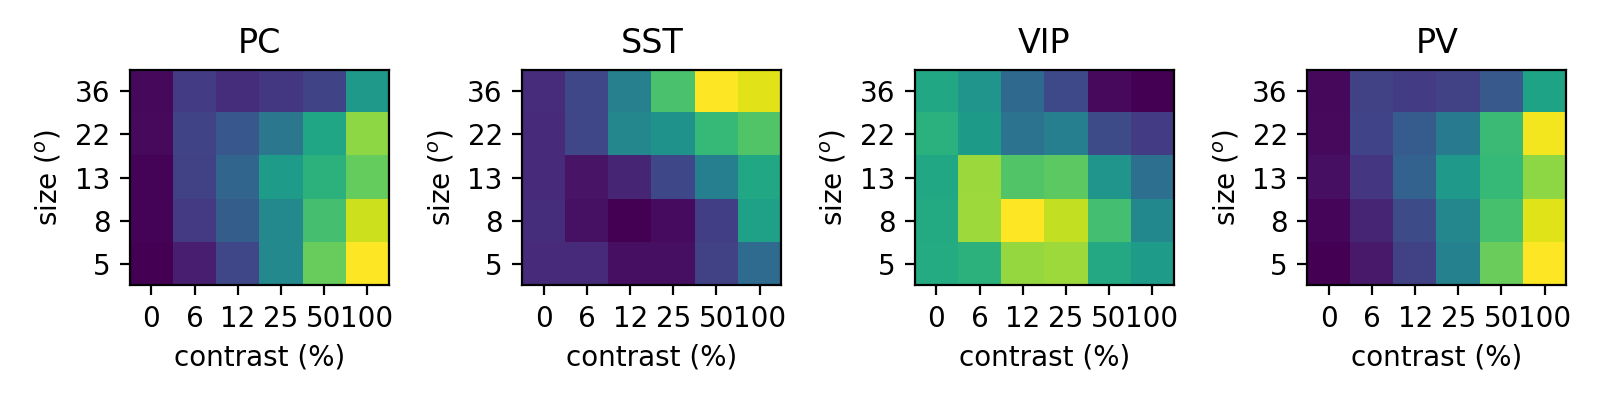

In [1949]:
show_four_celltypes(YY)#[0][:,-1])
# plt.savefig('figures/self_consistent_model_with_residual_currents.jpg',dpi=300)

In [2100]:
nstar = len(trystars_i)
Niter = int(3e3)
fix_dim = [0,1,2,3]
Nfix = len(fix_dim)
# YY = [None for ifix in range(Nfix)]
Ny = 50
max_val = 2.5
yvals = np.linspace(0,max_val,Ny)
stim_vals = np.arange(30)
Nstim = len(stim_vals)
for istar in (0,): #range(nstar):
    print(istar)
#     ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[ti][tj]
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    def fY(XX,YY):
        return compute_f_(resEta[stim_val]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[stim_val]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
    def predict_YY_fix_dim(XX,YY0,eta=1e-2,fix_dim=None,run_backward=False):
        def dYYdt(YY):
            return -YY + fY(XX,YY)
        YY = np.zeros((Niter+1,nS*nQ))
        YY[0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = eta*dYYdt(YY[iiter])
            if not fix_dim is None:
                dYY[fix_dim] = 0
            if run_backward:
                dYY = -dYY
            YY[iiter+1] = YY[iiter] + dYY
            iiter = iiter+1
        return YY
    
    YY_ss = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02)
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for istim,stim_val in enumerate(stim_vals): #range(nN):
        print(istim)
        for iy,yval in enumerate(yvals):
            for ifix in range(Nfix):
                yy0 = YY0[stim_val] #+np.random.randn(yy0.shape)
                yy0[fix_dim[ifix]] = yval
                YY_ss[ifix,istim,iy] = predict_YY_fix_dim(XX[stim_val],yy0,fix_dim=fix_dim[ifix])

0
0


KeyboardInterrupt: 

In [1040]:
# YY_ss = YY.copy()

In [ ]:
# def u_fn(XX,YY,Wx,Wy,k,kappa):
#     WWx,WWy = [gen_Weight(W,k,kappa) for W in [Wx,Wy]]
#     return XX @ WWx + YY @ WWy

In [1527]:
reload(utils)
nstar = len(trystars_i)
Niter = int(4e3)
fix_dim = [0,1,2,3]
Nfix = len(fix_dim)
# YY = [None for ifix in range(Nfix)]
Ny = 50
Nx = 20
max_val = 2.5
yvals = np.linspace(0,max_val,Ny)
xvals = np.linspace(0,max_val,Nx)
stim_vals = np.arange(30)
Nstim = len(stim_vals)
for istar in (0,): #range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    fval = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,fval,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,fval,Wsx,Wsy,k,kappa)
    WWmx,WWmy = [gen_Weight(W,k,kappa) for W in [Wmx,Wmy]]
    WWsx,WWsy = [gen_Weight(W,k,kappa) for W in [Wsx,Wsy]]
    def u_fn_m(XX,YY):
        return u_fn_WW(XX,YY,WWx=WWmx,WWy=WWmy)
    def u_fn_s(XX,YY):
        return u_fn_WW(XX,YY,WWx=WWsx,WWy=WWsy)
    def dfYdY(XX,YY):
        # derivs: (nN,nS*nQ)
        # WWy: (nS*nQ,nS*nQ)
        # (dfYdY)ij = dfj(Y)/dYi
        deriv_m = compute_fprime_m_(resEta[stim_val]+u_fn_m(XX,YY),resXi[stim_val]+u_fn_s(XX,YY),s02)
        deriv_s = compute_fprime_s_(resEta[stim_val]+u_fn_m(XX,YY),resXi[stim_val]+u_fn_s(XX,YY),s02)
        return deriv_m[:,np.newaxis,:]*WWmy[np.newaxis,:,:] + deriv_s[:,np.newaxis,:]*WWsy[np.newaxis,:,:]
    def fY(XX,YY):
        return compute_f_(resEta[stim_val:stim_val+1]+u_fn_m(XX,YY),resXi[stim_val:stim_val+1]+u_fn_s(XX,YY),s02)
    def predict_YY_fix_dim(XX,YY0,eta=2e-1,fix_dim=0,run_backward=False):
        def F(YY):
            # YY: (nN,nS*nQ)
            # F: (nN,nS*nQ)
            return -YY + fY(XX,YY)
        def dFdYY(YY):
            # dFdYY: (nN,nS*nQ,nS*nQ)
            # (dFdYY)ij = dFj(Y)/dYi, inherited from dfYdY convention
            return -np.eye(nS*nQ)[np.newaxis,:,:] + dfYdY(XX,YY)
        def dF2dYY(YY):
            # dFdYY: (nN,nS*nQ,nS*nQ)
            # F: (nN,nS*nQ)
            # dF2dYY: (nN,nS*nQ)
            # (dFdYY)ij = dFj(Y)/dYi, so sum_j ( dFj(Y)/dYi Fj(Y) = sum_j (dFdYY)ij Fj) yields the right answer
            return np.einsum('hij,hj->hi',dFdYY(YY),F(YY))
        YY = np.zeros((1,Niter+1,nS*nQ))
        YY[:,0] = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.zeros_like(YY[:,0])
        iiter = 0
        while iiter < Niter: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            dYY = -eta*dF2dYY(YY[:,iiter])
            dYY[:,fix_dim] = 0
            if run_backward:
                dYY = -dYY
            YY[:,iiter+1] = YY[:,iiter] + dYY
            iiter = iiter+1
        return YY
    
    YY_F2 = np.zeros((Nfix,Nstim,Ny,Nx,Niter+1,nS*nQ))
    YY0 = compute_f_(Eta,Xi,s02)
#     XX[:,2] = np.linspace(0,max_val,Nvals)
    for istim,stim_val in enumerate(stim_vals): #range(nN):
        print(istim)
        for iy,yval in enumerate(yvals):
            for ix,xval in enumerate(xvals):
                for ifix in range(Nfix):
    #                 yy0 = YY0[stim_val] #+np.random.randn(yy0.shape)
                    yy0[:] = np.random.rand(*yy0.shape)
                    yy0[fix_dim[ifix]] = yval
                    YY_F2[ifix,istim:istim+1,iy,ix] = predict_YY_fix_dim(XX[stim_val:stim_val+1],yy0[np.newaxis],fix_dim=fix_dim[ifix])
    #             if np.remainder(iy,10)==0:
#                 print(iy)
            
#     mag = 2
#     plt.figure(figsize=(mag*ncelltypes,mag))
#     for icelltype in range(nQ):
#         plt.subplot(1,ncelltypes,icelltype+1)
#         plt.imshow(YY[:,:,-1,icelltype],vmin=0,interpolation='bilinear')
#         plt.axis('off')

0
0


KeyboardInterrupt: 

In [1057]:
pdb.pm()

> <ipython-input-1056-9146c9d1360a>(48)dF2dYY()
-> return dFdYY(YY) @ F(YY)
(Pdb) dFdYY.shape
*** AttributeError: 'function' object has no attribute 'shape'
(Pdb) dFdYY(YY).shape
(1, 8, 8)
(Pdb) F(YY).shape
(1, 8)
(Pdb) exit


<IPython.core.display.Javascript object>


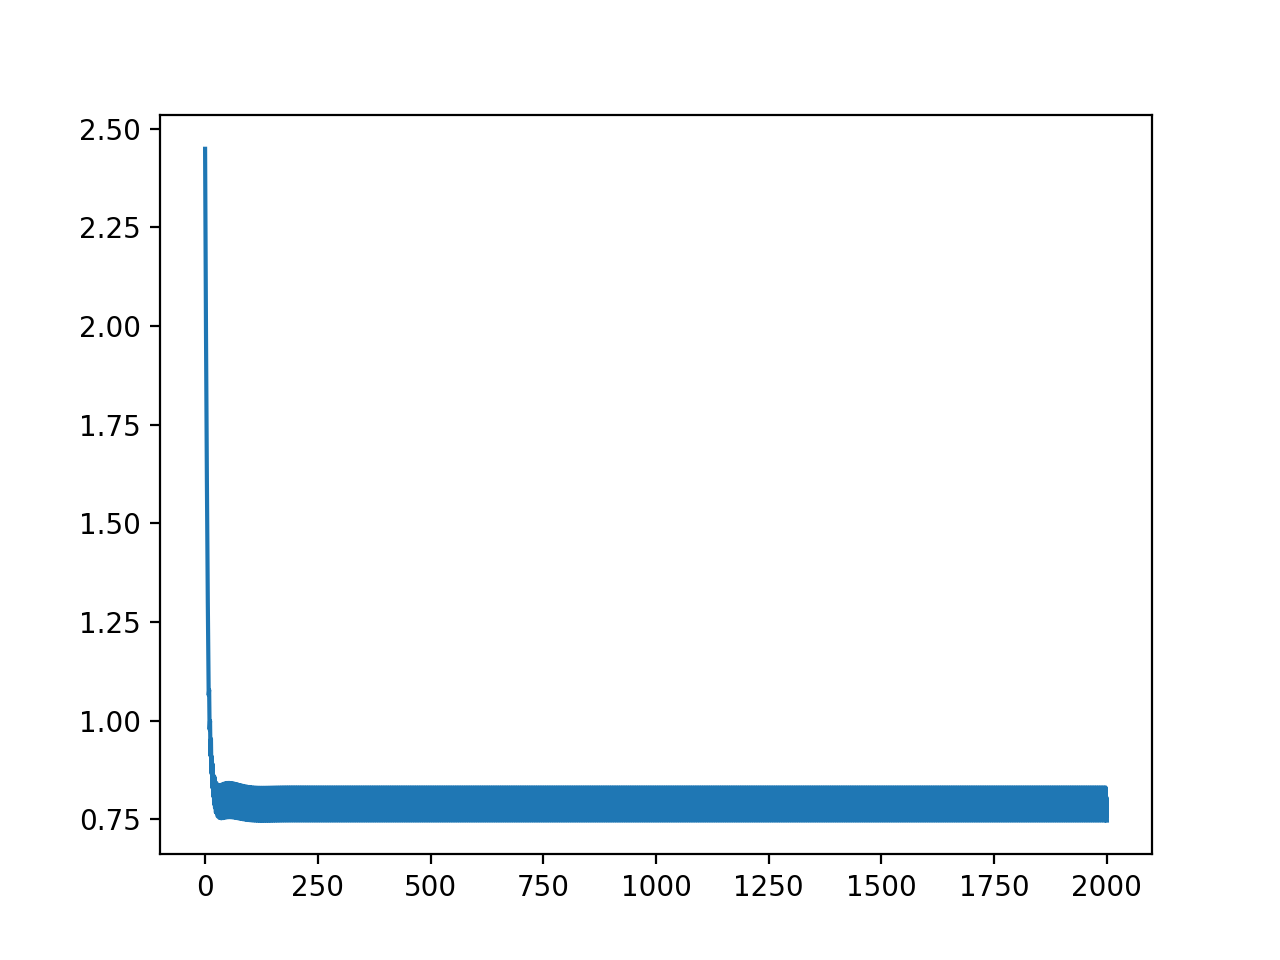

In [604]:
plt.figure()
plt.plot(YY[ix,istim,-1,:,iy])

In [1960]:
Wmy[2,1],Wmy[1,2]

(-2.144034644009146, -0.5218867289146812)

<IPython.core.display.Javascript object>


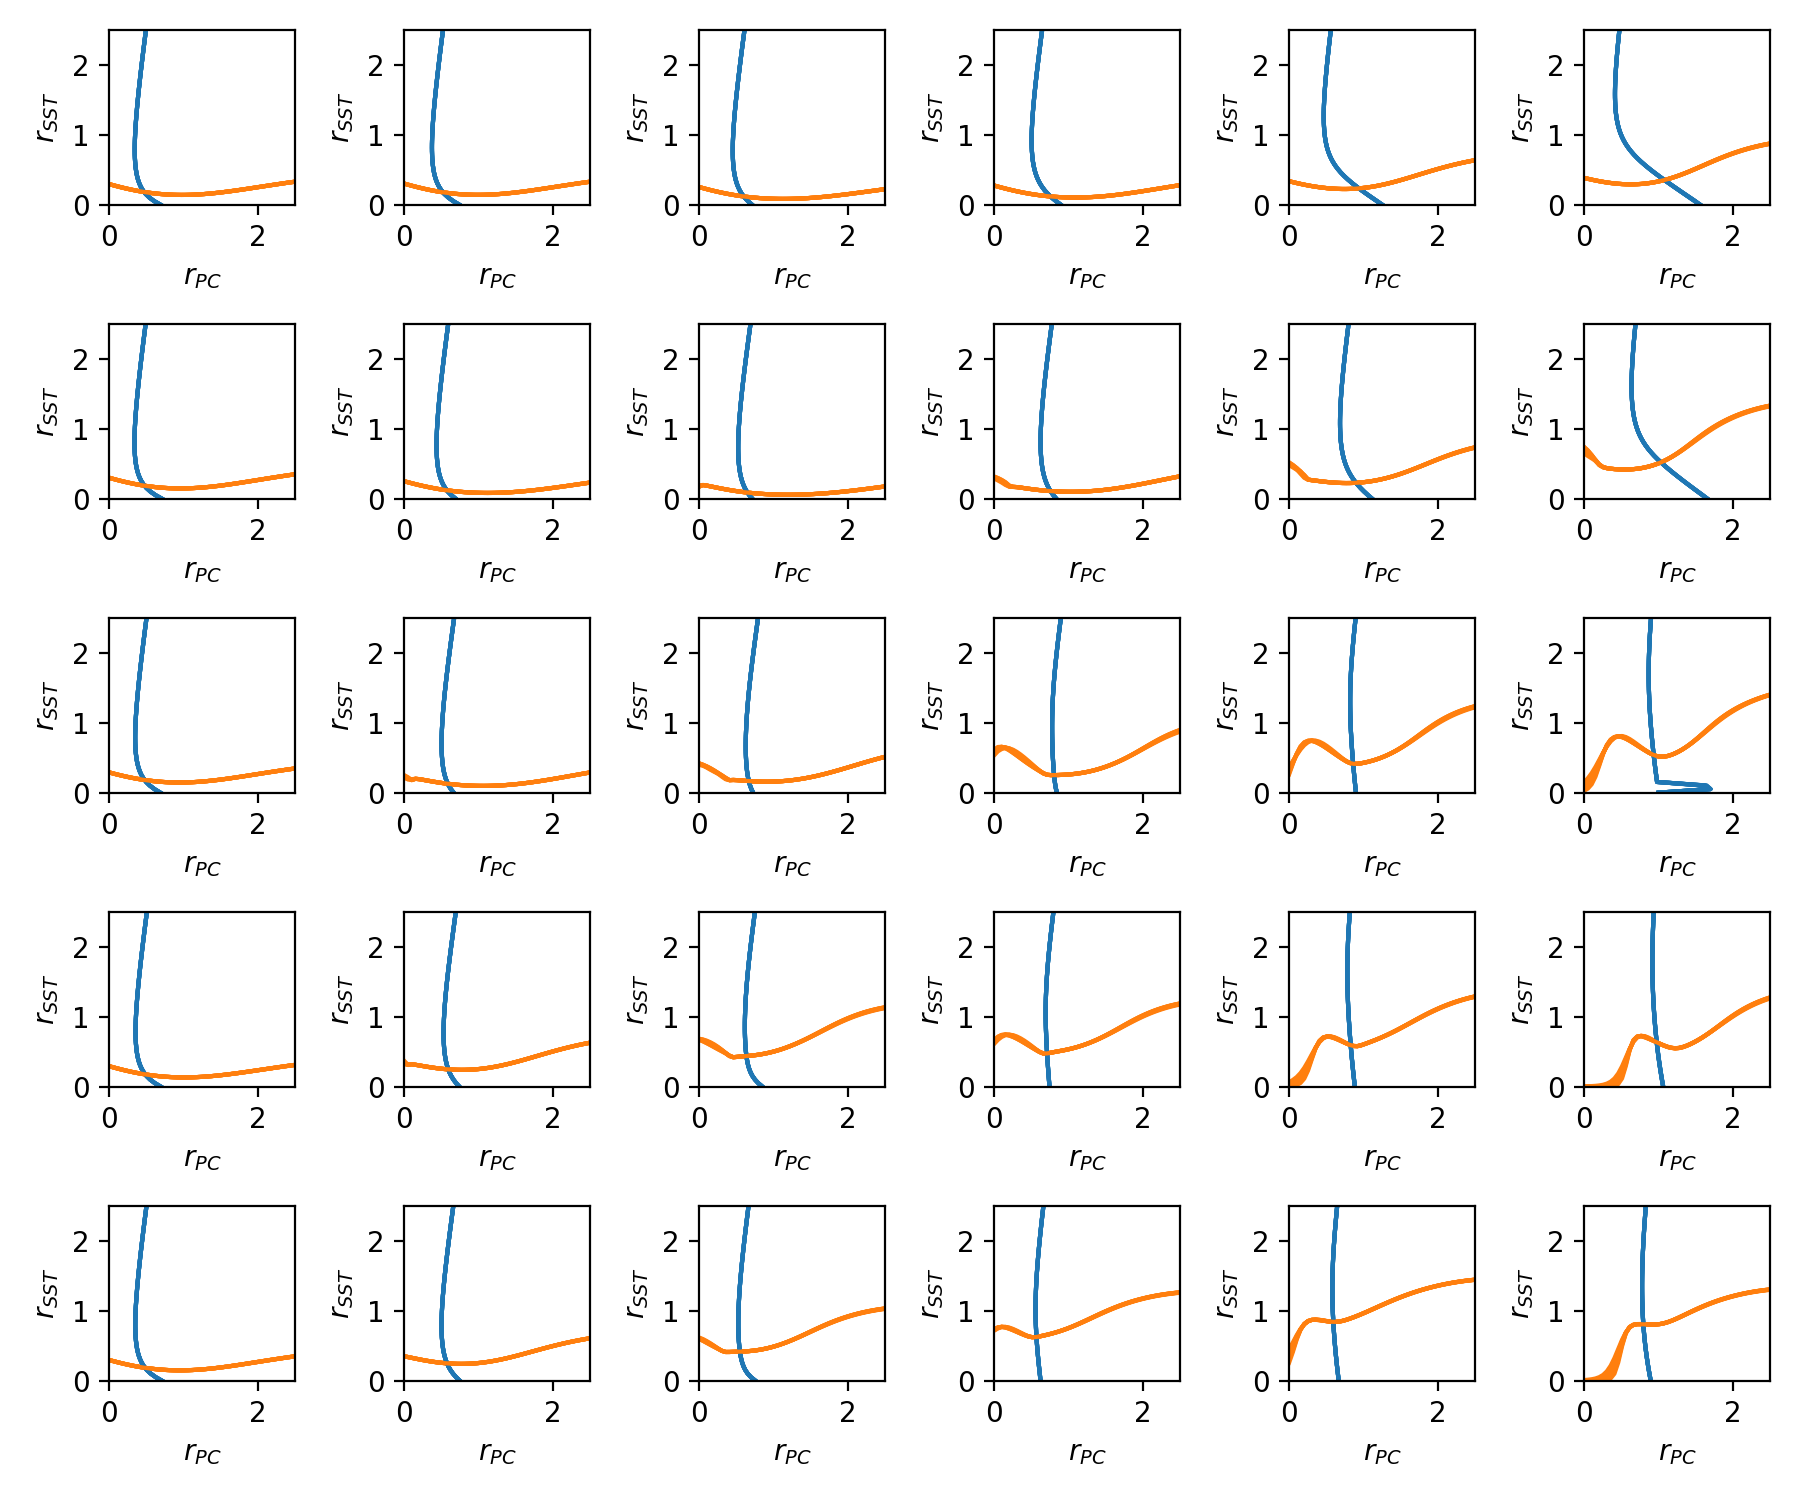

In [1986]:
mag = 1.5
plt.figure(figsize=(ncontrast*mag,nsize*mag))
# YY = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
ix = 0
iy = 1
for yy in [YY_ss]:#,YY_F2]:
    linestyles = ['solid','dashed']
    for istim in range(Nstim):
        plt.subplot(nsize,ncontrast,stim_vals[istim]+1)
        for it in np.arange(-1001,0,200):
            xvals = yy[iy,istim,:,it,ix]
            gd = xvals < max_val
            plt.plot(xvals[gd],yvals[gd],label='$dr_{PC}/dt=0$',c='C0',linestyle=linestyles[idir])
            xvals = yy[ix,istim,:,it,iy]
            gd = xvals < max_val
            plt.plot(yvals[gd],xvals[gd],label='$dr_{SST}/dt=0$',c='C1',linestyle=linestyles[idir])
    #     plt.legend()
        plt.xlabel('$r_{%s}$' % lbls[ix])
        plt.ylabel('$r_{%s}$' % lbls[iy])
#         plt.axis('equal')
        plt.ylim((0,1*max_val))
        plt.xlim((0,1*max_val))
    plt.tight_layout()

In [2101]:
nstar = len(trystars_i)
Niter = int(3e3)
fix_dim = [0,1,2,3]
Nfix = len(fix_dim)
# YY = [None for ifix in range(Nfix)]
Ny = 50
max_val = 2.5
yvals = np.linspace(0,max_val,Ny)
stim_vals = np.arange(30)
Nstim = len(stim_vals)
for istar in (0,): #range(nstar):
    print(istar)
#     ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wstar_dict['as_list'] #Wt[ti][tj]
    YY_ctrl = compute_steady_state(Wstar_dict['as_list'],Niter=int(5e2),dt=1e-1,perturbation_size=5e-2,max_val=None,Ny=None,fix_dim=None,stim_vals=None)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


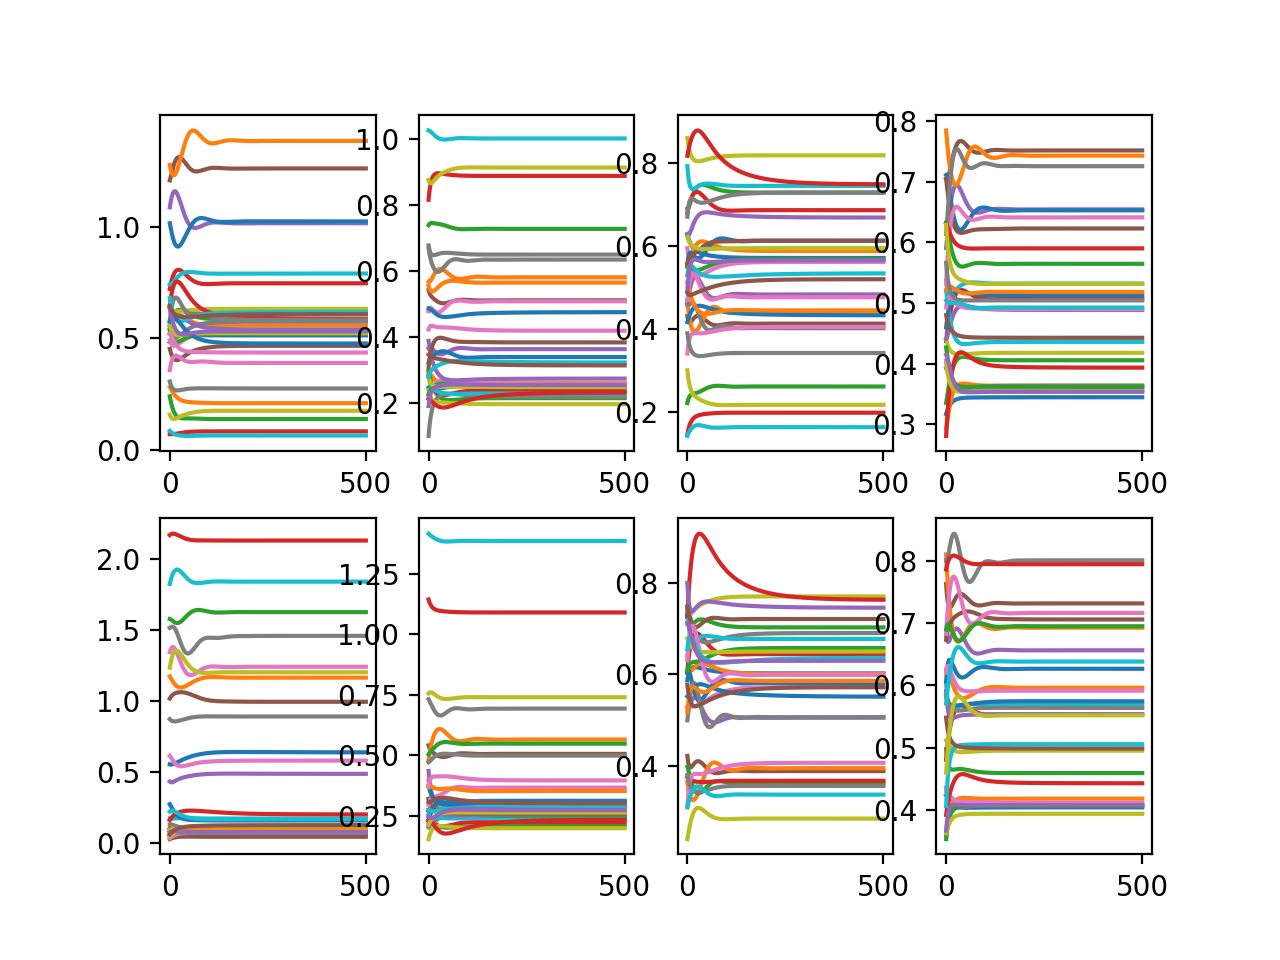

In [2104]:
plt.figure()
for icelltype in range(8):
    plt.subplot(2,4,icelltype+1)
    plt.plot(YY_ctrl[:,:,icelltype].T)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


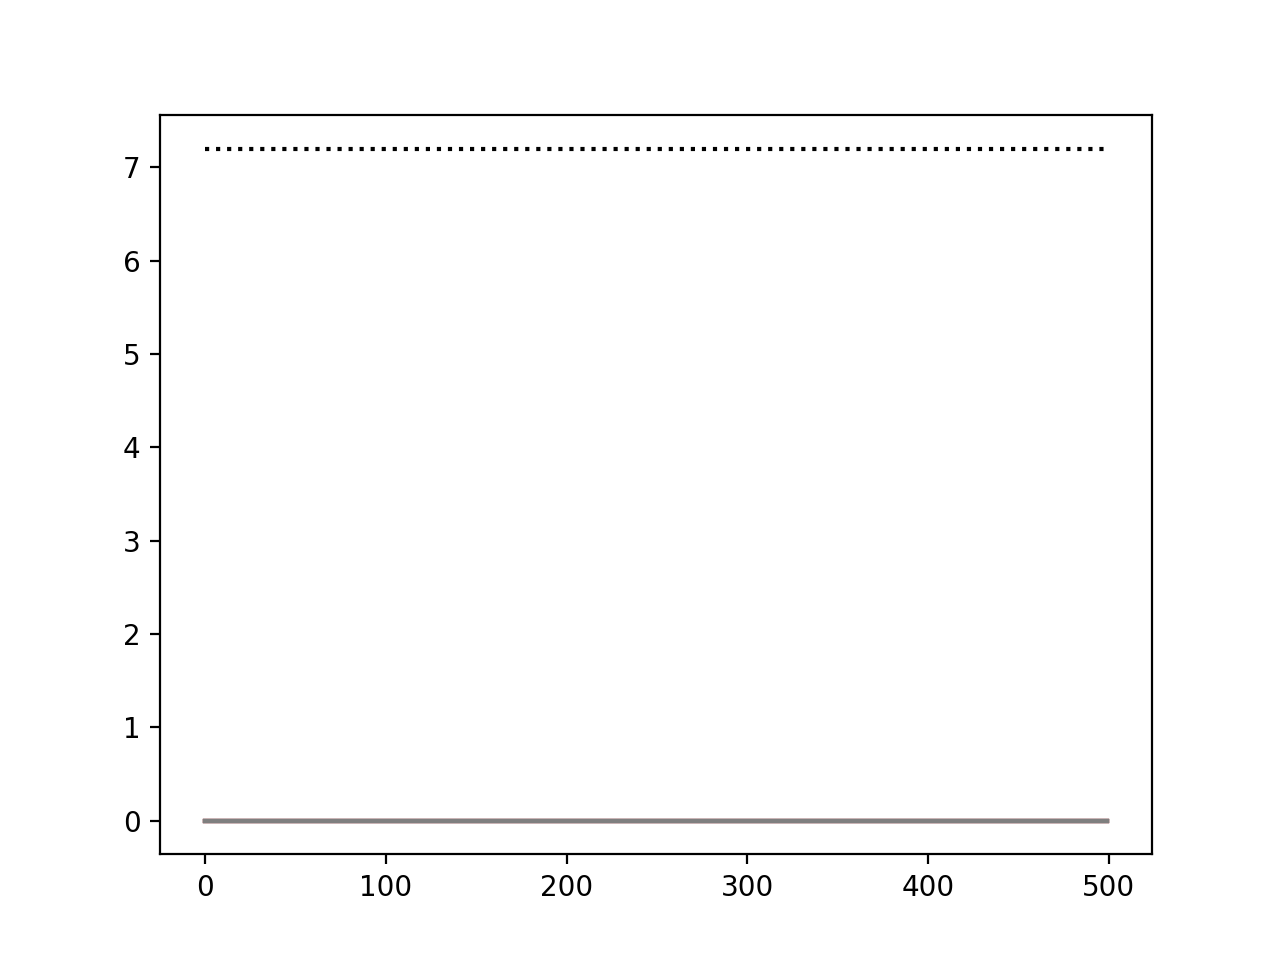

In [2105]:
istim = 29
iy = 0
others = np.arange(8)!=iy
# this_yy = YY_F2[iy,istim,:,iinit,:,:]
this_yy = YY_ss[iy,istim,:,:,:]
def fY(XX,YY):
    return compute_f_(resEta[istim]+u_fn(XX,YY,Wmx,Wmy,k,kappa),resXi[istim]+u_fn(XX,YY,Wsx,Wsy,k,kappa),s02)
speed = np.sum(np.abs(fY(XX[istim],this_yy)-this_yy)[:,:,others],-1)
plt.figure()
this_one = 25
plt.plot(speed[this_one,-500:].T,c='k',linestyle='dotted')
plt.plot(YY_ss[iy,istim,this_one,-500:,:])

In [1414]:
fY(XX[istim],this_yy).shape

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


(50, 4001, 8)

<IPython.core.display.Javascript object>


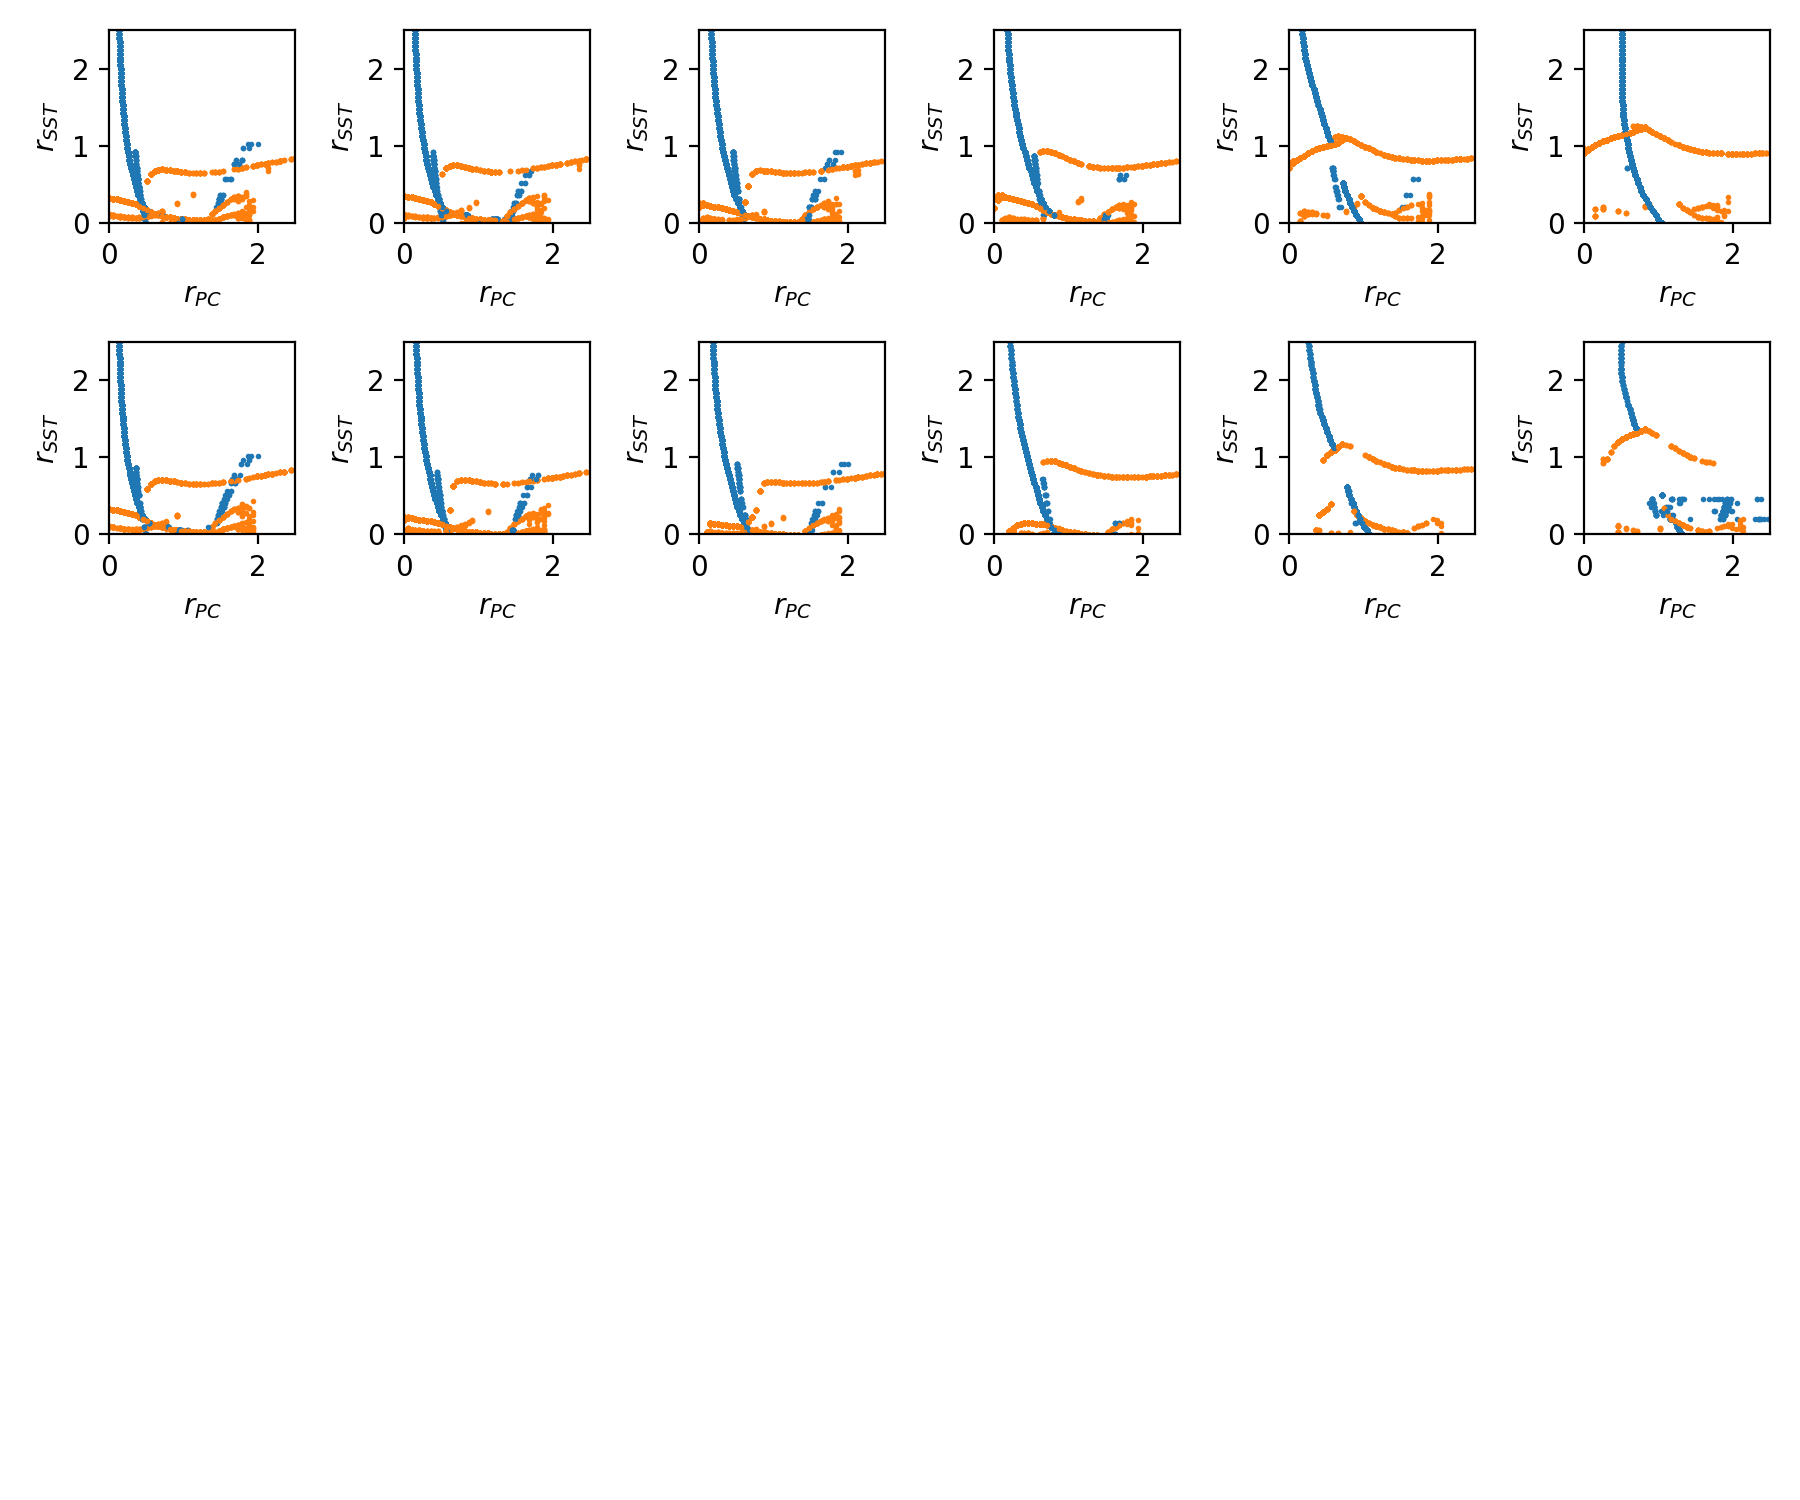

In [1399]:
mag = 1.5
plt.figure(figsize=(ncontrast*mag,nsize*mag))
# YY = np.zeros((Nfix,Nstim,Ny,Niter+1,nS*nQ))
ix = 0
iy = 1
idir = 0
for yy in [YY_F2]:
    linestyles = ['solid','dashed']
    for istim in range(12):#Nstim):
        def fY(YY):
            return compute_f_(resEta[stim_vals[istim]]+u_fn(XX[stim_vals[istim]],YY,Wmx,Wmy,k,kappa),resXi[stim_vals[istim]]+u_fn(XX[stim_vals[istim]],YY,Wsx,Wsy,k,kappa),s02)
        plt.subplot(nsize,ncontrast,stim_vals[istim]+1)
        for it in (-250,-100,-1):
            for iinit in range(Nx):
                this_yy = yy[iy,istim,:,iinit,it,:]
                xvals = yy[iy,istim,:,iinit,it,ix]
                gd = (xvals < max_val) & np.sum(np.abs(fY(this_yy)-this_yy),-1)<1e-4
                plt.scatter(xvals[gd],yvals[gd],label='$dr_{PC}/dt=0$',c='C0',linestyle=linestyles[idir],s=1)
                xvals = yy[ix,istim,:,iinit,it,iy]
                gd = xvals < max_val
                plt.scatter(yvals[gd],xvals[gd],label='$dr_{SST}/dt=0$',c='C1',linestyle=linestyles[idir],s=1)
    #     plt.legend()
        plt.xlabel('$r_{%s}$' % lbls[ix])
        plt.ylabel('$r_{%s}$' % lbls[iy])
#         plt.axis('equal')
        plt.ylim((0,1*max_val))
        plt.xlim((0,1*max_val))
    plt.tight_layout()

<IPython.core.display.Javascript object>


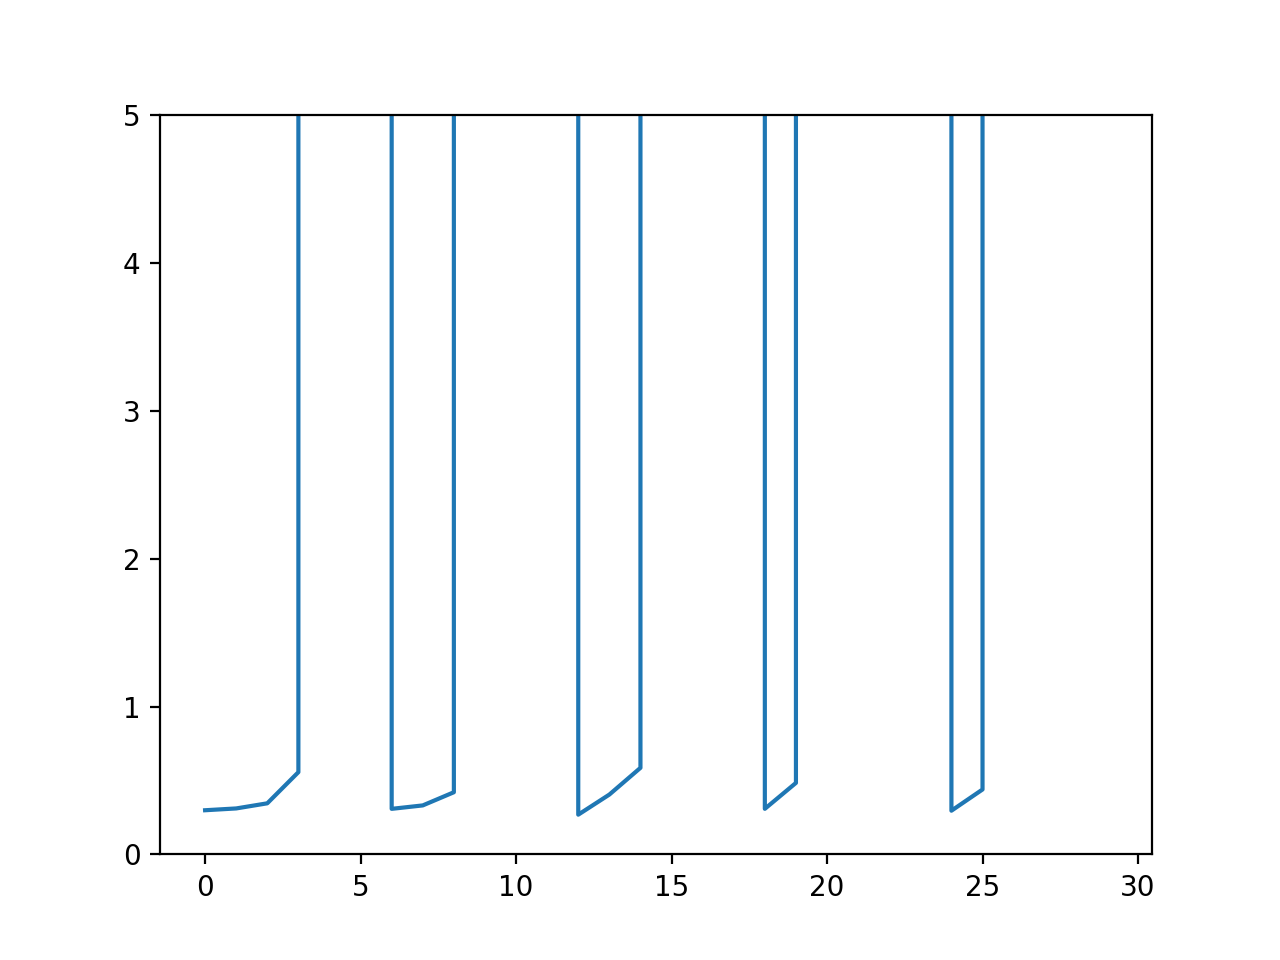

(0, 5)

In [873]:
plt.figure()
plt.plot(YY[iy,:,0,it,ix])
plt.ylim((0,5))

<IPython.core.display.Javascript object>


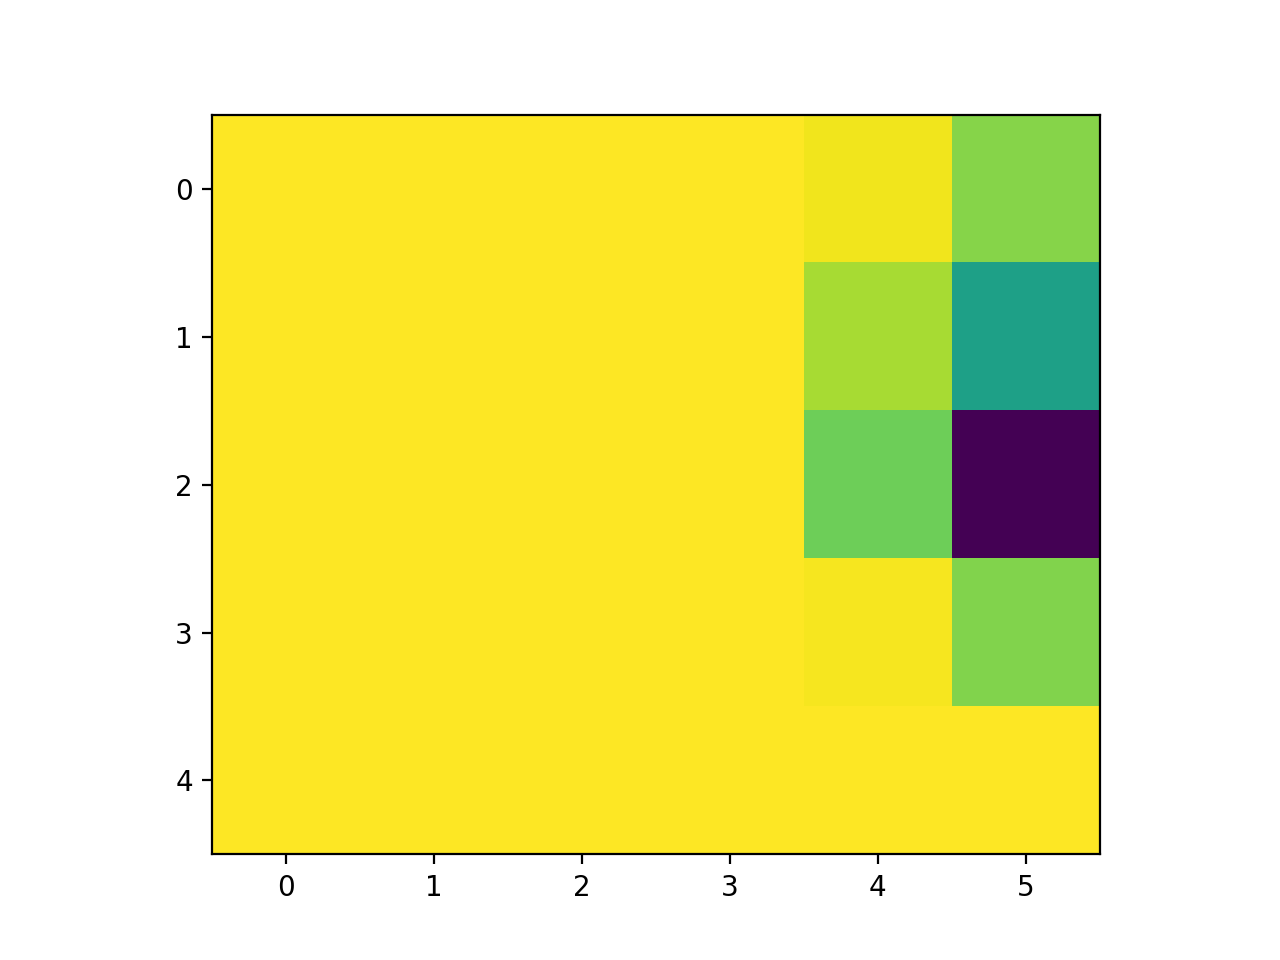

In [464]:
plt.figure()
istim = -12
plt.imshow((YY[0][:,1000,0]-YY[0][:,-1,0]).reshape((nsize,ncontrast)))

In [424]:
YY[0].shape

(30, 2001, 8)

<IPython.core.display.Javascript object>


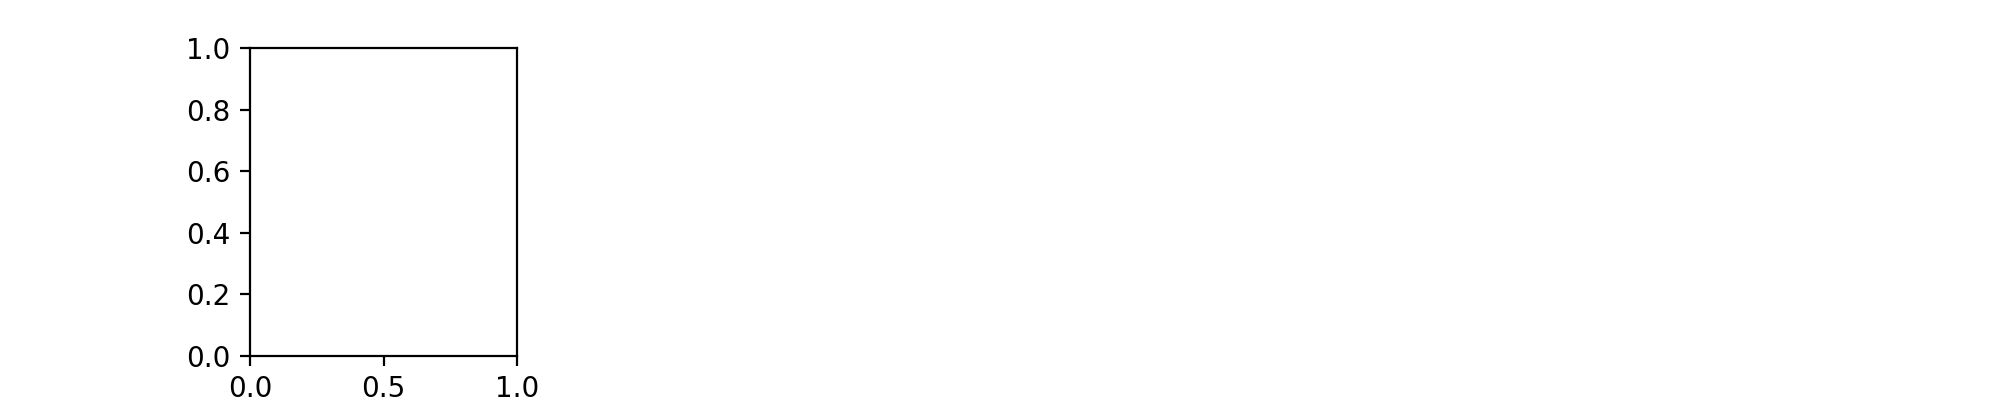

IndexError: too many indices for array

In [1268]:
mag = 2
plt.figure(figsize=(mag*ncelltypes,mag))
for icelltype in range(nQ):
    plt.subplot(1,ncelltypes,icelltype+1)
    plt.imshow(YY[:,:,-1,icelltype],vmin=0,interpolation='bilinear')
    plt.axis('off')

In [1278]:
nstar = len(trystars_i)
YY_no_vip = [None for istar in range(nstar)]
YY_no_sst = [None for istar in range(nstar)]
for istar in range(nstar):
    print(istar)
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    YY = compute_f_(Eta,Xi,s02)
    resEta = Eta - u_fn(XX,YY,Wmx,Wmy,k,kappa)
    resXi = Xi - u_fn(XX,YY,Wsx,Wsy,k,kappa)
    def fY(XX,YY,resEta,resXi):
        return compute_f_(u_fn(XX,YY,Wmx,Wmy,k,kappa)+resEta,u_fn(XX,YY,Wsx,Wsy,k,kappa)+resXi,s02)
    def thisfY(YY0):
        return fY(XX,YY0,resEta,resXi)
    def predict_YY_silencing(YY0,XX,resEta,resXi,silenced,eta=1e-4):
        def dYYdt(YY):
            return -YY + thisfY(YY)
        YY = YY0.copy() #np.zeros((nN,nS*nQ))
        dYY = np.ones_like(YY)
        iiter = 0
        while iiter < 1e4: #np.abs(dYY).sum()>1e-8*np.abs(YY).sum():
            iiter = iiter+1
            dYY = eta*dYYdt(YY)
            YY = YY + dYY
            YY[:,silenced] = 0
        return YY
    silenced = np.array((0,0,1,0,0,0,1,0),dtype='bool')
    YY_no_vip[istar] = predict_YY_silencing(YY,XX,resEta,resXi,silenced)
    silenced = np.array((0,1,0,0,0,1,0,0),dtype='bool')
    YY_no_sst[istar] = predict_YY_silencing(YY,XX,resEta,resXi,silenced)

0


In [1224]:
# plt.figure()
# inputs = XXhat[:,[0,2]]
# sort_inp = np.argsort(inputs[:,0])
# plt.scatter(inputs[:,0],inputs[:,1])

<IPython.core.display.Javascript object>


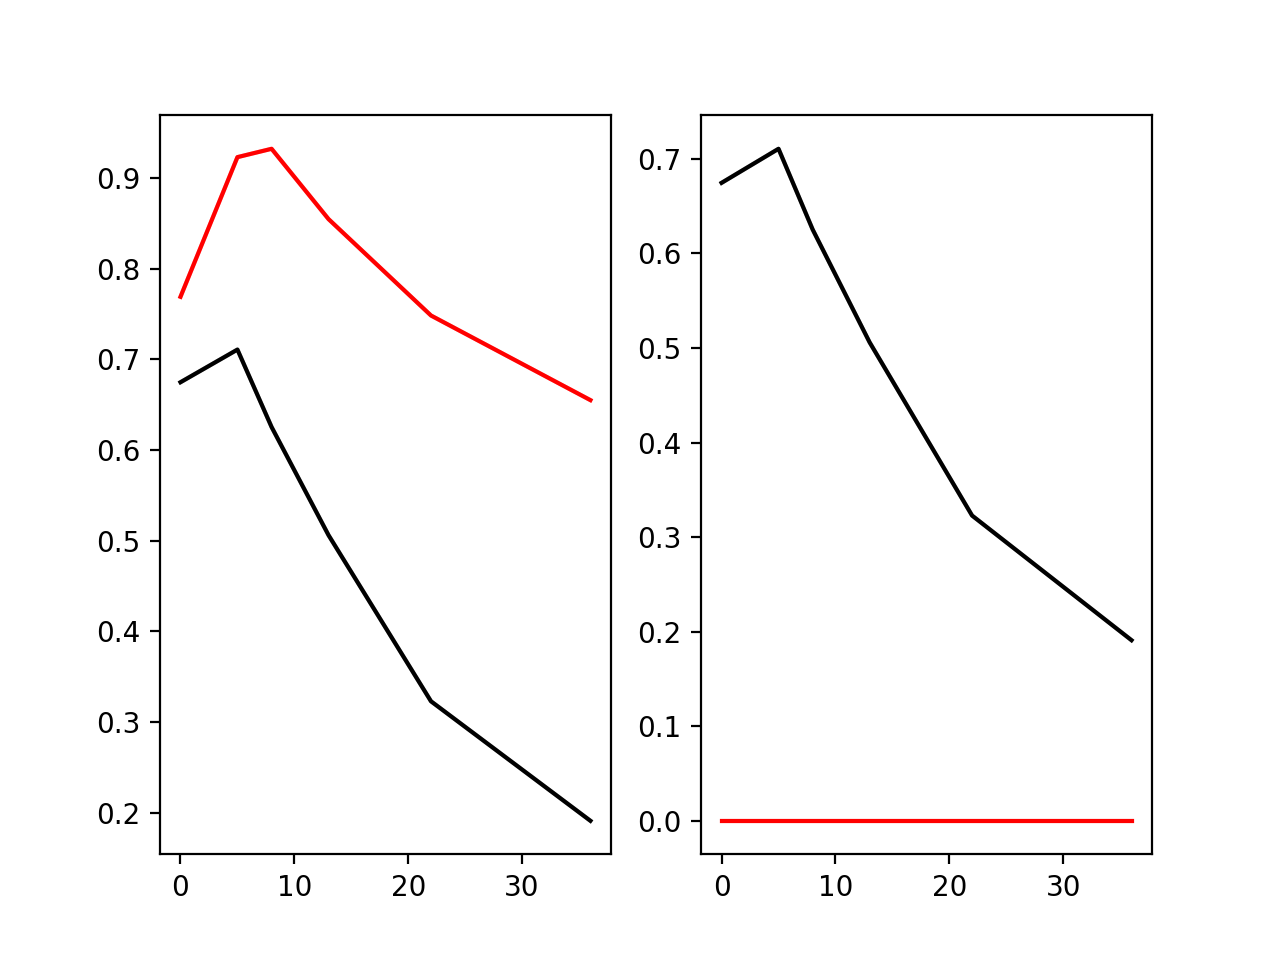

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [1270]:
plt.figure()
alpha1 = 0.25
ic = 2
icontrast = 5
colors = ['k','r']
def norm01(arr):
    return (arr-arr.min())/(arr.max()-arr.min())
for istar in range(nstar):
    ti,tj = trystars_i[istar],trystars_j[istar]
    Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
    YY = compute_f_(Eta,Xi,s02)
    plt.subplot(1,2,1)
    usize0 = (0,5,8,13,22,36)
    sc = YY[:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    if istar == 0:
        avg_curves = np.zeros((2,2,)+to_plot.shape)
    avg_curves[0,0] = avg_curves[0,0] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[0],alpha=alpha1)
    sc = YY_no_sst[istar][:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    avg_curves[0,1] = avg_curves[0,1] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[1],alpha=alpha1)
    plt.subplot(1,2,2)
    usize0 = (0,5,8,13,22,36)
    sc = YY[:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    avg_curves[1,0] = avg_curves[1,0] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[0],alpha=alpha1)
    sc = YY_no_vip[istar][:,ic].reshape((nsize,ncontrast))
    to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
    avg_curves[1,1] = avg_curves[1,1] + to_plot/nstar
    plt.plot(usize0,to_plot,c=colors[1],alpha=alpha1)
for imanip in range(2):
    plt.subplot(1,2,imanip+1)
    plt.plot(usize0,avg_curves[imanip,0],c=colors[0])
    plt.plot(usize0,avg_curves[imanip,1],c=colors[1])
    

<IPython.core.display.Javascript object>


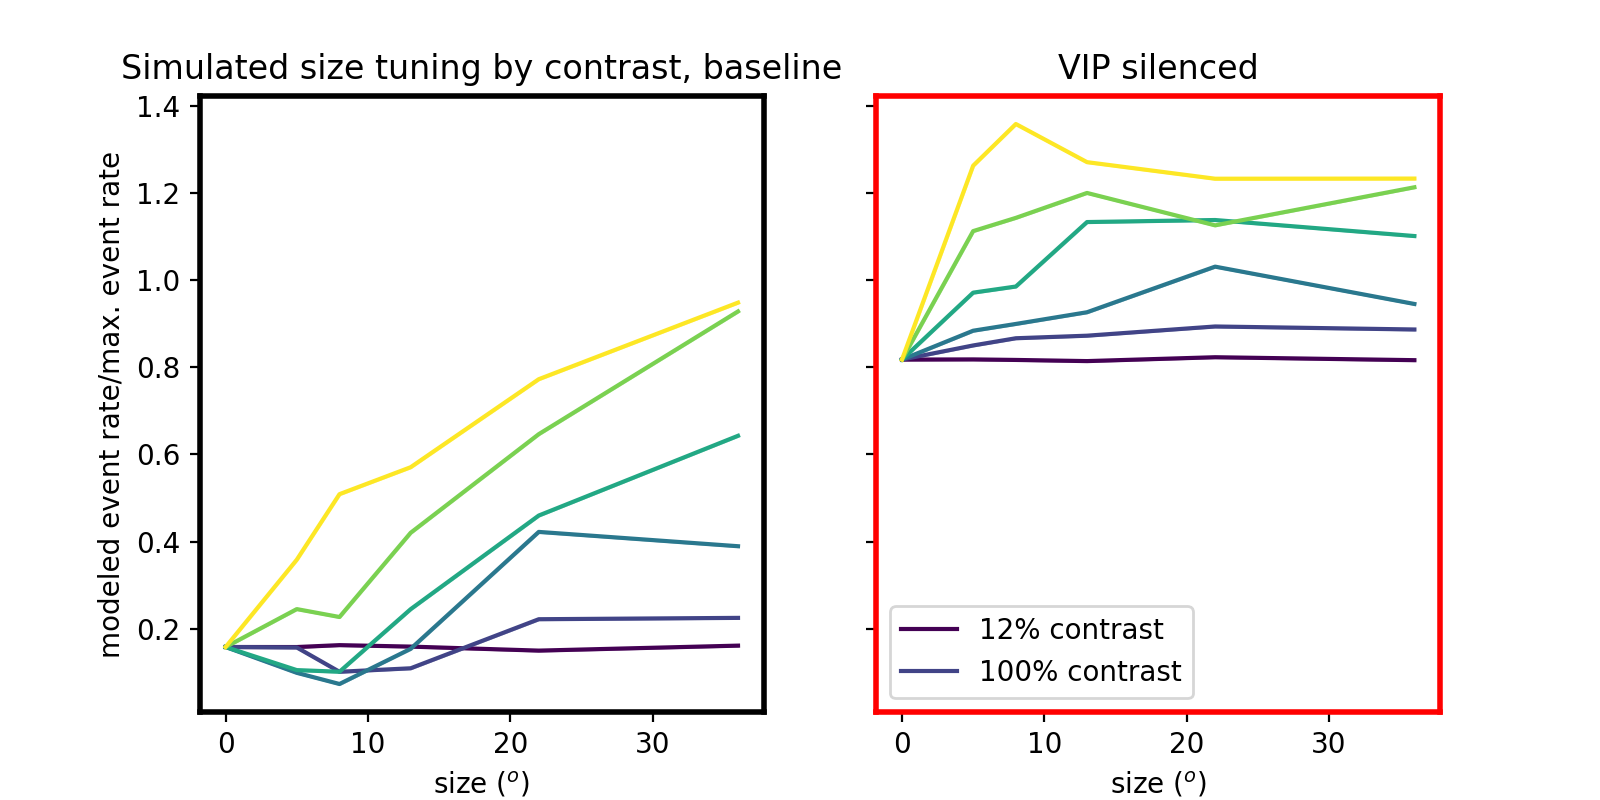

In [1281]:
fig,axes = plt.subplots(1,2,sharey=True,figsize=(8,4))
alpha1 = 0.25
ic = 1
icontrasts = np.arange(6)
colors = ['k','r']
colors = plt.cm.viridis(np.linspace(0,1,6))
nstar = 1
def norm01(arr):
    return (arr-arr.min())/(arr.max()-arr.min())
for icontrast in icontrasts:
    for istar in range(nstar):
        ti,tj = trystars_i[istar],trystars_j[istar]
        Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,XXp,Eta,Xi = Wt[ti][tj]
        YY = compute_f_(Eta,Xi,s02)
        usize0 = (0,5,8,13,22,36)
        sc = YY[:,ic].reshape((nsize,ncontrast))
        to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
        if istar == 0:
            avg_curves = np.zeros((2,2,)+to_plot.shape)
            to_plots = [np.zeros((0,)+to_plot.shape) for il in range(2)]
        avg_curves[1,0] = avg_curves[1,0] + to_plot/nstar
#         plt.subplot(1,2,1)
        to_plots[0] = np.concatenate((to_plots[0],to_plot[np.newaxis]))
#         plt.plot(usize0,to_plot,c=colors[icontrast],alpha=alpha1)
        sc = YY_no_vip[istar][:,ic].reshape((nsize,ncontrast))
        to_plot = np.concatenate(((sc[:,0].mean(),),sc[:,icontrast]))
        avg_curves[1,1] = avg_curves[1,1] + to_plot/nstar
#         plt.subplot(1,2,2)
#         plt.plot(usize0,to_plot,c=colors[icontrast],alpha=alpha1)
        to_plots[1] = np.concatenate((to_plots[1],to_plot[np.newaxis]))
    for il in range(2):
#         plt.subplot(1,2,il+1)
        axes[il].plot(usize0,avg_curves[1,il],c=colors[icontrast])
        lb,ub = ut.bootstrap(to_plots[il],pct=(16,84),fn=np.nanmean,axis=0)
        axes[il].fill_between(usize0,lb,ub,color=colors[icontrast],alpha=alpha1)
# plt.subplot(1,2,1)
# plt.title('Center-aligned, response to 12% contrast')
# plt.subplot(1,2,1)
axes[0].set_ylabel('modeled event rate/max. event rate')
axes[0].set_xlabel('size ($^o$)')
axes[1].set_xlabel('size ($^o$)')
plt.setp(axes[0].spines.values(),color='k',linewidth=2)
plt.setp(axes[1].spines.values(),color='r',linewidth=2)
axes[0].set_title('Simulated size tuning by contrast, baseline')
axes[1].set_title('VIP silenced')
axes[1].legend(['12% contrast','100% contrast'])
# plt.savefig('figures/modeled_vip_halo_size_tuning_by_contrast_fill_between.jpg',dpi=300)

In [428]:
(ti,),(tj,) = np.where(loss==np.min(loss)) #2*loss.min()
[Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = Wt[ti][tj]

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


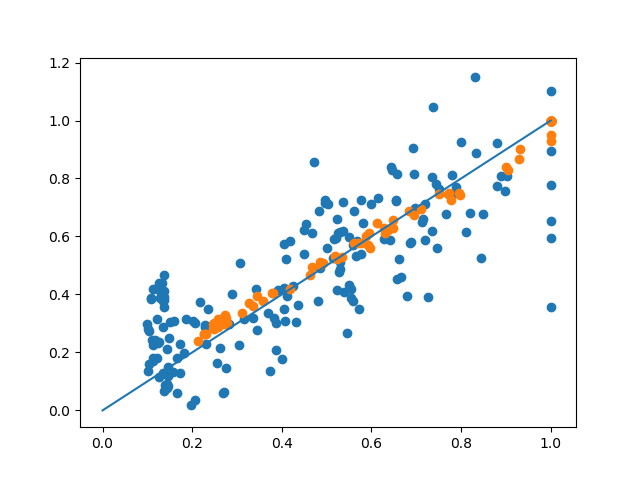

In [429]:
plt.figure()
XXhat = np.concatenate(Xhat,axis=1)
YYhat = np.concatenate(Yhat,axis=1)
plt.scatter(YYhat.flatten(),YY.flatten())
plt.scatter(XXhat.flatten(),XX.flatten())
plt.plot((0,1),(0,1))

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


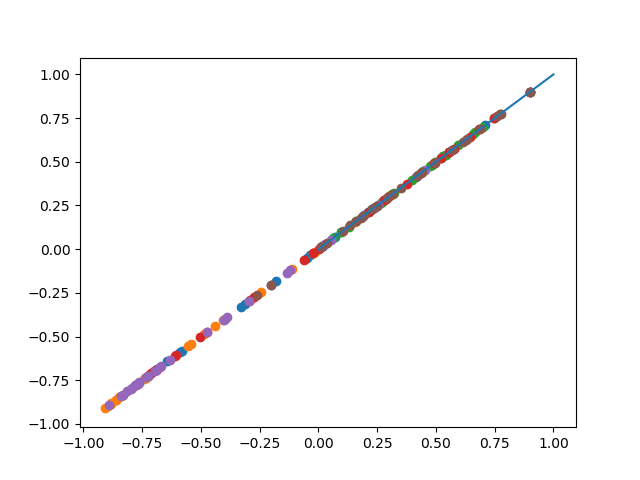

In [430]:
Etas = u_fn(XX,YY,Wmx,Wmy,k,kappa)
plt.figure()
for ic in range(6):
    plt.scatter(Eta[:,ic],Etas[:,ic])
plt.plot((0,1),(0,1))

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


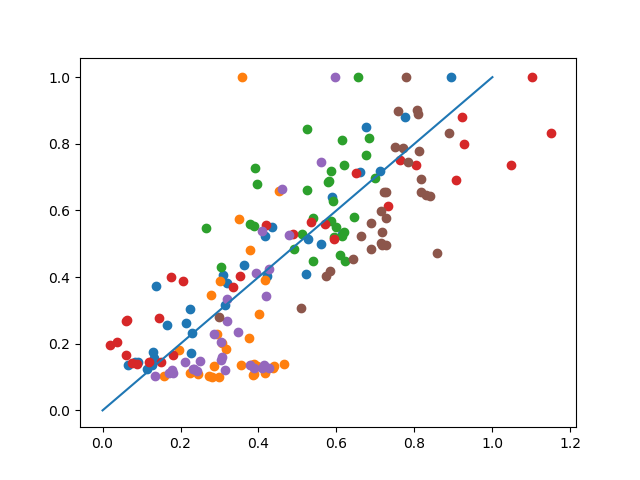

In [431]:
plt.figure()
YYs = compute_f_(Eta,Xi,s02)
for ic in range(6):
    plt.scatter(YY[:,ic],YYs[:,ic])
plt.plot((0,1),(0,1))

<IPython.core.display.Javascript object>


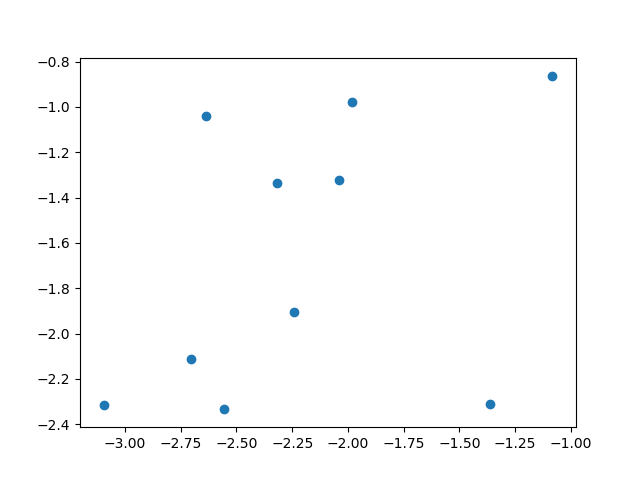

In [291]:
plt.figure()
plt.scatter(wmys[:,1,0],wmys[:,2,1])

In [514]:
wmys = np.concatenate([w[1][np.newaxis] for w in np.concatenate(Wt)],axis=0)
# trystar = np.argmax(wmys[:,1,0]*wmys[:,2,1])
# trystar = np.argmin(loss)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


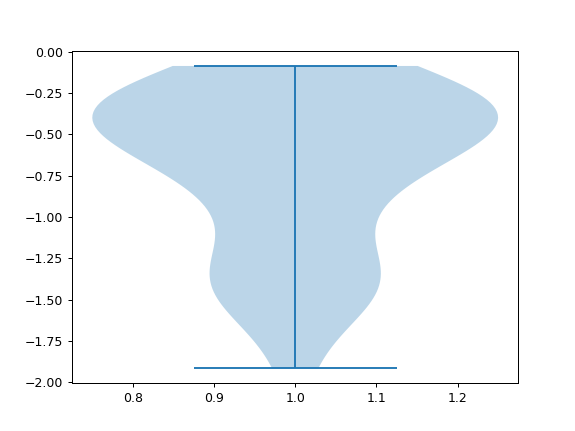

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f1bdc083a90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f1bdb9cec50>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f1bdc083790>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f1bdc083990>}

In [516]:
plt.figure()
plt.violinplot(wmys[:,1,0])

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


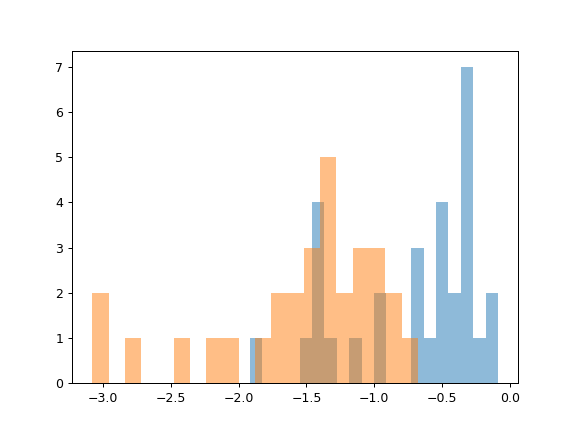

(array([2., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 2., 2., 3., 5., 2., 3.,
        3., 2., 1.]),
 array([-3.08046601, -2.96038626, -2.84030651, -2.72022677, -2.60014702,
        -2.48006727, -2.35998753, -2.23990778, -2.11982804, -1.99974829,
        -1.87966854, -1.7595888 , -1.63950905, -1.51942931, -1.39934956,
        -1.27926981, -1.15919007, -1.03911032, -0.91903057, -0.79895083,
        -0.67887108]),
 <a list of 20 Patch objects>)

In [515]:
plt.figure()
plt.hist(wmys[:,1,0],bins=20,alpha=0.5)
plt.hist(wmys[:,2,1],bins=20,alpha=0.5)

In [518]:
ws = [np.concatenate([w[q][np.newaxis] for w in np.concatenate(Wt)],axis=0) for q in range(len(Wt[0][0]))]
[Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = ws

In [541]:
ws = [np.concatenate([Wt[ti][tj][q][np.newaxis] for ti,tj in zip(trystars_i,trystars_j)],axis=0) for q in range(len(Wt[0][0]))]
[Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = ws

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


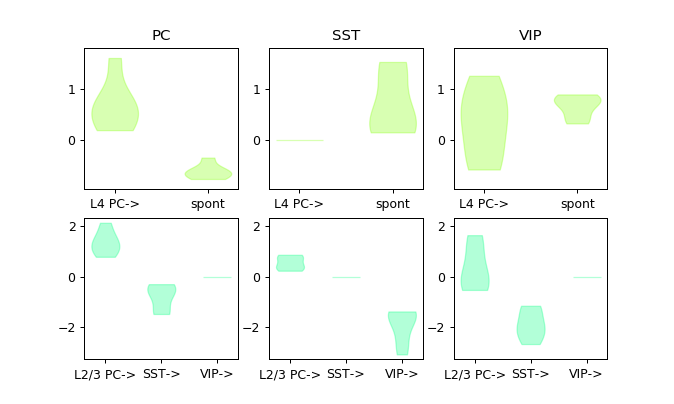

In [552]:
# ws = [np.concatenate([w[q][np.newaxis] for w in np.concatenate(Wt)],axis=0) for q in range(len(Wt[0][0]))]
# [Wmx,Wmy,Wsx,Wsy,s02,k,kappa,XX,YY,Eta,Xi] = ws
plt.figure(figsize=(7.5,4.5))
for datas in [[Wmx,Wmy]]:#,[Wsx,Wsy]]:
    titles = ['PC','SST','VIP']
    data = datas[0]
    x = np.arange(1,data.shape[1]+1)
    xlbl = ['L4 PC->','spont']
    for icelltype in range(3):
        plt.subplot(2,3,icelltype+1)
        violin_parts = plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])],showextrema=False)
        for pc in violin_parts['bodies']:
            pc.set_facecolor([0.5,1,0.0])
            pc.set_edgecolor([0.5,1,0.0])
        plt.xticks(x,xlbl)
        plt.ylim(data.min()-0.2,data.max()+0.2)
        plt.title(titles[icelltype])
#     plt.figure(figsize=(7.5,2))
    data = datas[1]
    x = np.arange(1,data.shape[1]+1)
    xlbl = ['L2/3 PC->','SST->','VIP->']
    for icelltype in range(3):
        plt.subplot(2,3,3+icelltype+1)
#         plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])])
        violin_parts = plt.violinplot([data[:,i,icelltype] for i in range(data.shape[1])],showextrema=False)
        for pc in violin_parts['bodies']:
            pc.set_facecolor([0.0,1,0.5])
            pc.set_edgecolor([0.0,1,0.5])
        plt.xticks(x,xlbl)
        plt.ylim(data.min()-0.2,data.max()+0.2)
#         plt.title(titles[icelltype])
plt.savefig('violinplots_fit_weights.jpg',dpi=300)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


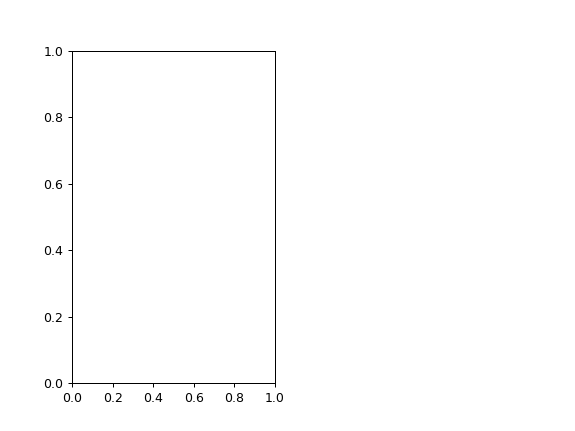

TypeError: list indices must be integers or slices, not tuple

In [543]:
plt.figure()
plt.subplot(1,2,1)
for ic in (0,):
    sca.scatter_size_contrast(YY[:,ic],YY_no_vip[:,ic])
    plt.plot((0,1),(0,1),c='k')
plt.axis('equal')
plt.subplot(1,2,2)
for ic in (0,):
    sca.scatter_size_contrast(YY[:,ic],YY_no_sst[:,ic])
    plt.plot((0,1),(0,1),c='k')
plt.axis('equal')

<IPython.core.display.Javascript object>


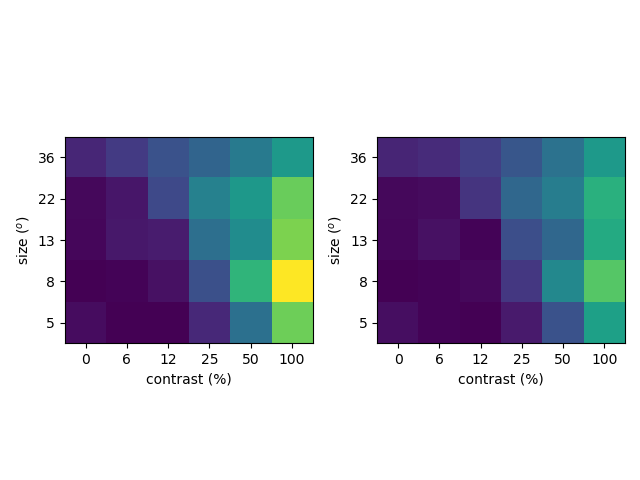

In [327]:
plt.figure()
ic = 0
plt.subplot(1,2,1)
sca.show_size_contrast(YY[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=YY[:,ic].max())
plt.subplot(1,2,2)
sca.show_size_contrast(YY_no_vip[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=YY[:,ic].max())
plt.tight_layout()

<IPython.core.display.Javascript object>


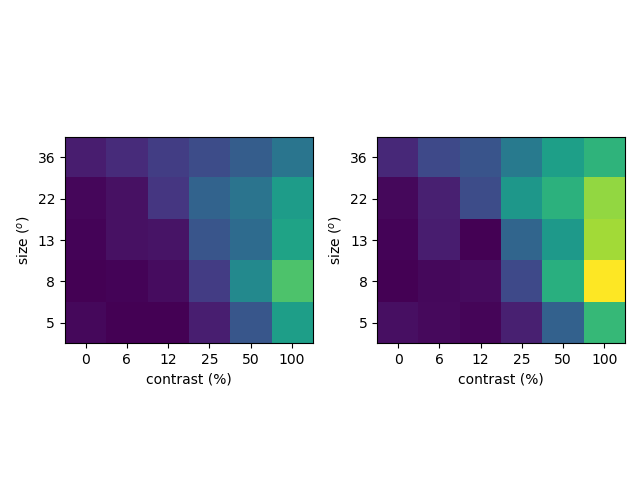

In [330]:
plt.figure()
ic = 0
mx = np.maximum(YY[:,ic].max(),YY_no_sst[:,ic].max())
plt.subplot(1,2,1)
sca.show_size_contrast(YY[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=mx)
plt.subplot(1,2,2)
sca.show_size_contrast(YY_no_sst[:,ic].reshape((nsize,ncontrast)),flipud=True,vmax=mx)
plt.tight_layout()

<IPython.core.display.Javascript object>


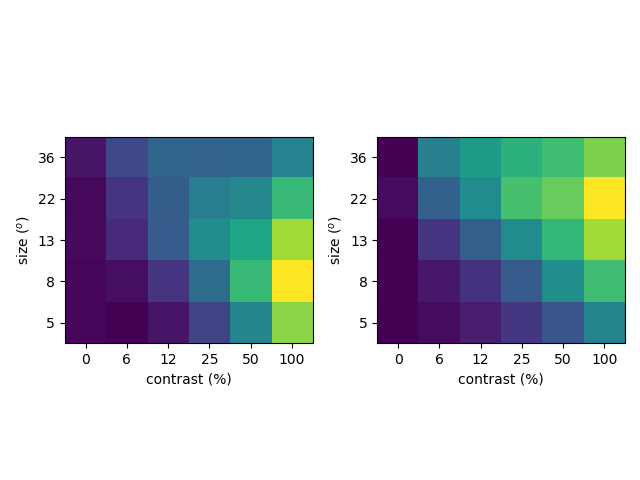

<IPython.core.display.Javascript object>


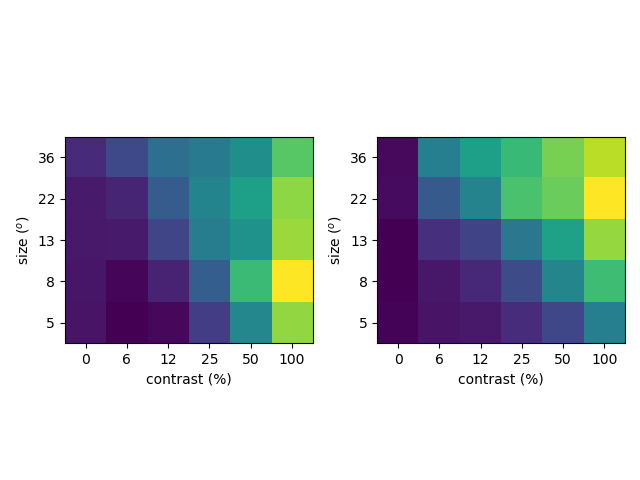

<IPython.core.display.Javascript object>


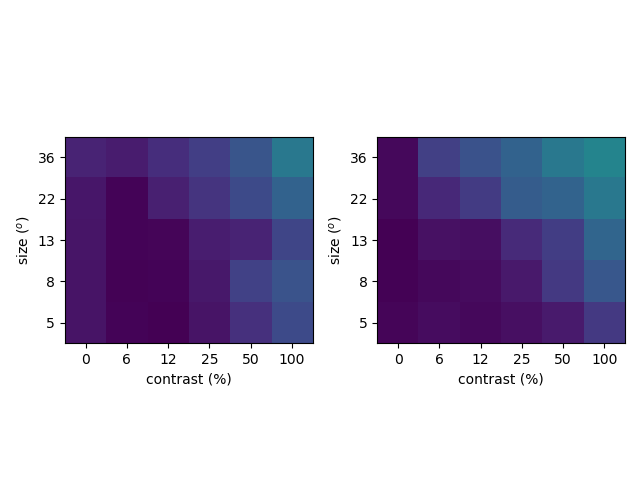

In [296]:
plt.figure()
reload(sca)
plt.subplot(1,2,1)
sca.show_size_contrast(YYhat[:,0].reshape((5,6)),flipud=True)
plt.subplot(1,2,2)
sca.show_size_contrast(YYhat[:,3].reshape((5,6)),flipud=True)
plt.tight_layout()

plt.figure()
reload(sca)
plt.subplot(1,2,1)
sca.show_size_contrast(YY[:,0].reshape((5,6)),flipud=True)
plt.subplot(1,2,2)
sca.show_size_contrast(YY[:,3].reshape((5,6)),flipud=True)
plt.tight_layout()

plt.figure()
reload(sca)
plt.subplot(1,2,1)
sca.show_size_contrast(YY_no_vip[:,0].reshape((5,6)),flipud=True,vmax=YY[:,0].max())
plt.subplot(1,2,2)
sca.show_size_contrast(YY_no_vip[:,3].reshape((5,6)),flipud=True,vmax=YY[:,3].max())
plt.tight_layout()

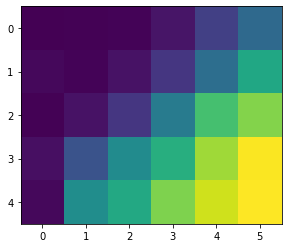

In [382]:
plt.figure()
plt.imshow(XX[:,2].reshape((5,6)))

In [383]:
vip_silencing = np.array((1,1,0,1,1,0))[np.newaxis,:]
Etas = u_fn(XX,YY,Wmx,Wmy,k)
Eta_no_vip = u_fn(XX,vip_silencing*YY,Wmx,Wmy,k) + Eta - Etas
YY_no_vip = compute_f_(Eta_no_vip,Xi,s02)*vip_silencing

In [ ]:
labels = ['Wmx','Wmy','Wsx','Wsy','s02','k','Y','momentum','loss']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wstar_t[i]

In [ ]:
evaluate_stability(W0my,k0)

In [ ]:
def sorted_r_eigs(w):
    drW,prW = np.linalg.eig(w)
    srtinds = np.argsort(drW)
    return drW[srtinds],prW[:,srtinds]

def gen_Weight(W,K):
    WW0 = np.concatenate((W,W*K[np.newaxis,:]),axis=1)
    WW1 = np.concatenate((W*K[np.newaxis,:],W),axis=1)
    WW = np.concatenate((WW0,WW1),axis=0)
    return WW
    
def evaluate_stability(Wmy,k):
    W = gen_Weight(Wmy,k)
    drW,prW = sorted_r_eigs(W - np.eye(npixels*nQ))
    return np.real(drW[-1])

In [ ]:
t = 999
W0mx,W0my,W0sx,W0sy,s020,k0 = [Wstar_t2[i][t].copy() for i in range(6)]

In [ ]:
nbeta = 51
loss = np.zeros((nbeta,))
stability = np.zeros((nbeta,))
betas = np.linspace(-1,1,nbeta)
vecY = np.random.randn(nQ,nQ)
vecX = np.random.randn(nP,nQ)
for ibeta,beta in enumerate(betas):
    perturbationY = beta*vecY
    perturbationX = beta*vecX
#     perturbationY = beta*np.array(((-1,0,0),(0,0,-1),(0,-1,0))) #beta*np.array(((2,0,0),(0,0,0),(0,0,0))) #perturbationY = beta*np.array(((0,0,0),(0,0,-1),(0,0,0))) # np.array(((0,0,0),(-1,0,0),(0,0,0)))
#     perturbationX = beta*np.array(((-1,0,0),(0,0,0))) #beta*np.array(((-1,0,0),(0,0,0))) #perturbationX = beta*np.array(((0,0,1),(0,0,0)))
#     perturbationSY = 0*beta*np.array(((0,0,0),(0,0,1),(0,0,0)))
    Wmy_beta = perturbationY+W0my.copy()
    Wmx_beta = perturbationX+W0mx.copy()
#     Wsy_beta = perturbationSY+W0sy.copy()
    loss[ibeta] = evaluate_LW(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=Y0.copy(),W0mx=Wmx_beta,W0my=Wmy_beta,W0sx=W0sx.copy(),W0sy=W0sy,s020=s020.copy(),k0=k0.copy(),bounds=bounds,weight=weight)
    stability[ibeta] = evaluate_stability(Wmy_beta,k0)

In [ ]:
plt.figure()
lkat = stability < 0
plt.plot(betas[lkat],loss[lkat])
plt.plot(betas[lkat],stability[lkat])
plt.ylim(-1,0.5)

In [ ]:
(betas[lkat][np.argmin(loss[lkat])],np.min(loss[lkat]))

In [ ]:
beta_star = betas[lkat][np.argmin(loss[lkat])]

In [ ]:
niter = int(1e3)
eta = 0.3
gamma = 0.9
weight = np.array((0,1,0))
beta = 0
perturbationY = beta*beta_star*vecY*1e-2
perturbationX = beta*beta_star*vecX*1e-2
# perturbationY = 0*beta*np.array(((-1,0,0),(0,0,-1),(0,-1,0))) #beta*np.array(((2,0,0),(0,0,0),(0,0,0))) #perturbationY = beta*np.array(((0,0,0),(0,0,-1),(0,0,0))) # np.array(((0,0,0),(-1,0,0),(0,0,0)))
# perturbationX = 0*beta*np.array(((-1,0,0),(0,0,0))) #beta*np.array(((-1,0,0),(0,0,0))) #perturbationX = beta*np.array(((0,0,1),(0,0,0)))
# # perturbationSY = beta*np.array(((0,0,0),(0,0,1),(0,0,0)))
# thisY0 = np.ones_like(Y0)
Y0 = [np.concatenate([x.mean(0)[:,np.newaxis] for x in Yhat[ialign]],axis=1) for ialign in range(npixels)]
Wstar_t2 = fit_W_momentum(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=Y0.copy(),W0mx=perturbationX+W0mx.copy(),W0my=perturbationY+W0my.copy(),W0sx=W0sx.copy(),W0sy=W0sy.copy(),s020=s020.copy(),k0=k0.copy(),bounds=bounds,niter=niter,weight=weight,eta=eta,gamma=gamma,barrier_wt=100e-4)#,eta_decay=eta_decay)

In [ ]:
np.linalg.eig(Wstar_dict2['Wmy'][400]-np.eye(nQ))

In [ ]:
titles = ['PC','SST','VIP']
t = 500
plt.figure(figsize=(6,2))
lbl = 'Wmx'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L4 PC->','spont']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])

plt.figure(figsize=(9,2))
lbl = 'Wmy'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L2/3 PC->','SST->','VIP->']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])
    
plt.figure(figsize=(6,2))
lbl = 'Wsx'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L4 PC->','spont']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])

plt.figure(figsize=(9,2))
lbl = 'Wsy'
data = Wstar_dict2[lbl][t]
x = np.arange(data.shape[0])
xlbl = ['L2/3 PC->','SST->','VIP->']
for icelltype in range(3):
    plt.subplot(1,3,icelltype+1)
    plt.bar(x,data[:,icelltype])
    plt.xticks(x,xlbl)
    plt.ylim(data.min()-0.2,data.max()+0.2)
    plt.title(titles[icelltype])


In [ ]:
#Wstar_dict = np.load('w_over_time_miller_troyer_data_loss.npy',allow_pickle=True)[()]

In [ ]:
Wstar_t_init = [ww[-1].copy() for ww in Wstar_t2]
W0mx,W0my,W0sx,W0sy,s020 = [Wstar_t_init[i].copy() for i in range(5)]
Y0 = Wstar_t_init[-3].copy()

In [ ]:
niter = int(1e4)
eta = 1
gamma = 0.9
eta_decay = 1e-3
weight = np.array((1,1,1))
thisY0 = np.ones_like(Y0)
Wstar_t_novar = fit_W_momentum(X.copy(),Yhat.copy(),pop_rate_fn=f_miller_troyer,neuron_rate_fn=evaluate_f_mt,Y0=thisY0,W0mx=W0mx.copy(),W0my=W0my.copy(),W0sx=W0sx.copy(),W0sy=W0sy.copy(),s020=s020.copy(),bounds=bounds,niter=niter,weight=weight,eta=eta,gamma=gamma)#,eta_decay=eta_decay)

In [ ]:
# niter = int(1e3)
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(Wstar_t2[i].reshape((niter+1,-1)))
plt.figure()
plt.plot(Wstar_t2[4].reshape((niter+1,-1)))

In [ ]:
# labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
# Wstar_dict = {}
# for i,label in enumerate(labels):
#     Wstar_dict[label] = Wstar_t[i]
# np.save('w_over_time_miller_troyer_data_loss.npy',Wstar_dict,allow_pickle=True)

In [ ]:
# labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
#Wstar_dict = {}
#for i,label in enumerate(labels):
#    Wstar_dict[label] = Wstar_t[i]


In [ ]:
def plot_tuning_and_loss(this_Wstar):
    plt.figure()
    plt.plot((this_Wstar[-3]/this_Wstar[-3].sum(1)[:,np.newaxis]).reshape((niter+1,-1)))
    plt.figure()
    plt.plot(this_Wstar[-1].reshape((niter+1,-1)))

In [ ]:
#niter = 300
plot_tuning_and_loss([x[:niter+1] for x in Wstar_t2])

In [ ]:
def scatter_results_spatial(this_Wstar,t=-1):
    plt.figure(figsize=(9,6))
    celltype = ['PC','SST','VIP']
    ialign = 0
    for ialign in range(2):
        for i in range(3):
            plt.subplot(2,3,3*ialign+i+1)
            plt.title(celltype[i])
            xx = Yhat[ialign][i].mean(0)/Yhat[ialign][i].mean(0).sum()
            yy = this_Wstar[-3][t,:,3*ialign+i]/this_Wstar[-3][t,:,3*ialign+i].sum()
            sca.scatter_size_contrast(xx,yy)
            plt.plot((0,xx.max()),(0,xx.max()),c='k')
            plt.xlabel('measured')
            plt.ylabel('modeled')
            plt.tight_layout()

In [ ]:
t = 500
scatter_results_spatial(Wstar_t2,t=t) #int(5e3))
# plt.savefig('figures/pc_sst_vip_measured_modeled_miller_troyer.pdf')

In [ ]:
def gaussian_fn(mu,sigma):
    return lambda x: 1/np.sqrt(2*np.pi)/np.abs(sigma)*np.exp(-0.5*(x-mu)/sigma**2)
xs = np.linspace(0,1,100)
ipt = 0
# plt.figure()
# for icelltype in range(2):
#     plt.plot(xs,gaussian_fn(um_fn(X[ipt],Y[ipt])[icelltype],us_fn(X[ipt],Y[ipt])[icelltype])(xs))

In [224]:
iiter = -1
Wmx,Wmy,Wsx,Wsy = [Wstar_t[i][iiter] for i in range(4)]

def fXY(x,y):
    return f_miller_troyer(x @ Wmx + y @ Wmy, x @ Wsx + y @ Wsy)

def u_fn_fn(Wx,Wy):
    return lambda x,y: x @ Wx + y @ Wy

def um_fn(x,y):
    return u_fn_fn(Wmy,Wmx)(x,y)

def us_fn(x,y):
    return u_fn_fn(Wsy,Wsx)(x,y)

# Ysolns = compute_Y_nonlinear_t_evolution(X,Wmx,Wmy,Wsx,Wsy,f_miller_troyer,Y0=Wstar_t[-2][iiter+1].copy())

NameError: name 'Wstar_t' is not defined

In [327]:
Xlbl = [['L4','spont'],['PC','SST','VIP']]
Ylbl = ['PC','SST','VIP']

In [283]:
for i in range(2):
    values0 = np.round(Wstar_t_novar[i][-1],decimals=2)
    values1 = np.round(Wstar_t_novar[i+2][-1],decimals=2)
    to_print = np.zeros_like(values0,dtype='<U32')
    if np.mod(i,2)==0:
        for i in range(to_print.shape[0]):
            for j in range(to_print.shape[1]):
                to_print[i,j] = Xlbl[0][i] + ' -> ' + Xlbl[1][j] + ': ' + str(values0[i,j]) + ' +/- ' + str(values1[i,j])
    else: 
        for i in range(to_print.shape[0]):
            for j in range(to_print.shape[1]):
                to_print[i,j] = Ylbl[i] + ' -> ' + Ylbl[j] + ': ' + str(values0[i,j]) + ' +/- ' + str(values1[i,j])
    print(to_print)
    print('\n')
# for i in range(4,5):
#     values = np.round(Wstar_t[i][-1],decimals=2)
#     print(values)

NameError: name 'Wstar_t_novar' is not defined

<IPython.core.display.Javascript object>


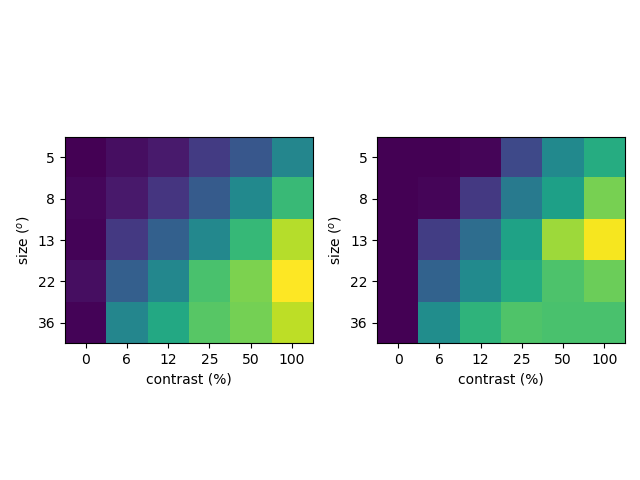

<IPython.core.display.Javascript object>


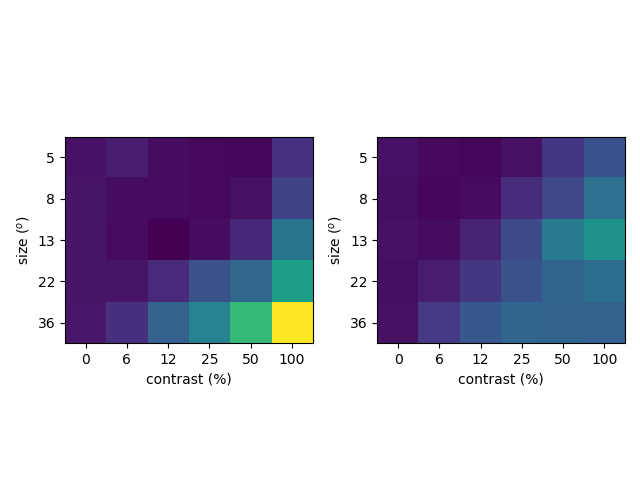

<IPython.core.display.Javascript object>


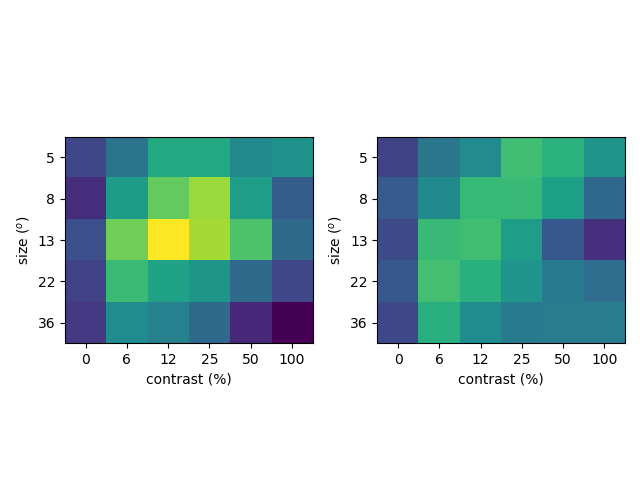

In [541]:
#lbl = ['pc','sst','vip']
#for icelltype in range(3):
#    this_Wstar = Wstar_t_novar
#    t = -1
#    display_model_fit(Yhat[icelltype].mean(0)/Yhat[icelltype].mean(0).sum(),this_Wstar[-3][t,:,icelltype]/this_Wstar[-3][t,:,icelltype].sum())
#    plt.savefig('figures/' + lbl[icelltype] + '_measured_modeled.pdf')

In [585]:
labels = ['Wmx','Wmy','Wsx','Wsy','s02','Y','momentum','loss']
Wstar_dict = {}
for i,label in enumerate(labels):
    Wstar_dict[label] = Wstar_t[i]

In [586]:
np.save('w_over_time_miller_troyer_data_loss_momentum.npy',Wstar_dict,allow_pickle=True)

In [270]:
def scatter_results(this_Wstar,t=-1):
    plt.figure(figsize=(9,3))
    celltype = ['PC','SST','VIP']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(celltype[i])
        xx = Yhat[i].mean(0)/Yhat[i].mean(0).sum()
        yy = this_Wstar[-3][t,:,i]/this_Wstar[-3][t,:,i].sum()
        sca.scatter_size_contrast(xx,yy)
        plt.plot((0,xx.max()),(0,xx.max()),c='k')
        plt.xlabel('measured')
        plt.ylabel('modeled')
        plt.tight_layout()

In [1]:
icelltype = 3
u,s,v = np.linalg.svd(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])])
# plt.figure()
# plt.imshow(Rs[1][])

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


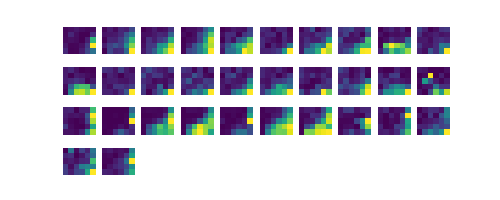

In [500]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(np.logical_and(u[:,0]<np.percentile(u[:,0],52.5),u[:,0]>np.percentile(u[:,0],47.5)))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


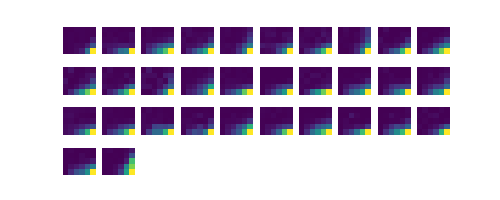

In [501]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(u[:,0]<np.percentile(u[:,0],5))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


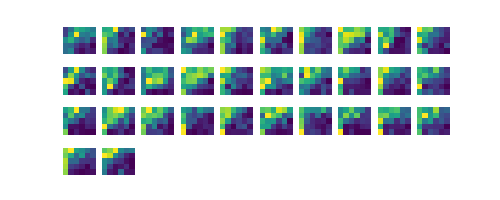

In [502]:
ut.imshow_in_rows(Rs[icelltype][~np.isnan(Rs[icelltype][:,0])][np.where(u[:,0]>np.percentile(u[:,0],95))].reshape((-1,5,6)))

<IPython.core.display.Javascript object>


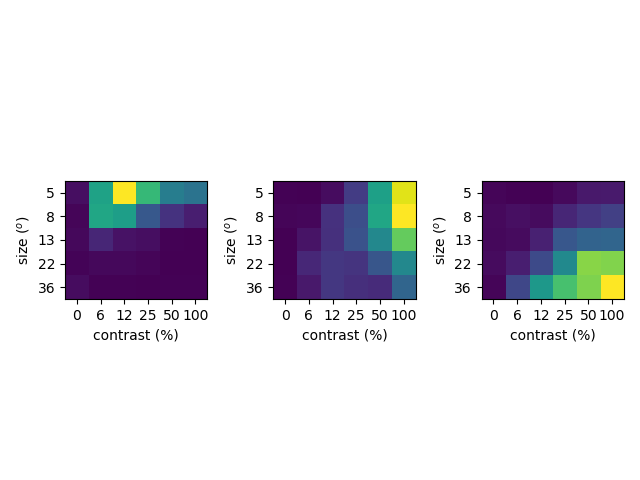

In [508]:
# ut.imshow_in_rows(Rs[1][~np.isnan(Rs[1][:,0])][np.where(u[:,0]>np.percentile(u[:,0],95))].reshape((-1,5,6)))
lower = np.where(u[:,0]<np.percentile(u[:,0],5))[0][28]
middle = np.where(np.logical_and(u[:,0]<np.percentile(u[:,0],52.5),u[:,0]>np.percentile(u[:,0],47.5)))[0][19]
upper = np.where(u[:,0]>np.percentile(u[:,0],95))[0][90]
plt.figure()
for i,thisone in enumerate([upper,middle,lower]):
    plt.subplot(1,3,i+1)
    sca.show_size_contrast(Rs[1][~np.isnan(Rs[1][:,0])][thisone].reshape((5,6)))
plt.tight_layout()
plt.savefig('figures/l23_pc_variability.pdf')

<IPython.core.display.Javascript object>


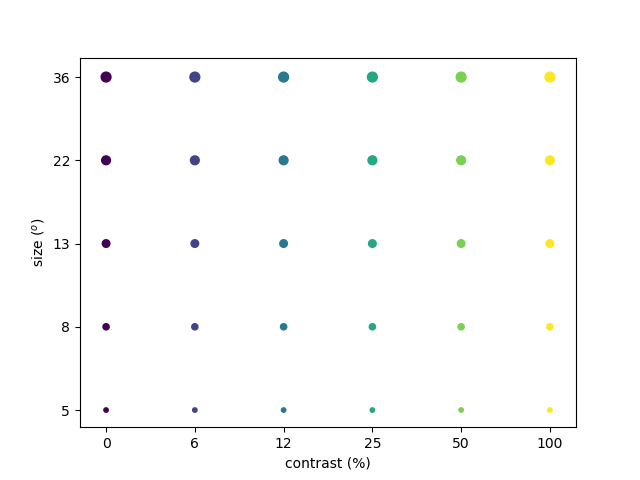

In [519]:
plt.figure()
xx,yy = np.meshgrid(np.arange(6),np.arange(5))
xx = xx.flatten()
yy = yy.flatten()
sca.scatter_size_contrast(xx,yy)
plt.xticks(np.arange(6),(0,6,12,25,50,100))
plt.xlabel('contrast (%)')
plt.yticks(np.arange(5),(5,8,13,22,36))
plt.ylabel('size ($^o$)')
plt.savefig('figures/measured_modeled_legend.pdf')
# plt.axis('off')

In [278]:
#niter = int(1e3)
#Ws = [Wstar_t[i][-1].copy() + 1e-2*np.random.randn(*Wstar_t[i][-1].shape) for i in range(4)]
#Wstar_t2 = fit_W_linearized_pointwise(X.copy(),Yhat.copy(),f_miller_troyer,Y0=Yhat.copy(),W0mx=Ws[0],W0my=Ws[1],W0sx=Ws[2],W0sy=Ws[3],bounds=bounds,niter=niter,weight=np.array((1,10,1)))
#scatter_results(Wstar_t2)

In [308]:
def pca_denoise(arr,Npc):
    u,s,v = np.linalg.svd(arr)
    return u[:,:Npc] @ np.diag(s[:Npc]) @ v[:Npc,:]

In [309]:
Rpc2 = pca_denoise(Rpc[~np.isnan(Rpc.sum(1))],10)

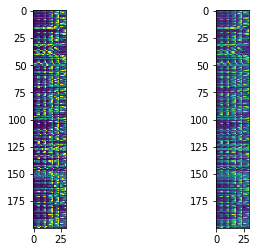

In [312]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Rpc[:200])
plt.subplot(1,2,2)
plt.imshow(Rpc2[:200])